# **Loan Default Prediction**

**Table of Content**

[Executive Summary](#exec)

[Problem & Solution Summary](#problem)

[Recommendations for Implementation](#reco)

[Data Overview](#data-overview)

[Exploratory Data Analysis (EDA)](#eda)

[Machine Learning Models](#ml)

## **Executive Summary**
<a id=exec></a>

### Key Findings

* The overall default rate on Home Equity Loans (HEL) is <b>20%</b> - high vs historical default rates

* Most borrowers are highly leveraged: 91% LTV including HEL, 71 credit lines, 23% have existing delinquencies, 14% have derogaroty reports

* 30% of loan applications are not complete

* Default rates are much higher when applications are not complete: 34% vs 9%, ie 3.8x ratio

* Tested models can predict close to 75% of all defaults, but at the cost of about 35% of false positives (which is high). The implementation decision should take into account this trade-off and other parameters affecting the overall profitability of the lending activity (including the Loss Given Default rate)

* The lack of and actual level of Debt/Income ratio is identified by all models are the main driving factor in loan defaults

### Proposed Model

* The proposed model is a <b>decision tree</b>

* The decision tree has about the same performance than random forest but has better interpretability and is easier to implement

* The model was optimized for recall, ie maximimization of default detection

* Depth of the tree is 4

## **Problem and Solution Summary**
<a id=problem></a>

### Background & Problem Statement

Lending is one of banks' core activities and a major source of revenue and profits. A 'Home Equity Loan' is a specific type of secured lending, in which a borrower uses the equity in his/her home as collateral. The term 'equity' in 'Home Equity Loan' refers to the portion of the property "owned" by the borrower, ie the unencumbered part of the asset. It includes the initial deposit + capital repayments. 
 
 A Home Equity Loan is quite similar to a mortgage, but there are 2 main differences:
 
 * <u>the purpose of the loan</u>: a mortgage is used to purchase the property, while a home equity loan is used for other reasons - typically home improvements or debt consolidation

 * <u>the level of risk</u>: a mortgage is a form of 'first-lien' debt while home equity loan is usually 'second-lien'. That means that if the borrower defaults, creditors holding first-lien debt (the mortgage) are paid first. Home Equity loans are therefore 1) intrisically linked to any existing mortgage on the proprety and 2) <strong> higher risk</strong>. 

 Loan underwriting presents multiple challenges:
 
 * loan applications are costly to process as resource-intensive and often relying on legacy systems
 
 * loan applications are prone to human errors and bias
 
 * defaults can be very costly as credit P&L distributions are typically assymetric, highly skewed and fat-tailed 

### How can ML help?

ML now provides powerful and cost-efficient tools to build automated, data-driven processes, with the following benefits:

* more objective decision process (less bias), and less manual errors

* better insight on risk factors, good data visualization 

* ability to easily update models as new inputs come in

In the context of loan underwriting, this can help: 

* implement a more robust process

* reduce costs and human-related errors/bias

* reduce loan defaults and associated costs / capital losses

* finally, decision trees also provide great transparency when it comes to tracing how/why a descison was made

### Expected Impact

* Reduce credit losses: using the recall and prediction levels of the selected model, a basic calculation shows that ML can increase profitability by about 50% on the sample loan book but it's important to note that this figure is very sensitive to other parameters like interest rate level,  time before default and loss given default. 

* Operational costs: automation would most likely have a significant positive impact on underwriting costs but that's difficult to estimate without more data about the internal setup of the lender. Note that a ML-driven would also induce some additonal costs: model research and validation, development (back end + front end), maintenance, cloud / compute resource, etc

* Identify what factors are driving default risk. The selelect modeled clearly identifies missing Debt to Income ratio as the main explanatory variable. Other significant factors include Debt to Income level, number of deliquencies and age of the oldest credit line.



<a id=reco></a>
## **Recommendations for Implementation**

### Key actionables and recommendations

* Do NOT approve any applications that are not complete - borrowers must provide all required data points and this should be enforced in systems and/or operational procedures. There is strong evidence in historical data showing that borrowers who do not provide full information have **abnormally high** default rates vs other borrowers. This suggests that some applicants may intentionally retain/conceal data in order to secure a loan.

* Clarify the utlity function of the project before going ahead. Since the precision level is low, implementing the model could potentially reduce profitability (althoug default rate would be lower).

* Source more data: the current dataset includes very little demographics data (age, location etc), little detail about income breakdown and no external credit scores. Including those would potentially improve the performance of the models. Credit scores may also allow to cross-check some of the provided information and detect potential issues.

* Monitor model performance: the model is currently overwhelingly dominated by 'missing data' (as a factor). As the problem is being addressed, other factors will become more prominent and the model will have to be recalibrated or even potentially changed depending on performance.

### Expected Benefits and Costs

* See expected impact above

### Potential Risks and Limitations

* Feature dominance: the dominance of 'missing data' is somewhat obstructing the analysis of default drivers under "normal circumstances". Further analysis could be run on a conditional dataset (complete applications), or on a future dataset that will include less missing data

* Model output is binary and only tries to predict whether a loan will default or not. There is no concept of $ expected loss here (what the lender should ultimately try to minimize)

* The model is “static“ and uses data at inception of the loan - more sophisticated models should also re-evaluate the default probability / loss over time, ideally using macroeconomic data and capturing correlation risk

* Any model might introduce unwanted demographic bias, which might clash with existing civil laws (example: ECOA)

* Consumer Credit and the Financial sector in general are heavily regulated – any implemented model should be auditable, reproducible and fully documented (including data preparation phase). 

* ML models should comply with new / upcoming AI regulation (example: new EU AI Act [https://artificialintelligenceact.eu/the-act/])

## **Python Libraries & Config Variables**

In [3]:
# general
import pandas as pd
import numpy as np

# viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# ML (scikit learn + others)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV # for tuning
import sklearn.metrics as metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)
import shap

# statsmodels
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [4]:
# Seaborn General Settings
sns.set(style="darkgrid")
sns.set(font_scale = 0.8)

## **Data Overview**
<a id=data-overview></a>

### Data Description
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

### Dataset Overview

In [5]:
# LOAD DATASET
# 'd0' is the 'raw' dataset and won't be altered - several "copies" of the dataset will be built later, each with a different level of processing
d0 = pd.read_csv("hmeq.csv")
d0.head(5)

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

In [6]:
d0['LOAN'].sum()

110903500

In [7]:
# CREATE CLASS TO HANDLE SOME OVERVIEW TASKS

class DataOverview:

    def __init__(self, df) -> None:
        
        self.data = df 
        self.shape = self.get_shape()
        self.rows = self.shape[0]
        self.cols = self.shape[1]
        self.points = self.rows * self.cols
        self.missing = self.data.isna().sum().sum()
        self.missing_pct = self.missing / self.points
    
    def get_shape(self, print=False):
        
        s = self.data.shape
        if print:
            print("Rows: {rows} | Columns: {cols}".format(rows=s[0], cols=s[1]))
        return s
    
    def get_col_summary(self):

        # count non-NA per column
        c = self.data.count().to_frame().rename(columns={0: 'count_notnull'})
        
        # count missing per column
        m = self.data.isna().sum().to_frame().rename(columns={0: 'count_missing'})

        # count unique per column
        u = self.data.nunique().to_frame().rename(columns={0: 'unique'})

        # col types
        t = self.data.dtypes.to_frame().rename(columns={0: 'dtype'})

        # merge df
        df = pd.merge(c, m, how='left', left_index=True, right_index=True)
        df = pd.merge(df, u, how='left', left_index=True, right_index=True)
        df = pd.merge(df, t, how='left', left_index=True, right_index=True)

        # add cols
        df['count_total'] = df['count_notnull'] + df['count_missing']
        df['missing_pct'] = df['count_missing'] / df['count_total']

        # order cols
        df = df[['dtype', 'count_notnull', 'count_missing', 'count_total', 'missing_pct', 'unique']]

        return df
    
    def get_summary(self):

        x = {"data points": self.points, "rows": self.rows, "cols": self.cols, 
             "missing": self.missing, "missing_pct": self.missing_pct,
             "duplicated": self.get_duplicated()
             }
        
        d = pd.DataFrame.from_dict(data=x, orient='index')

        return d
    
    def get_value_count(self, col, dropna=False):

        # value count for a given col

        d = self.data
        
        x = pd.DataFrame(d[col].value_counts(dropna=dropna))
        x.rename(columns={col: 'count'}, inplace=True)
        x.index.name = col
        x['count_pct'] = d[col].value_counts(normalize=True)
        
        return x


    def get_describe(self):

        return self.data.describe().T
    
    def get_duplicated(self):

        return self.data.duplicated().sum()


In [8]:
# Instantiate Data Overview object
do = DataOverview(d0)

In [9]:
# Get high-level summary
do.get_summary()

0
data points  77480.00000
rows          5960.00000
cols            13.00000
missing       5271.00000
missing_pct      0.06803
duplicated       0.00000

In [10]:
# Get summary by column
do.get_col_summary()

dtype  count_notnull  count_missing  count_total  missing_pct  \
BAD        int64           5960              0         5960     0.000000   
LOAN       int64           5960              0         5960     0.000000   
MORTDUE  float64           5442            518         5960     0.086913   
VALUE    float64           5848            112         5960     0.018792   
REASON    object           5708            252         5960     0.042282   
JOB       object           5681            279         5960     0.046812   
YOJ      float64           5445            515         5960     0.086409   
DEROG    float64           5252            708         5960     0.118792   
DELINQ   float64           5380            580         5960     0.097315   
CLAGE    float64           5652            308         5960     0.051678   
NINQ     float64           5450            510         5960     0.085570   
CLNO     float64           5738            222         5960     0.037248   
DEBTINC  float64           4693           1267         5960     0.212584   

         unique  
BAD           2  
LOAN        540  
MORTDUE    5053  
VALUE      5381  
REASON        2  
JOB           6  
YOJ          99  
DEROG        11  
DELINQ       14  
CLAGE      5314  
NINQ         16  
CLNO         62  
DEBTINC    4693

In [11]:
# LIST USEFUL COLUMNS

# Categorical Cols (type will be converted later)
cols_cat = ['BAD', 'REASON', 'JOB']

# Numeric Cols
cols_num = ['LOAN', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'NINQ', 'CLNO', 'DEBTINC']

In [12]:
# Check categorical features' values

for c in cols_cat:
    print("-"*30)
    print(do.get_value_count(c))

------------------------------
     count  count_pct
BAD                  
0     4771   0.800503
1     1189   0.199497
------------------------------
         count  count_pct
REASON                   
DebtCon   3928   0.688157
HomeImp   1780   0.311843
NaN        252        NaN
------------------------------
         count  count_pct
JOB                      
Other     2388   0.420349
ProfExe   1276   0.224608
Office     948   0.166872
Mgr        767   0.135011
NaN        279        NaN
Self       193   0.033973
Sales      109   0.019187


In [13]:
# Create a copy of the original raw dataset (d0)
d1 = d0.copy()

In [14]:
# Get basic stats by column
do.get_describe()

count           mean           std          min           25%  \
BAD      5960.0       0.199497      0.399656     0.000000      0.000000   
LOAN     5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE    5848.0  101776.048741  57385.775334  8000.000000  66075.500000   
YOJ      5445.0       8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0       0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0       0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0     179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0       1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0      21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0      33.779915      8.601746     0.524499     29.140031   

                  50%            75%            max  
BAD          0.000000       0.000000       1.000000  
LOAN     16300.000000   23300.000000   89900.000000  
MORTDUE  65019.000000   91488.000000  399550.000000  
VALUE    89235.500000  119824.250000  855909.000000  
YOJ          7.000000      13.000000      41.000000  
DEROG        0.000000       0.000000      10.000000  
DELINQ       0.000000       0.000000      15.000000  
CLAGE      173.466667     231.562278    1168.233561  
NINQ         1.000000       2.000000      17.000000  
CLNO        20.000000      26.000000      71.000000  
DEBTINC     34.818262      39.003141     203.312149

Observations

* Dataset size: 5,960 rows (records) and 13 columns 
* The 13 columns includes the target ('BAD' label) and 12 features describing the profile of the borrower
* Only 2 features are categorical: REASON and JOB. The BAD label is 0/1 so can be treated as categorical as well. Data type will be converted later. All other features are numeric
* There aren't many features in the dataset compared to what a bank/lender would typically ask for. There is little "qualitative" profiling of the applicant (age bracket, marital status, children, address etc) and little information about the income and other assets.
* The dataset doesn't include any duplicates
* The dataset includes a significant proportion of missing data points - almost 7% overall (21% for the DBETINC feature). This is quite significant so will require further analysis.

<a id=eda></a>
## **Exploratory Data Analysis (EDA) and Visualization**

### **EDA Useful Functions**

#### Feature Distribution Analyzer

In [15]:
class FeatureDistAnalyzer:

    """"
    Description:    generic class to analyze feature distribution
                    some methods are dtype-specific
    """


    def __init__(self, data, feature, bins=None):
        
        self.data = data
        self.feature = feature
        self.bins = bins
        self.feature_dtype = data[feature].dtype

        # useful stats (if feature is numeric)
        self.mean = data[feature].mean() if self.feature_dtype in ['int64', 'float64'] else None
        self.median= data[feature].median() if self.feature_dtype in ['int64', 'float64'] else None
        self.max = data[feature].max() if self.feature_dtype in ['int64', 'float64'] else None
        self.min = data[feature].min() if self.feature_dtype in ['int64', 'float64'] else None
        self.skew = data[feature].skew() if self.feature_dtype in ['int64', 'float64'] else None
        self.stdev = data[feature].std() if self.feature_dtype in ['int64', 'float64'] else None

        self.default_rate = data[data['BAD']==1][self.feature].count()/data[self.feature].count()

    def plot_hist(self, figsize=(12,6), hue='BAD', kde=True):
        
        """
        Description:      plots Boxplot + Histogram + Cumulative Histogram (numeric features only)
        param figsize:    size of figure
        param kde:        whether to the show density curve
        """

        d = self.data
        f = self.feature
        b = self.bins

        # Create figure with subplots
        fig, (ax_box, ax_hist1, ax_hist2) = plt.subplots(
            nrows=3,        # Number of rows of the subplot
            sharex=True,    # x-axis will be shared among all subplots
            gridspec_kw={"height_ratios": (0.1, 0.45, 0.45)},
            figsize=figsize,
        )

        # Set title
        fig.suptitle(f + " Distribution")

        # Populate the subplots

        # Plot 1: Boxplot (star indicates mean value) ---------------------------------------------------------
        sns.boxplot(data=d, x=f, ax=ax_box, showmeans=True, color="violet")
        
        # Plot 2: Histogram # 1 -------------------------------------------------------------------------------- 
        if b is not None:
            sns.histplot(data=d, x=f, kde=kde, ax=ax_hist1, bins=b, hue=hue, multiple="stack", palette="winter") 
        else:
            sns.histplot(data=d, x=f, kde=kde, ax=ax_hist1, hue=hue, multiple="stack", palette="winter")

        # Add mean to the histogram
        ax_hist1.axvline(x=self.mean, color="green", linestyle="--", label="mean")

        # Add median to the histogram  
        ax_hist1.axvline(x=self.median, color="black", linestyle="-", label="median")

        # Annotations
        ymax = ax_hist1.get_ylim()[1]
        xpos = self.max - 2 * self.stdev

        ax_hist1.text(x= xpos, y=0.9*ymax, s=f'Min = {self.min:.1f}')
        ax_hist1.text(x= xpos, y=0.8*ymax, s=f'Max = {self.max:.1f}')
        ax_hist1.text(x= xpos, y=0.7*ymax, s=f'Mean = {self.mean:.1f}')
        ax_hist1.text(x=xpos, y=0.6*ymax, s=f'Median = {self.median:.1f}')
        ax_hist1.text(x=xpos, y=0.5*ymax, s=f'Stdev = {self.stdev:.1f}')
        ax_hist1.text(x=xpos, y=0.4*ymax, s=f'Skew = {self.skew:.1f}')

        # Plot 3: Histogram (Cumulative) --------------------------------------------------------------------------
        if b is not None:
            sns.histplot(data=d, x=f, cumulative=True, stat='percent', kde=kde, ax=ax_hist2, bins=b, palette="winter", hue=hue, multiple="stack") 
        else: 
            sns.histplot(data=d, x=f, cumulative=True, stat='percent', kde=kde, ax=ax_hist2, palette="winter", hue=hue, multiple="stack") 
        
    def get_data(self):
        
        """
        Description:    creates table with detailed data split by BAD status and calculates default rate stats
                        works for numeric and categorical features
        """
           
        x = self.data.copy()
        x['counter'] = 1
        
        # add bucket if bins are provided
        if self.bins is not None:
            f = self.feature + '_bucket'
            x[f] = pd.cut(x[self.feature], self.bins, right=False)
        else:
            f = self.feature

        x = x[[f, 'BAD', 'counter']]

        # group by feature
        y = x.groupby(by=[f, 'BAD'], as_index=False, sort=True).agg('sum')

        # pivot
        z = y.pivot(columns=['BAD'], index=f, values=['counter'])

        # add total colum
        z['counter', 'total'] = z['counter'][0] + z['counter'][1]

        # add total cumulative
        z['counter', 'total_cumul'] = z['counter']['total'].cumsum()
    
        # add % of total columns
        total = z['counter']['total'].sum()
        z['counter_pct_total', 0] = z['counter'][0] / total
        z['counter_pct_total', 1] = z['counter'][1] / total
        z['counter_pct_total', 'total'] = z['counter']['total'] / total
        z['counter_pct_total', 'total_cumul'] = z['counter_pct_total']['total'].cumsum()

        # add default rate stats
        z['defaults', 'default_total_cumul'] = z['counter'][1].cumsum() 
        z['defaults', 'default_rate_within_bucket'] = z['counter'][1] / z['counter']['total'] 
        total_default = z['counter'][1].sum()
        z['defaults', 'pct_of_all_defaults'] = z['counter'][1] / total_default
        z['defaults', 'pct_of_all_defaults_cumul'] = z['defaults', 'pct_of_all_defaults'].cumsum()

        return z

    def plot_defaults(self, figsize=(12,4), sort_by='default_rate_within_bucket'):

        d = self.get_data()

        # keep useful cols
        d = d[[('counter', 1), ('defaults', 'default_rate_within_bucket'), ('defaults', 'pct_of_all_defaults')]]

        # drop level and rename
        d = d.droplevel(0, axis=1)
        
        # rename 
        d.rename(columns={1: 'counter'}, inplace=True)

        # sort descending
        #d.sort_values(by=sort_by, inplace=True)

        # Create figure with subplots
        fig, (ax_bp1, ax_bp2) = plt.subplots(
            nrows=1,        
            ncols=2,
            sharey=True,
            gridspec_kw={"width_ratios": (0.5, 0.5)},
            figsize=figsize,
        )
        
        # Set title
        fig.suptitle(" Defaults By " + self.feature + " (rate and pct by bin/category)")

        # Build barplot
        sns.barplot(d, y=d.index, x='default_rate_within_bucket', ax=ax_bp1, errorbar=('ci', 95))
        sns.barplot(d, y=d.index, x='pct_of_all_defaults', ax=ax_bp2, errorbar=('ci', 95))

        return d

    def plot_cat(self, figsize=(10,3)):
        
        """
        Description:    bar plots for categorical data
        """
        
        d = self.get_data()
        f = self.feature

        # Create figure with subplots
        fig, (ax_bp1, ax_bp2) = plt.subplots(
            nrows=1,        
            ncols = 2,
            sharey=False,    
            gridspec_kw={"width_ratios": (0.5, 0.5)},
            figsize=figsize,
        )

        # Set title
        fig.suptitle(f + " Distribution")

        # Keep useful cols
        d1 = d[[('counter', 1), ('counter',0)]]
        d2 = d[[('counter_pct_total', 1), ('counter_pct_total',0)]]

        # Drop level and rename
        d1 = d1.droplevel(0, axis=1)
        d2 = d2.droplevel(0, axis=1)

        # Build stacked barplot
        d1.plot(kind='bar', stacked=True, ax=ax_bp1, color=['red', 'green'])
        d2.plot(kind='bar', stacked=True, ax=ax_bp2, color=['red', 'green'])

        # Set Y label
        ax_bp1.set_ylabel("Count")
        ax_bp2.set_ylabel("Pct of Total")

    def plot_scatter(self, vs_feature='BAD', hue='BAD', size=None, market_size=15):

        d = self.data

        # set size
        plt.figure(figsize=(5,4))

        sns.scatterplot(d, y=d[self.feature], x=d[vs_feature], hue=hue, size=size, s=market_size)

        # set title
        my_title = self.feature + " vs " + vs_feature
        plt.suptitle(my_title)

    def plot_lm(self, vs_feature='BAD', hue='BAD', size=None, market_size=8):

        d = self.data

        sns.lmplot(d, y=self.feature, x=vs_feature, col=hue, hue=hue, scatter_kws={'s': market_size}, height=4, aspect=1.2)

        # set title
        my_title = self.feature + " vs " + vs_feature
        plt.suptitle(my_title)
        


#### Correlation Analyzer

In [16]:
class CorrelAnalyzer:

    def __init__(self, data, cols=None, drop_bad=True):

        self.data = data
        self.cols = cols
        self.drop_bad = drop_bad

        self.get_cols()

    def get_cols(self):

        # extracts columns to analyze
        c = []
        if self.cols is None:
            # select all numeric cols
            c = list(self.data.select_dtypes(include='number').columns)
        else:
            c = self.cols
        
        if self.drop_bad:
            c.remove('BAD')
        
        self.cols = c


    def correl_matrix(self, filter_bad=None, triangular=True):

        # filter dataset if required
        if filter_bad is not None:
            d = self.data[self.data['BAD']==filter_bad]
        else:
            d = self.data

        corr = d[self.cols].corr()

        if triangular:
            # create mask for triangular matrix
            mask = np.tril(np.ones_like(corr), k=-1).astype(bool)
            corr = corr.where(mask)

        return corr


    def correl_diff(self):

        corr0 = self.correl_matrix(filter_bad=0)
        corr1 = self.correl_matrix(filter_bad=1)

        corr_diff = corr0 - corr1

        return corr_diff


    def correl_top(self, filter_bad=None, filter=0.3, filter_abs=True):

        corr = self.correl_matrix(filter_bad=filter_bad)
        corr_flat = corr.unstack().sort_values(ascending=False)
        if filter_abs:
            corr_flat = corr_flat[abs(corr_flat)>=filter]
        else:
            if filter >= 0:
                corr_flat = corr_flat[abs(corr_flat)>=filter]
            else:
                corr_flat = corr_flat[abs(corr_flat)<=filter]

        return corr_flat


    def plot_correl(self, filter_bad=None, split_bad=True, my_title = "Correlations"):

        """ 
        param filter_bad:   None = all | 1 | 0
        param split_bad:    True -> include 2 additional heatmaps (and ignore filter_bad)
        """

        if not split_bad:

            corr = self.correl_matrix(filter_bad=filter_bad)

            # create mask for triangular matrix
            mask_tri = np.triu(np.ones_like(corr))

            # create heatmap on filtered dataset
            plt.figure(figsize=(7,5))
            sns.heatmap(data=corr, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt=".1f", mask=mask_tri)
            plt.title(my_title)
            plt.show()

        else:

            corr = self.correl_matrix(filter_bad=None)
            corr0 = self.correl_matrix(filter_bad=0)
            corr1 = self.correl_matrix(filter_bad=1)
            corr_diff = corr1 - corr0

            # Create figure with subplots
            fig, axs = plt.subplots(
                nrows=2,        
                ncols = 2,
                sharey=False,    
                gridspec_kw={"width_ratios": (0.5, 0.5)},
                figsize=(16,14),
            )
            sns.heatmap(data=corr, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt=".1f", ax=axs[0,0])
            sns.heatmap(data=corr_diff, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt=".1f", ax=axs[0,1])
            sns.heatmap(data=corr0, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt=".1f", ax=axs[1,0])
            sns.heatmap(data=corr1, cmap='Spectral', vmin=-1, vmax=1, annot=True, fmt=".1f", ax=axs[1,1])

            axs[0,0].set_title('Correlations (all)')
            axs[0,1].set_title('Correlations Delta (BAD=1 - BAD=0)')
            axs[1,0].set_title('Correlations (BAD=0)')
            axs[1,1].set_title('Correlations (BAD=1)')



#### Summary by BAD status

In [17]:
def features_summary(d, cols=cols_num):

    d1 = d.groupby(['BAD'])[cols].mean(numeric_only=True).T
    d2 = d.groupby(['BAD'])[cols].median(numeric_only=True).T
    
    x = d1.merge(d2, how='inner', left_index=True, right_index=True, suffixes=('_mean', '_median'))

    x['diff_mean'] = x['1_mean'] - x['0_mean']
    x['diff_mean_pct'] = x['diff_mean'] / x['1_mean'] 
    
    x['diff_median'] = x['1_median'] - x['0_median']
    x['diff_median_pct'] = x['diff_median'] / x['1_median']

    col_order=['0_mean', '1_mean', 'diff_mean', 'diff_mean_pct', '0_median', '1_median', 'diff_median', 'diff_median_pct']

    return x[col_order]

#### Test (remove later)

In [18]:
# HISTOGRAMS + BOXPLOTS

def histogram_boxplot(data, feature, hue='BAD', figsize=(12, 6), kde=False, bins=None):
    
    
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """

    fig, (ax_box, ax_hist1, ax_hist2) = plt.subplots(
        nrows=3,        # Number of rows of the subplot grid= 2
        sharex=True,    # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.1, 0.45, 0.45)},
        figsize=figsize,
    )

    # set title
    fig.suptitle(feature + " Distribution")

    # Create the subplots

    # Plot 1: Boxplot (star indicates mean value) --------------------------
    sns.boxplot(
        data=data, x=feature, ax=ax_box, showmeans=True, color="violet", 
    )
    
    # Plot 2: Histogram ---------------------------------------------------- 
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist1, bins=bins, 
        palette="winter", 
        hue=hue, multiple="stack"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist1,
        palette="winter", 
        hue=hue, multiple="stack"
    )

    # calculate useful stats
    mean = data[feature].mean()
    median= data[feature].median()
    max = data[feature].max()
    min = data[feature].min()
    skew = data[feature].skew()
    stdev = data[feature].std()
    ymax = ax_hist1.get_ylim()[1]

    # Add mean to the histogram
    ax_hist1.axvline(x=mean, color="green", linestyle="--", label="mean")

    # Add median to the histogram  
    ax_hist1.axvline(x=median, color="black", linestyle="-", label="median")

    # Annotations
    ax_hist1.text(x=max - stdev, y=0.9*ymax, s=f'Mean = {mean:.1f}')
    ax_hist1.text(x=max - stdev, y=0.8*ymax, s=f'Median = {median:.1f}')
    ax_hist1.text(x=max - stdev, y=0.7*ymax, s=f'Stdev = {stdev:.1f}')
    ax_hist1.text(x=max - stdev, y=0.6*ymax, s=f'Skew = {skew:.1f}')

    # Plot 3: Histogram (Cumulative) ---------------------------------------
    sns.histplot(
        data=data, x=feature, cumulative=True, stat='percent', kde=kde, ax=ax_hist2, bins=bins, 
        palette="winter", 
        hue=hue, multiple="stack"
    ) if bins else sns.histplot(
        data=data, x=feature, cumulative=True, stat='percent', kde=kde, ax=ax_hist2,
        palette="winter", 
        hue=hue, multiple="stack"
    ) 
    

In [19]:
# DIST PLOT (plotly)

def distplot(data, feature, fig_height=700, fig_width=900, kde=False, bins=None):
    
    
    """
    param data:         dataframe
    param feature:      dataframe column
    param fig_height:   
    param fig_width:    
    param kde:          whether to the show density curve (default False)
    param bins:         number of bins for histogram (default None)
    """

    fig = make_subplots(rows=3, cols=1,
                        subplot_titles=("Plot1", "Cumulative"),
                        row_heights=[0.4, 0.3, 0.3])


    # set title
    fig.update_layout(height=fig_height, width=fig_width, title_text="Distribution (" + feature + ")")

    # Create the subplots
    s1 = px.histogram(data, x=feature, marginal="box", color="BAD").update_traces(opacity=0.7)
    s2 = px.histogram(data, x=feature, marginal="box", color="BAD", cumulative=True).update_traces(opacity=0.7)

    fig.add_trace(s1['data'][0], row=1, col=1)
    fig.add_trace(s1['data'][1], row=2, col=1)
    fig.add_trace(s2['data'][0], row=3, col=1)

    fig.show()
   

In [20]:
def plot_hist(df, feature, color=None, marginal=None, cumulative=None, nbins=None, histnorm=None, opacity=0.7):

    # add bins

    # title
    my_title = feature + " Distribution"
    if cumulative:
        my_title = my_title + " (Cumulative)"

    # create figure
    fig = px.histogram(df, x=feature, marginal=marginal, cumulative=cumulative, histnorm=histnorm, color=color, nbins=nbins, 
                       title=my_title,
                       width=1000, height=500, opacity=opacity)

    # add mean 
    fig.add_vline(x=df['LOAN'].mean(), line_dash='dot', annotation_text="mean", annotation_position="top right")
    
    # add median
    fig.add_vline(x=d1['LOAN'].median(), line_dash='solid', annotation_text="median", annotation_position="top left")
    
    # update layout
    fig.update_layout(
        title_font_family="Arial Black",
        title_font_color="black",
        bargap=0.1)

    fig.show()

In [21]:
#plot_hist(d1, 'LOAN', marginal="box", cumulative=True, color="BAD", histnorm="percent", nbins=50)

In [22]:
#fig = ff.create_distplot([d1['LOAN']], group_labels=['LOAN'], bin_size=1000)
#fig.update_layout(bargap=0.2)
#fig.show()

In [23]:
#distplot(d1, 'LOAN')

### **Additional Features**

Before starting the EDA, I would like to add a few features that may (or may not!) have some explanatory power:

* <font color="#3399FF"><strong> LTV </strong></font> (Loan to Value): this is the current ratio <font color="#3399FF">MORTDUE / VALUE</font> and measures the level of indebtedness for the property itself (not necessarily the overall indebtedness of the applicant as he/she might have additional debt or assets as well). The ratio typically ranges from 0 (no mortgage or mortgage completed) to 1 (extreme and now very unlikely cases when the bank would finance 100% of the property value). The higher the LTV, the higher the indebtedness (and most likely, the probability of default on the mortgage). This might be an important factor as the ability to repay could be related to a relative level of debt rather than an absolute amount. Note: we could have used <strong> Leverage </strong> as well but this is directly related to LTV (leverage = 1 / (1-LTV)) so one of those is enough.

* <font color="#3399FF"><strong> LTV_ADJ </strong></font> (Adjusted LTV): this is the LTV adjusted by the new loan amount, ie <font color="#3399FF">(MORTDUE + LOAN) / VALUE</font>. Adjusted LTV might exceed 100% if the loan is large vs current mortgage due.

* <font color="#3399FF"><strong> LTMORT </strong></font> (Loan To Mortgage): this is the size of the loan relative to the mortgage (when applicable), calculated as <font color="#3399FF">LOAN / MORTDUE</font>. 

* <font color="#3399FF"><strong> MISSPCT </strong></font>: this is the percentage of missing data points <i>per application</i>, calculated as <font color="#3399FF">No Blanks / 11</font> (there are 13 columns including the label and loan amount, that are always populated). Although it could be seen as a technical indicator, the lack of data could also be interepreted in that case as a failure to gather (lender) / provide (borrower) sufficient information and a risk factor in its own right, correlated to the default rate. 

* <font color="#3399FF"><strong> DELINQ_PCT </strong></font>: percentage of deliquent credit lines, calculated as <font color="#3399FF">DELINQ / CLNO</font>. That could be a good indicator of current solvency issues.

In [24]:
# Add proportion of missing features per row 
# Using 11 as denominator as BAD and LOAN are (and must be) always populated
d1['MISSPCT'] = d1.isna().sum(1) / 11

In [25]:
# Add LTV
d1['LTV'] = d1['MORTDUE'] / d1['VALUE']

In [26]:
# Add LTV_ADJ
d1['LTV_ADJ'] = (d1['LOAN'] + d1['MORTDUE']) / d1['VALUE']

In [27]:
# Add LTMORT
d1['LTMORT'] = d1['LOAN'] / d1['MORTDUE']

In [28]:
# Add DELINQ_PCT 
d1['DELINQ_PCT'] = d1.apply(lambda x: x['DELINQ'] / x['CLNO'] if x['CLNO'] > 0 else None, axis=1) 

In [29]:
# Fill Missing Values for REASON and JOB
# In this instance we can simply use 'unknown' without making any assumptions/extrapolations
d1['REASON'].fillna(value='*unknown*', inplace=True)
d1['JOB'].fillna(value='*unknown*', inplace=True)

In [30]:
do1 = DataOverview(d1)
do1.get_describe()

count           mean           std          min           25%  \
BAD         5960.0       0.199497      0.399656     0.000000      0.000000   
LOAN        5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE     5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE       5848.0  101776.048741  57385.775334  8000.000000  66075.500000   
YOJ         5445.0       8.922268      7.573982     0.000000      3.000000   
DEROG       5252.0       0.254570      0.846047     0.000000      0.000000   
DELINQ      5380.0       0.449442      1.127266     0.000000      0.000000   
CLAGE       5652.0     179.766275     85.810092     0.000000    115.116702   
NINQ        5450.0       1.186055      1.728675     0.000000      0.000000   
CLNO        5738.0      21.296096     10.138933     0.000000     15.000000   
DEBTINC     4693.0      33.779915      8.601746     0.524499     29.140031   
MISSPCT     5960.0       0.080400      0.145198     0.000000      0.000000   
LTV         5357.0       0.708494      0.381115     0.020538      0.623000   
LTV_ADJ     5357.0       0.914053      0.435792     0.094208      0.838924   
LTMORT      5442.0       0.386117      0.575326     0.017382      0.160195   
DELINQ_PCT  5318.0       0.022543      0.059735     0.000000      0.000000   

                     50%            75%            max  
BAD             0.000000       0.000000       1.000000  
LOAN        16300.000000   23300.000000   89900.000000  
MORTDUE     65019.000000   91488.000000  399550.000000  
VALUE       89235.500000  119824.250000  855909.000000  
YOJ             7.000000      13.000000      41.000000  
DEROG           0.000000       0.000000      10.000000  
DELINQ          0.000000       0.000000      15.000000  
CLAGE         173.466667     231.562278    1168.233561  
NINQ            1.000000       2.000000      17.000000  
CLNO           20.000000      26.000000      71.000000  
DEBTINC        34.818262      39.003141     203.312149  
MISSPCT         0.000000       0.090909       1.000000  
LTV             0.718861       0.795614       7.162500  
LTV_ADJ         0.904031       0.963071       9.487500  
LTMORT          0.233347       0.372992      11.565836  
DELINQ_PCT      0.000000       0.000000       0.785714

### **Univariate Analysis**


#### <font color="#3498DB"><strong>LOAN </strong>(Loan Value)</font>

In [31]:
# Instantiate dist object
loan_bins1 = [i*2500 for i in range(0,38)]
loan_bins2 = [i*5000 for i in range(0,19)]
loan_bins3 = [i*7500 for i in range(0,13)]
loan_bins4 = [i*10000 for i in range(0,10)]

loan_dist = FeatureDistAnalyzer(d1, 'LOAN', bins=loan_bins2)

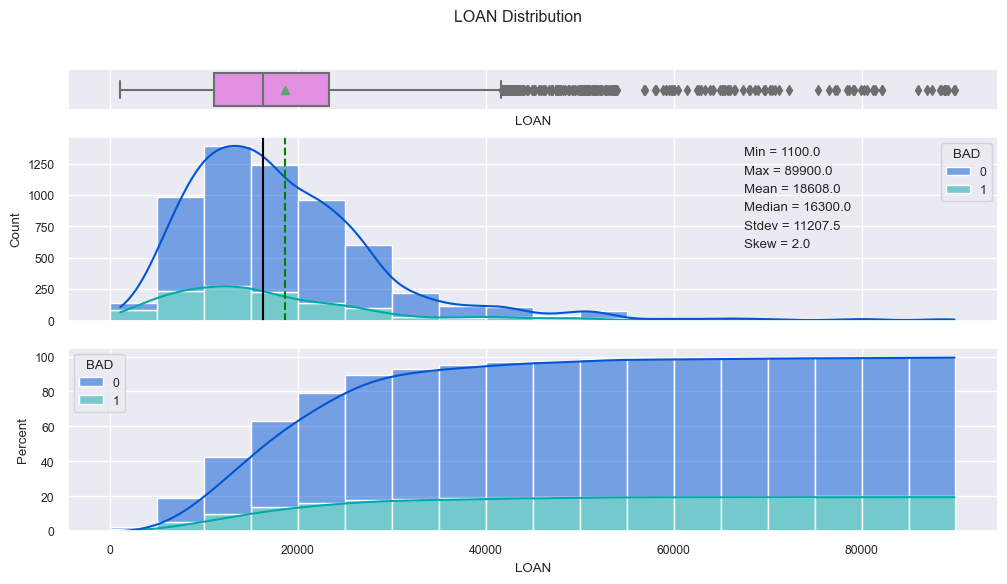

In [32]:
# Plot Distribution
loan_dist.plot_hist()

In [33]:
loan_dist.get_data()

counter                        counter_pct_total            \
BAD                  0    1 total total_cumul                 0         1   
LOAN_bucket                                                                 
[0, 5000)           61   83   144         144          0.010235  0.013926   
[5000, 10000)      747  239   986        1130          0.125336  0.040101   
[10000, 15000)    1114  273  1387        2517          0.186913  0.045805   
[15000, 20000)    1012  228  1240        3757          0.169799  0.038255   
[20000, 25000)     819  140   959        4716          0.137416  0.023490   
[25000, 30000)     503  100   603        5319          0.084396  0.016779   
[30000, 35000)     189   32   221        5540          0.031711  0.005369   
[35000, 40000)      92   24   116        5656          0.015436  0.004027   
[40000, 45000)      82   29   111        5767          0.013758  0.004866   
[45000, 50000)      29   11    40        5807          0.004866  0.001846   
[50000, 55000)      59   20    79        5886          0.009899  0.003356   
[55000, 60000)       9    1    10        5896          0.001510  0.000168   
[60000, 65000)       9    3    12        5908          0.001510  0.000503   
[65000, 70000)      17    1    18        5926          0.002852  0.000168   
[70000, 75000)       4    1     5        5931          0.000671  0.000168   
[75000, 80000)       6    4    10        5941          0.001007  0.000671   
[80000, 85000)       7    0     7        5948          0.001174  0.000000   
[85000, 90000)      12    0    12        5960          0.002013  0.000000   

                                                defaults  \
BAD                total total_cumul default_total_cumul   
LOAN_bucket                                                
[0, 5000)       0.024161    0.024161                  83   
[5000, 10000)   0.165436    0.189597                 322   
[10000, 15000)  0.232718    0.422315                 595   
[15000, 20000)  0.208054    0.630369                 823   
[20000, 25000)  0.160906    0.791275                 963   
[25000, 30000)  0.101174    0.892450                1063   
[30000, 35000)  0.037081    0.929530                1095   
[35000, 40000)  0.019463    0.948993                1119   
[40000, 45000)  0.018624    0.967617                1148   
[45000, 50000)  0.006711    0.974329                1159   
[50000, 55000)  0.013255    0.987584                1179   
[55000, 60000)  0.001678    0.989262                1180   
[60000, 65000)  0.002013    0.991275                1183   
[65000, 70000)  0.003020    0.994295                1184   
[70000, 75000)  0.000839    0.995134                1185   
[75000, 80000)  0.001678    0.996812                1189   
[80000, 85000)  0.001174    0.997987                1189   
[85000, 90000)  0.002013    1.000000                1189   

                                                               \
BAD            default_rate_within_bucket pct_of_all_defaults   
LOAN_bucket                                                     
[0, 5000)                        0.576389            0.069807   
[5000, 10000)                    0.242394            0.201009   
[10000, 15000)                   0.196828            0.229605   
[15000, 20000)                   0.183871            0.191758   
[20000, 25000)                   0.145985            0.117746   
[25000, 30000)                   0.165837            0.084104   
[30000, 35000)                   0.144796            0.026913   
[35000, 40000)                   0.206897            0.020185   
[40000, 45000)                   0.261261            0.024390   
[45000, 50000)                   0.275000            0.009251   
[50000, 55000)                   0.253165            0.016821   
[55000, 60000)                   0.100000            0.000841   
[60000, 65000)                   0.250000            0.002523   
[65000, 70000)                   0.055556            0.000841   
[70000, 75000)                 

BAD             counter  default_rate_within_bucket  pct_of_all_defaults
LOAN_bucket                                                             
[0, 5000)            83                    0.576389             0.069807
[5000, 10000)       239                    0.242394             0.201009
[10000, 15000)      273                    0.196828             0.229605
[15000, 20000)      228                    0.183871             0.191758
[20000, 25000)      140                    0.145985             0.117746
[25000, 30000)      100                    0.165837             0.084104
[30000, 35000)       32                    0.144796             0.026913
[35000, 40000)       24                    0.206897             0.020185
[40000, 45000)       29                    0.261261             0.024390
[45000, 50000)       11                    0.275000             0.009251
[50000, 55000)       20                    0.253165             0.016821
[55000, 60000)        1                    0.100000             0.000841
[60000, 65000)        3                    0.250000             0.002523
[65000, 70000)        1                    0.055556             0.000841
[70000, 75000)        1                    0.200000             0.000841
[75000, 80000)        4                    0.400000             0.003364
[80000, 85000)        0                    0.000000             0.000000
[85000, 90000)        0                    0.000000             0.000000

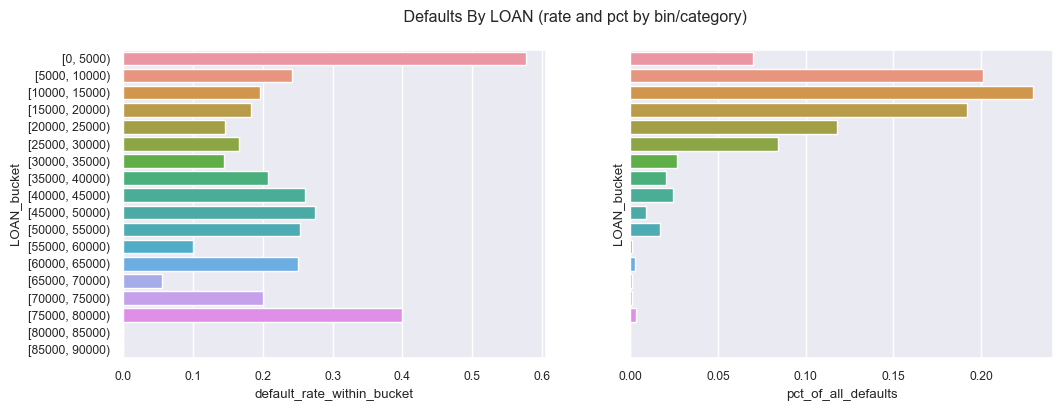

In [34]:
loan_dist.plot_defaults()

Observations

* Loan value varies from 1,100 to 89,900, with a mean of 18.6k, a median of 16.3k and a standard deviation of 11.2k
* Distribution is quite smooth with a positive skew
* About 90% of loans are under 30k, and ~95% under 40k. The remaining 5% form a long queue of outliers (explaining the skew)
* The overall default rate for the whole dataset is very close to <strong> 20% </strong> (1189/5960)
* The highest default rates are concentrated among very small loans (<5k) and loans >40-45k. 
* Default rate for loans 2.5k is about 85%, suggesting the underlying applicants may be very stretched and use home equity loans as a lifeline in that cases.

#### <font color="#3498DB"><strong>MORTDUE </strong>(Mortgage Due)</font>

In [35]:
# Instantiate dist object
mort_bins1 = [i*25000 for i in range(0,17)]

mort_dist = FeatureDistAnalyzer(d1, 'MORTDUE', bins=mort_bins1)

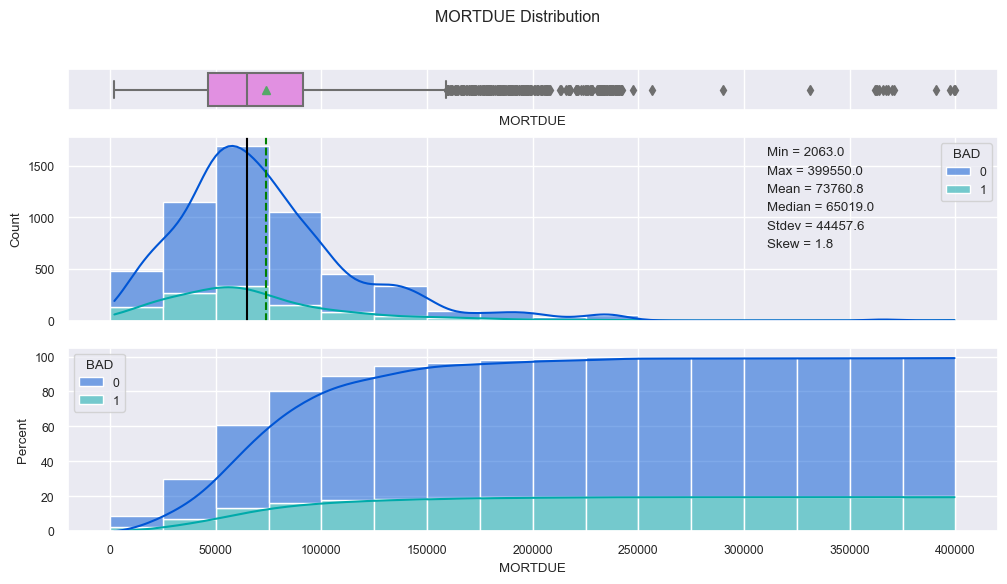

In [36]:
# Plot Distribution
mort_dist.plot_hist()

In [37]:
mort_dist.get_data()

counter                        counter_pct_total            \
BAD                    0    1 total total_cumul                 0         1   
MORTDUE_bucket                                                                
[0, 25000)           352  128   480         480          0.064682  0.023521   
[25000, 50000)       883  267  1150        1630          0.162257  0.049063   
[50000, 75000)      1350  339  1689        3319          0.248071  0.062293   
[75000, 100000)      898  155  1053        4372          0.165013  0.028482   
[100000, 125000)     362   87   449        4821          0.066520  0.015987   
[125000, 150000)     294   41   335        5156          0.054024  0.007534   
[150000, 175000)      68   28    96        5252          0.012495  0.005145   
[175000, 200000)      66   16    82        5334          0.012128  0.002940   
[200000, 225000)      29    9    38        5372          0.005329  0.001654   
[225000, 250000)      48    6    54        5426          0.008820  0.001103   
[250000, 275000)       0    1     1        5427          0.000000  0.000184   
[275000, 300000)       0    1     1        5428          0.000000  0.000184   
[300000, 325000)       0    0     0        5428          0.000000  0.000000   
[325000, 350000)       0    1     1        5429          0.000000  0.000184   
[350000, 375000)       9    0     9        5438          0.001654  0.000000   
[375000, 400000)       0    4     4        5442          0.000000  0.000735   

                                                  defaults  \
BAD                  total total_cumul default_total_cumul   
MORTDUE_bucket                                               
[0, 25000)        0.088203    0.088203                 128   
[25000, 50000)    0.211319    0.299522                 395   
[50000, 75000)    0.310364    0.609886                 734   
[75000, 100000)   0.193495    0.803381                 889   
[100000, 125000)  0.082506    0.885888                 976   
[125000, 150000)  0.061558    0.947446                1017   
[150000, 175000)  0.017641    0.965086                1045   
[175000, 200000)  0.015068    0.980154                1061   
[200000, 225000)  0.006983    0.987137                1070   
[225000, 250000)  0.009923    0.997060                1076   
[250000, 275000)  0.000184    0.997244                1077   
[275000, 300000)  0.000184    0.997427                1078   
[300000, 325000)  0.000000    0.997427                1078   
[325000, 350000)  0.000184    0.997611                1079   
[350000, 375000)  0.001654    0.999265                1079   
[375000, 400000)  0.000735    1.000000                1083   

                                                                 \
BAD              default_rate_within_bucket pct_of_all_defaults   
MORTDUE_bucket                                                    
[0, 25000)                         0.266667            0.118190   
[25000, 50000)                     0.232174            0.246537   
[50000, 75000)                     0.200710            0.313019   
[75000, 100000)                    0.147198            0.143121   
[100000, 125000)                   0.193764            0.080332   
[125000, 150000)                   0.122388            0.037858   
[150000, 175000)                   0.291667            0.025854   
[175000, 200000)                   0.195122            0.014774   
[200000, 225000)                   0.236842            0.008310   
[225000, 250000)                   0.111111            0.005540   
[250000, 275000)                   1.000000            0.000923   
[275000, 300000)                   1.000000            0.000923   
[300000, 325000)                        NaN            0.000000   
[325000, 350000)                   1.000000            0.000923   
[350000, 375000)                   0.000000            0.000000   
[375000, 400000)                   1.000000            0.003693   

                                            
BAD              

BAD               counter  default_rate_within_bucket  pct_of_all_defaults
MORTDUE_bucket                                                            
[0, 25000)            128                    0.266667             0.118190
[25000, 50000)        267                    0.232174             0.246537
[50000, 75000)        339                    0.200710             0.313019
[75000, 100000)       155                    0.147198             0.143121
[100000, 125000)       87                    0.193764             0.080332
[125000, 150000)       41                    0.122388             0.037858
[150000, 175000)       28                    0.291667             0.025854
[175000, 200000)       16                    0.195122             0.014774
[200000, 225000)        9                    0.236842             0.008310
[225000, 250000)        6                    0.111111             0.005540
[250000, 275000)        1                    1.000000             0.000923
[275000, 300000)        1                    1.000000             0.000923
[300000, 325000)        0                         NaN             0.000000
[325000, 350000)        1                    1.000000             0.000923
[350000, 375000)        0                    0.000000             0.000000
[375000, 400000)        4                    1.000000             0.003693

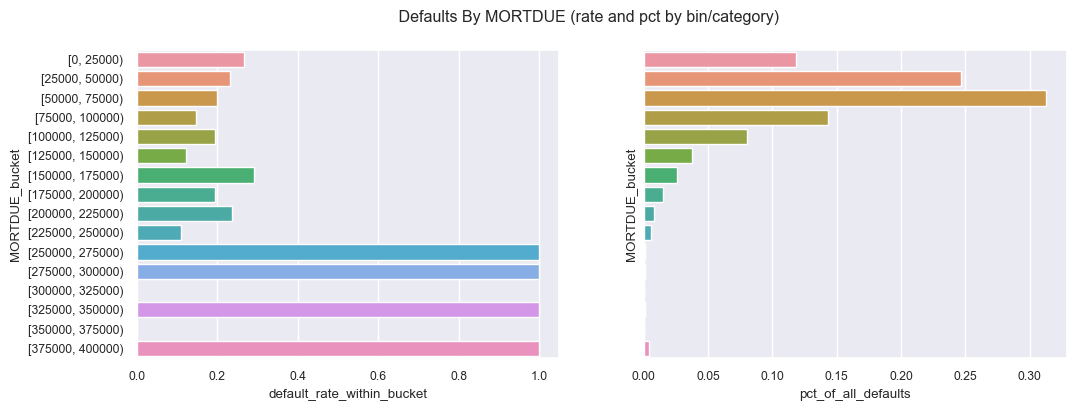

In [38]:
mort_dist.plot_defaults()

Observations

* Mortgage due varies from 2.1k to 399.6k, with a mean of 73.8k, a median of 65.0k and a standard deviation of 44.4k
* Distribution is quite smooth and also presents a positive skew (similar to loan distribution)
* About 95% of loans relate to properties with a mortgage due under 150k. Again, the remaining 5% form a long queue of outliers (explaining the skew)
* The default rate profile is a bit different from the loan factor - default rates are more uniform in that case, excluding a few outliers within the right tail (very few occurences)
* This might suggest that MORTDUE has less explanatory power than the loan amount

#### <font color="#3498DB"><strong>VALUE </strong>(of the Property)</font>

In [39]:
# Instantiate dist object
value_bins1 = [i*50000 for i in range(0,165)]
value_bins2 = [i*25000 for i in range(0,12)] + [i*100000 for i in range(3,10)] # blocks of 25k until 300k, 100k afterwards

value_dist = FeatureDistAnalyzer(d1, 'VALUE', bins=value_bins2)

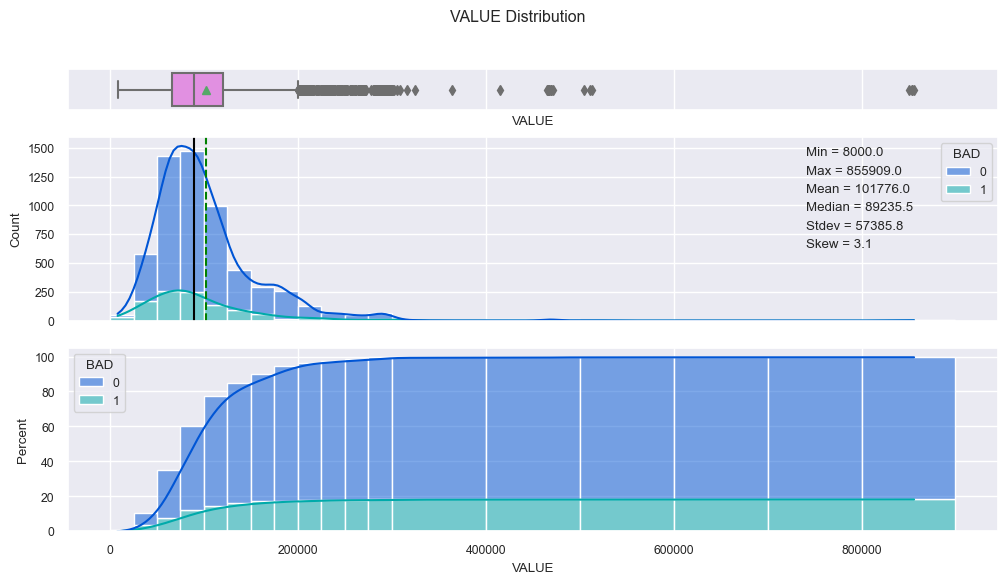

In [40]:
value_dist.plot_hist()

In [41]:
value_dist.get_data()

counter                        counter_pct_total            \
BAD                    0    1 total total_cumul                 0         1   
VALUE_bucket                                                                  
[0, 25000)            18   29    47          47          0.003078  0.004959   
[25000, 50000)       410  167   577         624          0.070109  0.028557   
[50000, 75000)      1175  257  1432        2056          0.200923  0.043947   
[75000, 100000)     1225  252  1477        3533          0.209473  0.043092   
[100000, 125000)     855  138   993        4526          0.146204  0.023598   
[125000, 150000)     345   93   438        4964          0.058995  0.015903   
[150000, 175000)     234   61   295        5259          0.040014  0.010431   
[175000, 200000)     240   18   258        5517          0.041040  0.003078   
[200000, 225000)     106   25   131        5648          0.018126  0.004275   
[225000, 250000)      49   17    66        5714          0.008379  0.002907   
[250000, 275000)      42    3    45        5759          0.007182  0.000513   
[275000, 300000)      55   10    65        5824          0.009405  0.001710   
[300000, 400000)       1    6     7        5831          0.000171  0.001026   
[400000, 500000)       9    1    10        5841          0.001539  0.000171   
[500000, 600000)       0    3     3        5844          0.000000  0.000513   
[600000, 700000)       0    0     0        5844          0.000000  0.000000   
[700000, 800000)       0    0     0        5844          0.000000  0.000000   
[800000, 900000)       0    4     4        5848          0.000000  0.000684   

                                                  defaults  \
BAD                  total total_cumul default_total_cumul   
VALUE_bucket                                                 
[0, 25000)        0.008037    0.008037                  29   
[25000, 50000)    0.098666    0.106703                 196   
[50000, 75000)    0.244870    0.351573                 453   
[75000, 100000)   0.252565    0.604138                 705   
[100000, 125000)  0.169802    0.773940                 843   
[125000, 150000)  0.074897    0.848837                 936   
[150000, 175000)  0.050445    0.899282                 997   
[175000, 200000)  0.044118    0.943399                1015   
[200000, 225000)  0.022401    0.965800                1040   
[225000, 250000)  0.011286    0.977086                1057   
[250000, 275000)  0.007695    0.984781                1060   
[275000, 300000)  0.011115    0.995896                1070   
[300000, 400000)  0.001197    0.997093                1076   
[400000, 500000)  0.001710    0.998803                1077   
[500000, 600000)  0.000513    0.999316                1080   
[600000, 700000)  0.000000    0.999316                1080   
[700000, 800000)  0.000000    0.999316                1080   
[800000, 900000)  0.000684    1.000000                1084   

                                                                 \
BAD              default_rate_within_bucket pct_of_all_defaults   
VALUE_bucket                                                      
[0, 25000)                         0.617021            0.026753   
[25000, 50000)                     0.289428            0.154059   
[50000, 75000)                     0.179469            0.237085   
[75000, 100000)                    0.170616            0.232472   
[100000, 125000)                   0.138973            0.127306   
[125000, 150000)                   0.212329            0.085793   
[150000, 175000)                   0.206780            0.056273   
[175000, 200000)                   0.069767            0.016605   
[200000, 225000)                   0.190840            0.023063   
[225000, 250000)                   0.257576            0.015683   
[250000, 275000)                   0.066667            0.002768   
[275000, 300000)                   0.153846            0.009225   
[300000, 400000)                   0.857143      

BAD               counter  default_rate_within_bucket  pct_of_all_defaults
VALUE_bucket                                                              
[0, 25000)             29                    0.617021             0.026753
[25000, 50000)        167                    0.289428             0.154059
[50000, 75000)        257                    0.179469             0.237085
[75000, 100000)       252                    0.170616             0.232472
[100000, 125000)      138                    0.138973             0.127306
[125000, 150000)       93                    0.212329             0.085793
[150000, 175000)       61                    0.206780             0.056273
[175000, 200000)       18                    0.069767             0.016605
[200000, 225000)       25                    0.190840             0.023063
[225000, 250000)       17                    0.257576             0.015683
[250000, 275000)        3                    0.066667             0.002768
[275000, 300000)       10                    0.153846             0.009225
[300000, 400000)        6                    0.857143             0.005535
[400000, 500000)        1                    0.100000             0.000923
[500000, 600000)        3                    1.000000             0.002768
[600000, 700000)        0                         NaN             0.000000
[700000, 800000)        0                         NaN             0.000000
[800000, 900000)        4                    1.000000             0.003690

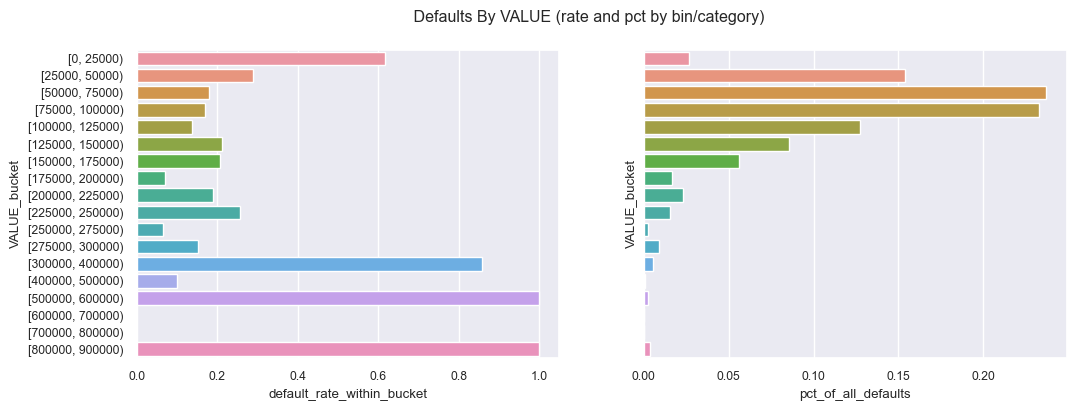

In [42]:
value_dist.plot_defaults()

Observations

* Property Value ranges from 8k to 856k, with a mean of 101k, a median of 89k and a standard deviation of 57k
* 77% of properties are worth less than 125k, 94% less than 200k 
* Distribution is bell-shaped, with a significant positive skew (tail of more expensive properties) 
* The highest default rates occur for cheap properties (default rate is more than 60% when proprwty value is <25k) and the most expensive ones (default rate is close to 100% above 300k, although this is a very small portion of defaults)

#### <font color="#3498DB"><strong>YOJ </strong>(Year On Job)</font>

In [43]:
# Instantiate dist object
yoj_bins1 = [i*3 for i in range(0,15)]

yoj_dist = FeatureDistAnalyzer(d1, 'YOJ', bins=yoj_bins1)

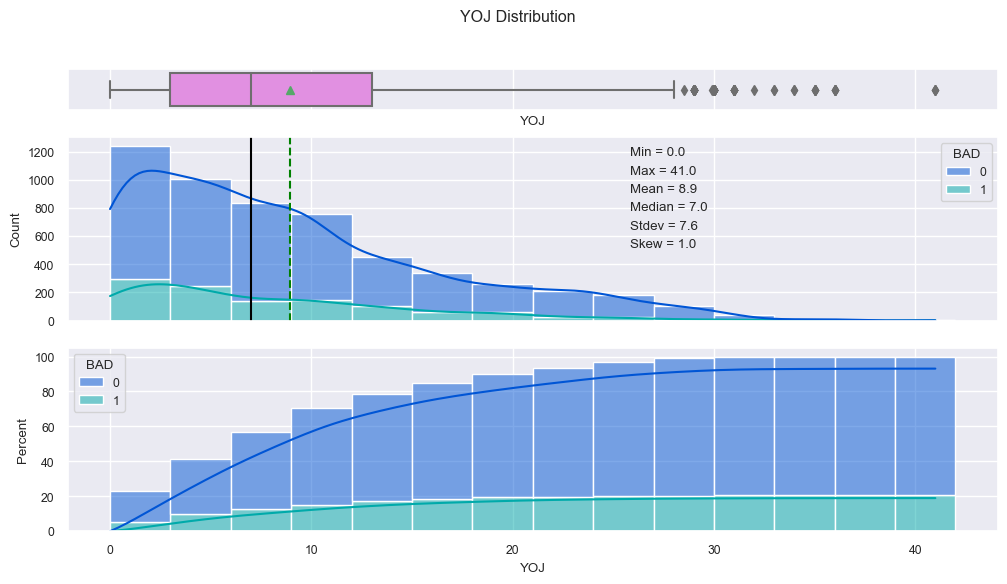

In [44]:
yoj_dist.plot_hist()

In [45]:
yoj_dist.get_data()

counter                        counter_pct_total            \
BAD              0    1 total total_cumul                 0         1   
YOJ_bucket                                                              
[0, 3)         942  299  1241        1241          0.173003  0.054913   
[3, 6)         763  244  1007        2248          0.140129  0.044812   
[6, 9)         698  138   836        3084          0.128191  0.025344   
[9, 12)        612  146   758        3842          0.112397  0.026814   
[12, 15)       348  102   450        4292          0.063912  0.018733   
[15, 18)       275   64   339        4631          0.050505  0.011754   
[18, 21)       196   61   257        4888          0.035996  0.011203   
[21, 24)       189   25   214        5102          0.034711  0.004591   
[24, 27)       155   25   180        5282          0.028466  0.004591   
[27, 30)        96    7   103        5385          0.017631  0.001286   
[30, 33)        36    7    43        5428          0.006612  0.001286   
[33, 36)         6    3     9        5437          0.001102  0.000551   
[36, 39)         5    0     5        5442          0.000918  0.000000   
[39, 42)         0    3     3        5445          0.000000  0.000551   

                                            defaults  \
BAD            total total_cumul default_total_cumul   
YOJ_bucket                                             
[0, 3)      0.227916    0.227916                 299   
[3, 6)      0.184940    0.412856                 543   
[6, 9)      0.153535    0.566391                 681   
[9, 12)     0.139210    0.705601                 827   
[12, 15)    0.082645    0.788246                 929   
[15, 18)    0.062259    0.850505                 993   
[18, 21)    0.047199    0.897704                1054   
[21, 24)    0.039302    0.937006                1079   
[24, 27)    0.033058    0.970064                1104   
[27, 30)    0.018916    0.988981                1111   
[30, 33)    0.007897    0.996878                1118   
[33, 36)    0.001653    0.998531                1121   
[36, 39)    0.000918    0.999449                1121   
[39, 42)    0.000551    1.000000                1124   

                                                           \
BAD        default_rate_within_bucket pct_of_all_defaults   
YOJ_bucket                                                  
[0, 3)                       0.240935            0.266014   
[3, 6)                       0.242304            0.217082   
[6, 9)                       0.165072            0.122776   
[9, 12)                      0.192612            0.129893   
[12, 15)                     0.226667            0.090747   
[15, 18)                     0.188791            0.056940   
[18, 21)                     0.237354            0.054270   
[21, 24)                     0.116822            0.022242   
[24, 27)                     0.138889            0.022242   
[27, 30)                     0.067961            0.006228   
[30, 33)                     0.162791            0.006228   
[33, 36)                     0.333333            0.002669   
[36, 39)                     0.000000            0.000000   
[39, 42)                     1.000000            0.002669   

                                      
BAD        pct_of_all_defaults_cumul  
YOJ_bucket                            
[0, 3)                      0.266014  
[3, 6)                      0.483096  
[6, 9)                      0.605872  
[9, 12)                     0.735765  
[12, 15)                    0.826512  
[15, 18)                    0.883452  
[18, 21)                    0.937722  
[21, 24)                    0.959964  
[24, 27)                    0.982206  
[27, 30)                    0.988434  
[30, 33)                    0.994662  
[33, 36)                    0.997331  
[36, 39)                    0.997331  
[39, 42)                    1.000000

BAD         counter  default_rate_within_bucket  pct_of_all_defaults
YOJ_bucket                                                          
[0, 3)          299                    0.240935             0.266014
[3, 6)          244                    0.242304             0.217082
[6, 9)          138                    0.165072             0.122776
[9, 12)         146                    0.192612             0.129893
[12, 15)        102                    0.226667             0.090747
[15, 18)         64                    0.188791             0.056940
[18, 21)         61                    0.237354             0.054270
[21, 24)         25                    0.116822             0.022242
[24, 27)         25                    0.138889             0.022242
[27, 30)          7                    0.067961             0.006228
[30, 33)          7                    0.162791             0.006228
[33, 36)          3                    0.333333             0.002669
[36, 39)          0                    0.000000             0.000000
[39, 42)          3                    1.000000             0.002669

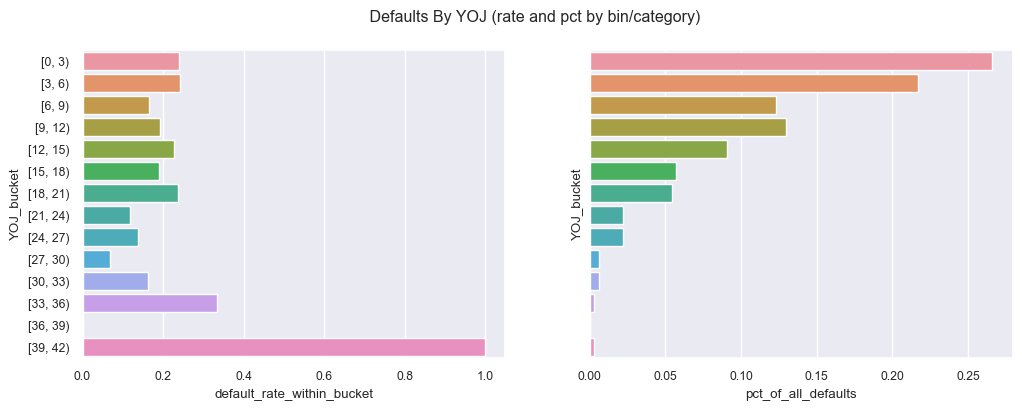

In [46]:
yoj_dist.plot_defaults()

Observations

* Year on Job varies from 0 to 41y, with a mean of 8.9y, a median of 7.0y and a standard deviation of 7.6y
* Distribution is well-behaved and looks exponential 
* The default rate profile is quite uniform (few outliers in the right tail again), which suggests that YOJ might ot have much explanatory power on its own 

#### <font color="#3498DB"><strong>DEROG </strong>(No. Derogatory Reports)</font>

In [47]:
# Instantiate dist object
derog_bins1 = [i*1 for i in range(0,12)]
derog_bins2 = [0, 1, 12]

derog_dist = FeatureDistAnalyzer(d1, 'DEROG', bins=derog_bins1)

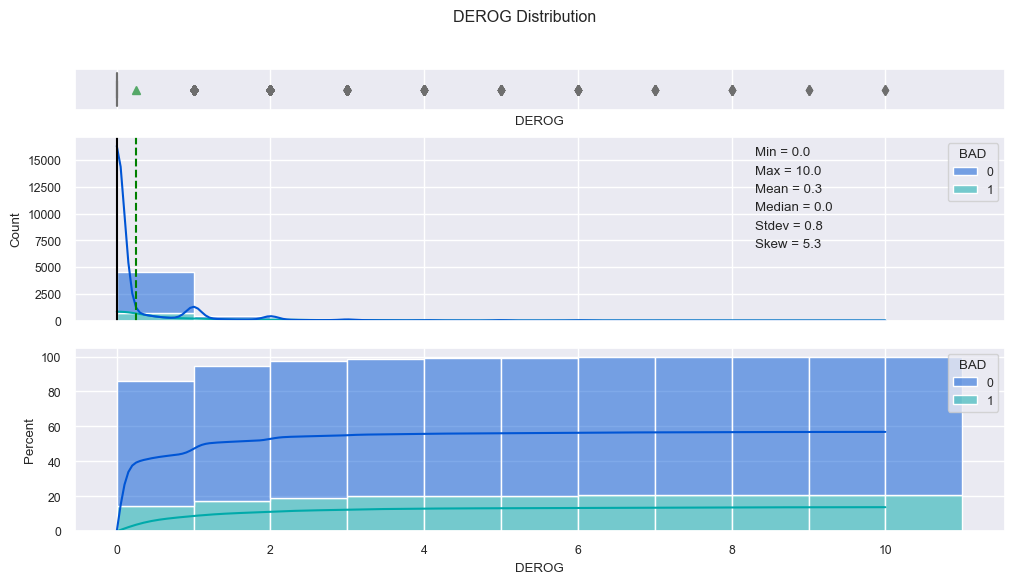

In [48]:
derog_dist.plot_hist()

In [49]:
derog_dist.get_data()

counter                        counter_pct_total            \
BAD                0    1 total total_cumul                 0         1   
DEROG_bucket                                                              
[0, 1)          3773  754  4527        4527          0.718393  0.143564   
[1, 2)           266  169   435        4962          0.050647  0.032178   
[2, 3)            78   82   160        5122          0.014851  0.015613   
[3, 4)            15   43    58        5180          0.002856  0.008187   
[4, 5)             5   18    23        5203          0.000952  0.003427   
[5, 6)             8    7    15        5218          0.001523  0.001333   
[6, 7)             5   10    15        5233          0.000952  0.001904   
[7, 8)             0    8     8        5241          0.000000  0.001523   
[8, 9)             0    6     6        5247          0.000000  0.001142   
[9, 10)            0    3     3        5250          0.000000  0.000571   
[10, 11)           0    2     2        5252          0.000000  0.000381   

                                              defaults  \
BAD              total total_cumul default_total_cumul   
DEROG_bucket                                             
[0, 1)        0.861957    0.861957                 754   
[1, 2)        0.082826    0.944783                 923   
[2, 3)        0.030465    0.975248                1005   
[3, 4)        0.011043    0.986291                1048   
[4, 5)        0.004379    0.990670                1066   
[5, 6)        0.002856    0.993526                1073   
[6, 7)        0.002856    0.996382                1083   
[7, 8)        0.001523    0.997906                1091   
[8, 9)        0.001142    0.999048                1097   
[9, 10)       0.000571    0.999619                1100   
[10, 11)      0.000381    1.000000                1102   

                                                             \
BAD          default_rate_within_bucket pct_of_all_defaults   
DEROG_bucket                                                  
[0, 1)                         0.166556            0.684211   
[1, 2)                         0.388506            0.153358   
[2, 3)                         0.512500            0.074410   
[3, 4)                         0.741379            0.039020   
[4, 5)                         0.782609            0.016334   
[5, 6)                         0.466667            0.006352   
[6, 7)                         0.666667            0.009074   
[7, 8)                         1.000000            0.007260   
[8, 9)                         1.000000            0.005445   
[9, 10)                        1.000000            0.002722   
[10, 11)                       1.000000            0.001815   

                                        
BAD          pct_of_all_defaults_cumul  
DEROG_bucket                            
[0, 1)                        0.684211  
[1, 2)                        0.837568  
[2, 3)                        0.911978  
[3, 4)                        0.950998  
[4, 5)                        0.967332  
[5, 6)                        0.973684  
[6, 7)                        0.982759  
[7, 8)                        0.990018  
[8, 9)                        0.995463  
[9, 10)                       0.998185  
[10, 11)                      1.000000

BAD           counter  default_rate_within_bucket  pct_of_all_defaults
DEROG_bucket                                                          
[0, 1)            754                    0.166556             0.684211
[1, 2)            169                    0.388506             0.153358
[2, 3)             82                    0.512500             0.074410
[3, 4)             43                    0.741379             0.039020
[4, 5)             18                    0.782609             0.016334
[5, 6)              7                    0.466667             0.006352
[6, 7)             10                    0.666667             0.009074
[7, 8)              8                    1.000000             0.007260
[8, 9)              6                    1.000000             0.005445
[9, 10)             3                    1.000000             0.002722
[10, 11)            2                    1.000000             0.001815

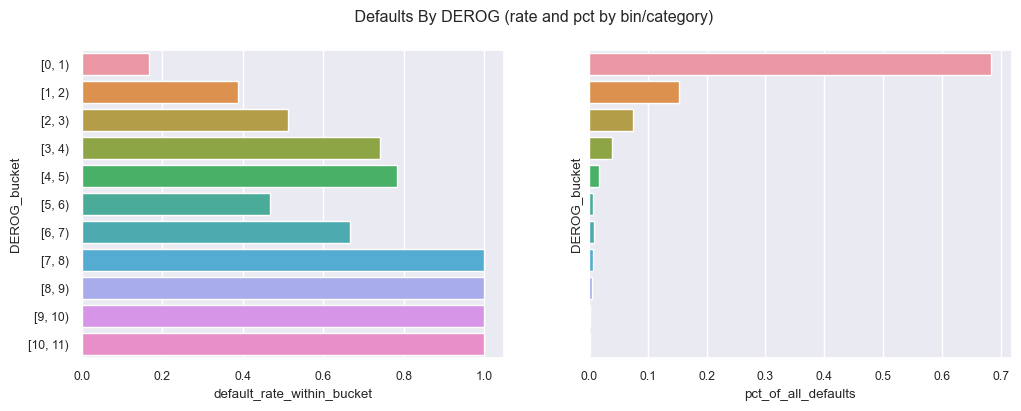

In [50]:
derog_dist.plot_defaults()

In [51]:
derog_dist.default_rate

0.20982482863670981

Observations

* The number of derogatory reports varies from 0 to 10, with a mean of 0.3, a median of 0 and a standard deviation of 0.8
* An overwhelming proportion of borrowers (86%) have NO derogatory report. 94% have less than 1 and 97.5% less than 2.  
* Note that 12% of data points are missing here. It is tempting to assume that missing data implies no derogatory report in that case (presumably it would have been populated if any).
* The overall default rate within populated data points is 21% (slightly higher than the 20% global average)
* The default rate profile is interesting here, in that there seems to be an overall positive relationship between the number of reports and default rate 

#### <font color="#3498DB"><strong>CLNO </strong>(No. existing Credit Lines)</font>

In [52]:
# Instantiate distrib object
clno_bins1 = [i*5 for i in range(0,16)]
clno_bins2 = [i*4 for i in range(0,19)]

clno_dist = FeatureDistAnalyzer(d1, 'CLNO', bins=clno_bins2)

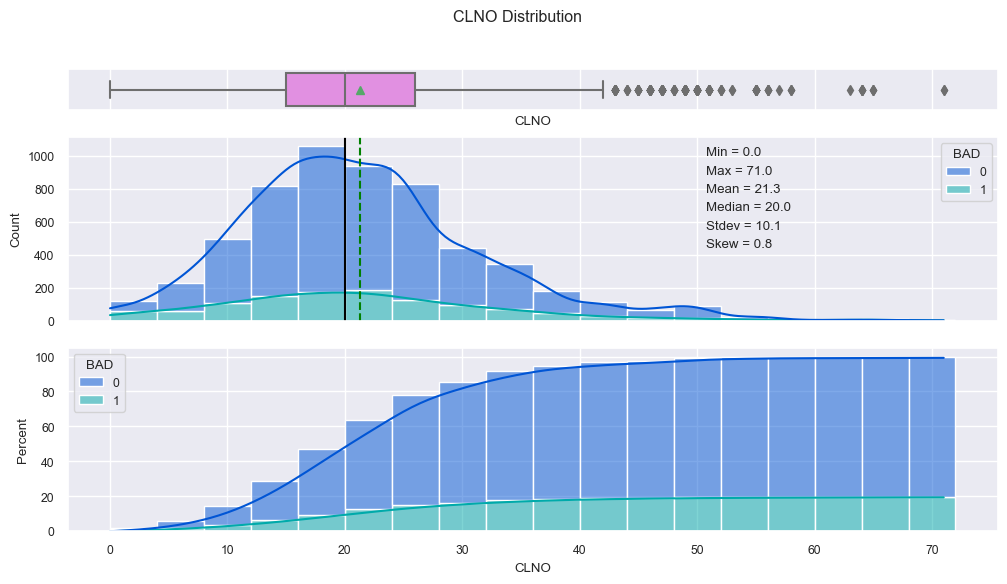

In [53]:
clno_dist.plot_hist()

In [54]:
clno_dist.get_data()

counter                        counter_pct_total            \
BAD               0    1 total total_cumul                 0         1   
CLNO_bucket                                                              
[0, 4)           59   58   117         117          0.010282  0.010108   
[4, 8)          169   56   225         342          0.029453  0.009759   
[8, 12)         389  105   494         836          0.067794  0.018299   
[12, 16)        663  152   815        1651          0.115545  0.026490   
[16, 20)        885  173  1058        2709          0.154235  0.030150   
[20, 24)        754  183   937        3646          0.131405  0.031893   
[24, 28)        706  124   830        4476          0.123039  0.021610   
[28, 32)        346   92   438        4914          0.060300  0.016033   
[32, 36)        269   71   340        5254          0.046880  0.012374   
[36, 40)        135   44   179        5433          0.023527  0.007668   
[40, 44)         82   28   110        5543          0.014291  0.004880   
[44, 48)         47   17    64        5607          0.008191  0.002963   
[48, 52)         75   14    89        5696          0.013071  0.002440   
[52, 56)         17    4    21        5717          0.002963  0.000697   
[56, 60)          6    4    10        5727          0.001046  0.000697   
[60, 64)          0    1     1        5728          0.000000  0.000174   
[64, 68)          0    8     8        5736          0.000000  0.001394   
[68, 72)          0    2     2        5738          0.000000  0.000349   

                                             defaults  \
BAD             total total_cumul default_total_cumul   
CLNO_bucket                                             
[0, 4)       0.020390    0.020390                  58   
[4, 8)       0.039212    0.059603                 114   
[8, 12)      0.086093    0.145695                 219   
[12, 16)     0.142036    0.287731                 371   
[16, 20)     0.184385    0.472116                 544   
[20, 24)     0.163297    0.635413                 727   
[24, 28)     0.144650    0.780063                 851   
[28, 32)     0.076333    0.856396                 943   
[32, 36)     0.059254    0.915650                1014   
[36, 40)     0.031196    0.946846                1058   
[40, 44)     0.019170    0.966016                1086   
[44, 48)     0.011154    0.977170                1103   
[48, 52)     0.015511    0.992680                1117   
[52, 56)     0.003660    0.996340                1121   
[56, 60)     0.001743    0.998083                1125   
[60, 64)     0.000174    0.998257                1126   
[64, 68)     0.001394    0.999651                1134   
[68, 72)     0.000349    1.000000                1136   

                                                            \
BAD         default_rate_within_bucket pct_of_all_defaults   
CLNO_bucket                                                  
[0, 4)                        0.495726            0.051056   
[4, 8)                        0.248889            0.049296   
[8, 12)                       0.212551            0.092430   
[12, 16)                      0.186503            0.133803   
[16, 20)                      0.163516            0.152289   
[20, 24)                      0.195304            0.161092   
[24, 28)                      0.149398            0.109155   
[28, 32)                      0.210046            0.080986   
[32, 36)                      0.208824            0.062500   
[36, 40)                      0.245810            0.038732   
[40, 44)                      0.254545            0.024648   
[44, 48)                      0.265625            0.014965   
[48, 52)                      0.157303            0.012324   
[52, 56)                      0.190476            0.003521   
[56, 60)                      0.400000            0.003521   
[60, 64)                      1.000000            0.000880   
[64, 68)                      1.000000            0.007042   
[68, 72)           

BAD          counter  default_rate_within_bucket  pct_of_all_defaults
CLNO_bucket                                                          
[0, 4)            58                    0.495726             0.051056
[4, 8)            56                    0.248889             0.049296
[8, 12)          105                    0.212551             0.092430
[12, 16)         152                    0.186503             0.133803
[16, 20)         173                    0.163516             0.152289
[20, 24)         183                    0.195304             0.161092
[24, 28)         124                    0.149398             0.109155
[28, 32)          92                    0.210046             0.080986
[32, 36)          71                    0.208824             0.062500
[36, 40)          44                    0.245810             0.038732
[40, 44)          28                    0.254545             0.024648
[44, 48)          17                    0.265625             0.014965
[48, 52)          14                    0.157303             0.012324
[52, 56)           4                    0.190476             0.003521
[56, 60)           4                    0.400000             0.003521
[60, 64)           1                    1.000000             0.000880
[64, 68)           8                    1.000000             0.007042
[68, 72)           2                    1.000000             0.001761

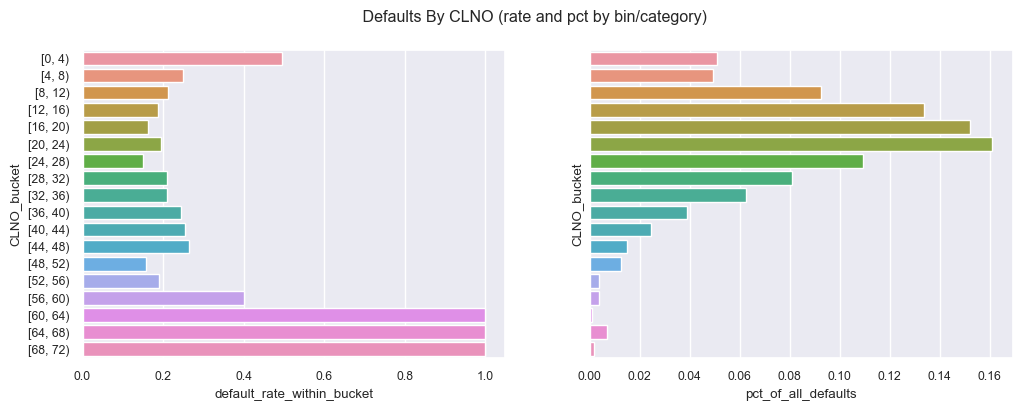

In [55]:
clno_dist.plot_defaults()


In [56]:
clno_dist.default_rate

0.1979783896828163

Observations

* The number of credit lines per borrower varies from 0 to 71, with a mean of 21.3, a median of 20.0 and a standard deviation of 10.1
* The distribution is bell-shaped with a slight positive skew 
* The mean and average feel quite high - indicates that borrowers are familiar / comfortable with credit in general  
* About 5% of borrowers have 45 or more credit lines 
* Note that ~4% of data points are missing here but the average default rate is very close to the global average of 20%
* Default rates: 2 high-risk groups emerge here - borrowers with very few credit lines, and borrowers with a lot of credit lines. The distribution is quite uniform in between.
    * Borrowers with NO credit lines have a 40% default rate, and borrowers with less than 3 have a 50% default rate on average. This is very high and may seem suprising at first but it could indicate that those borrowers are in the process of increasing their debt to income ratio and <i>must</i> open a new credit line.
    * Borrowers with a very high number of credit lines (>=60) have a 100% default rate but represent less than 1% of all defaults.

#### <font color="#3498DB"><strong>DELINQ </strong>(No. Deliquent Credit Lines)</font>

In [57]:
# Instantiate distrib object
delinq_bins1 = [i*1 for i in range(0,17)]

delinq_dist = FeatureDistAnalyzer(d1, 'DELINQ', bins=delinq_bins1)

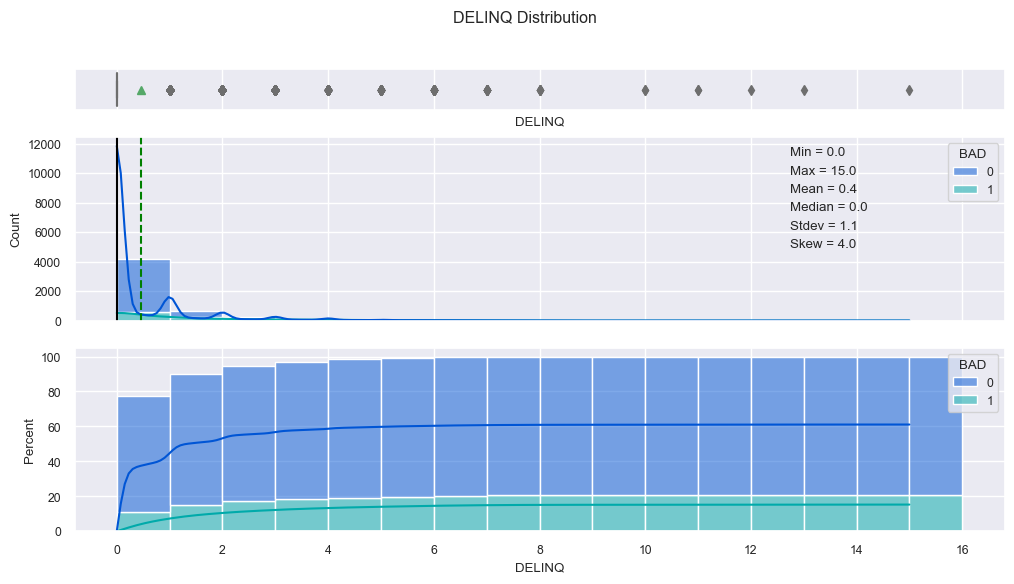

In [58]:
delinq_dist.plot_hist()

In [59]:
delinq_dist.get_data()

counter                        counter_pct_total            \
BAD                 0    1 total total_cumul                 0         1   
DELINQ_bucket                                                              
[0, 1)           3596  583  4179        4179          0.668401  0.108364   
[1, 2)            432  222   654        4833          0.080297  0.041264   
[2, 3)            138  112   250        5083          0.025651  0.020818   
[3, 4)             58   71   129        5212          0.010781  0.013197   
[4, 5)             32   46    78        5290          0.005948  0.008550   
[5, 6)              7   31    38        5328          0.001301  0.005762   
[6, 7)              0   27    27        5355          0.000000  0.005019   
[7, 8)              0   13    13        5368          0.000000  0.002416   
[8, 9)              0    5     5        5373          0.000000  0.000929   
[9, 10)             0    0     0        5373          0.000000  0.000000   
[10, 11)            0    2     2        5375          0.000000  0.000372   
[11, 12)            0    2     2        5377          0.000000  0.000372   
[12, 13)            0    1     1        5378          0.000000  0.000186   
[13, 14)            0    1     1        5379          0.000000  0.000186   
[14, 15)            0    0     0        5379          0.000000  0.000000   
[15, 16)            0    1     1        5380          0.000000  0.000186   

                                               defaults  \
BAD               total total_cumul default_total_cumul   
DELINQ_bucket                                             
[0, 1)         0.776766    0.776766                 583   
[1, 2)         0.121561    0.898327                 805   
[2, 3)         0.046468    0.944796                 917   
[3, 4)         0.023978    0.968773                 988   
[4, 5)         0.014498    0.983271                1034   
[5, 6)         0.007063    0.990335                1065   
[6, 7)         0.005019    0.995353                1092   
[7, 8)         0.002416    0.997770                1105   
[8, 9)         0.000929    0.998699                1110   
[9, 10)        0.000000    0.998699                1110   
[10, 11)       0.000372    0.999071                1112   
[11, 12)       0.000372    0.999442                1114   
[12, 13)       0.000186    0.999628                1115   
[13, 14)       0.000186    0.999814                1116   
[14, 15)       0.000000    0.999814                1116   
[15, 16)       0.000186    1.000000                1117   

                                                              \
BAD           default_rate_within_bucket pct_of_all_defaults   
DELINQ_bucket                                                  
[0, 1)                          0.139507            0.521934   
[1, 2)                          0.339450            0.198747   
[2, 3)                          0.448000            0.100269   
[3, 4)                          0.550388            0.063563   
[4, 5)                          0.589744            0.041182   
[5, 6)                          0.815789            0.027753   
[6, 7)                          1.000000            0.024172   
[7, 8)                          1.000000            0.011638   
[8, 9)                          1.000000            0.004476   
[9, 10)                              NaN            0.000000   
[10, 11)                        1.000000            0.001791   
[11, 12)                        1.000000            0.001791   
[12, 13)                        1.000000            0.000895   
[13, 14)                        1.000000            0.000895   
[14, 15)                             NaN            0.000000   
[15, 16)                        1.000000            0.000895   

                                         
BAD           pct_of_all_defaults_cumul  
DELINQ_bucket                            
[0, 1)                         0.521934  
[1, 2)                         0.720680  
[2, 3)              

BAD            counter  default_rate_within_bucket  pct_of_all_defaults
DELINQ_bucket                                                          
[0, 1)             583                    0.139507             0.521934
[1, 2)             222                    0.339450             0.198747
[2, 3)             112                    0.448000             0.100269
[3, 4)              71                    0.550388             0.063563
[4, 5)              46                    0.589744             0.041182
[5, 6)              31                    0.815789             0.027753
[6, 7)              27                    1.000000             0.024172
[7, 8)              13                    1.000000             0.011638
[8, 9)               5                    1.000000             0.004476
[9, 10)              0                         NaN             0.000000
[10, 11)             2                    1.000000             0.001791
[11, 12)             2                    1.000000             0.001791
[12, 13)             1                    1.000000             0.000895
[13, 14)             1                    1.000000             0.000895
[14, 15)             0                         NaN             0.000000
[15, 16)             1                    1.000000             0.000895

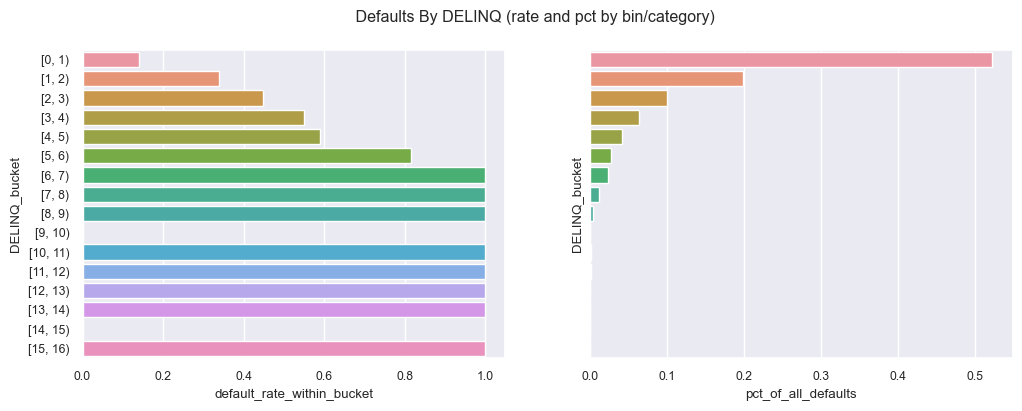

In [60]:
delinq_dist.plot_defaults()

In [61]:
delinq_dist.default_rate

0.20762081784386618

Observations

* The number of deliquent credit lines per borrower varies from 0 to 15, with a mean of 0.4, a median of 0.0 and a standard deviation of 1.1
* The distribution is very skewed to the right as most borrowers have very few deliquent credit lines (78% have none, 90% have 1 or less, and 94% have 2 or less)
* Note that ~10% of data points are missing here. The average default rate is close to 21%.
* Default rates: there is a clear relationship between number of deliquent credit lines and default probability. Having a single deliquent credit line more than doubles default rate - 14% for no deliquencies to 34% for 1 deliquent credit line. The default rate keeps on increasing after that. This factor may have significant explanatory power.

#### <font color="#3498DB"><strong>CLAGE </strong>(Age of oldest Credit Line)</font>

In [62]:
# Instantiate dist object
clage_bins1 = [i*120 for i in range(0,11)]  # 10y block
clage_bins2 = [i*60 for i in range(0,22)]   # 5y block
clage_bins3 = [i*24 for i in range(0,22)]   # 2y block

clage_dist = FeatureDistAnalyzer(d1, 'CLAGE', bins=clage_bins3)

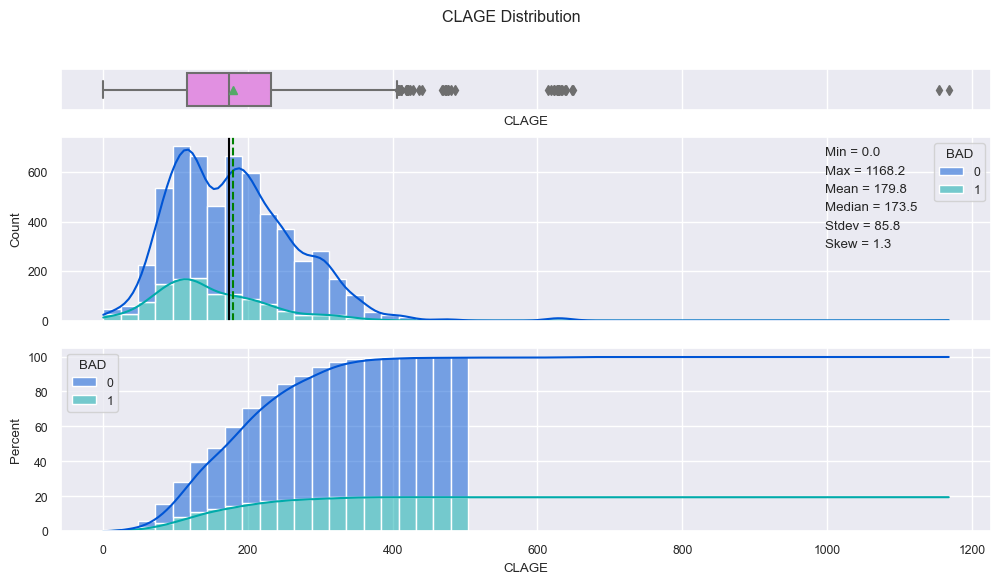

In [63]:
clage_dist.plot_hist()

In [64]:
clage_dist.get_data()

counter                        counter_pct_total            \
BAD                0    1 total total_cumul                 0         1   
CLAGE_bucket                                                              
[0, 24)           21   25    46          46          0.003729  0.004439   
[24, 48)          33   28    61         107          0.005859  0.004972   
[48, 72)         150   76   226         333          0.026634  0.013494   
[72, 96)         386  149   535         868          0.068537  0.026456   
[96, 120)        538  167   705        1573          0.095526  0.029652   
[120, 144)       492  172   664        2237          0.087358  0.030540   
[144, 168)       357  106   463        2700          0.063388  0.018821   
[168, 192)       559  106   665        3365          0.099254  0.018821   
[192, 216)       505   89   594        3959          0.089666  0.015803   
[216, 240)       363   68   431        4390          0.064453  0.012074   
[240, 264)       331   37   368        4758          0.058771  0.006570   
[264, 288)       219   22   241        4999          0.038885  0.003906   
[288, 312)       256   24   280        5279          0.045455  0.004261   
[312, 336)       143   24   167        5446          0.025391  0.004261   
[336, 360)        93   10   103        5549          0.016513  0.001776   
[360, 384)        31    3    34        5583          0.005504  0.000533   
[384, 408)        22    2    24        5607          0.003906  0.000355   
[408, 432)        14    0    14        5621          0.002486  0.000000   
[432, 456)         2    0     2        5623          0.000355  0.000000   
[456, 480)         6    1     7        5630          0.001065  0.000178   
[480, 504)         2    0     2        5632          0.000355  0.000000   

                                              defaults  \
BAD              total total_cumul default_total_cumul   
CLAGE_bucket                                             
[0, 24)       0.008168    0.008168                  25   
[24, 48)      0.010831    0.018999                  53   
[48, 72)      0.040128    0.059126                 129   
[72, 96)      0.094993    0.154119                 278   
[96, 120)     0.125178    0.279297                 445   
[120, 144)    0.117898    0.397195                 617   
[144, 168)    0.082209    0.479403                 723   
[168, 192)    0.118075    0.597479                 829   
[192, 216)    0.105469    0.702947                 918   
[216, 240)    0.076527    0.779474                 986   
[240, 264)    0.065341    0.844815                1023   
[264, 288)    0.042791    0.887607                1045   
[288, 312)    0.049716    0.937322                1069   
[312, 336)    0.029652    0.966974                1093   
[336, 360)    0.018288    0.985263                1103   
[360, 384)    0.006037    0.991300                1106   
[384, 408)    0.004261    0.995561                1108   
[408, 432)    0.002486    0.998047                1108   
[432, 456)    0.000355    0.998402                1108   
[456, 480)    0.001243    0.999645                1109   
[480, 504)    0.000355    1.000000                1109   

                                                             \
BAD          default_rate_within_bucket pct_of_all_defaults   
CLAGE_bucket                                                  
[0, 24)                        0.543478            0.022543   
[24, 48)                       0.459016            0.025248   
[48, 72)                       0.336283            0.068530   
[72, 96)                       0.278505            0.134355   
[96, 120)                      0.236879            0.150586   
[120, 144)                     0.259036            0.155095   
[144, 168)                     0.228942            0.095582   
[168, 192)                     0.159398            0.095582   
[192, 216)                     0.149832            0.080252   
[216, 240)                     0.157773            0.061317   


BAD           counter  default_rate_within_bucket  pct_of_all_defaults
CLAGE_bucket                                                          
[0, 24)            25                    0.543478             0.022543
[24, 48)           28                    0.459016             0.025248
[48, 72)           76                    0.336283             0.068530
[72, 96)          149                    0.278505             0.134355
[96, 120)         167                    0.236879             0.150586
[120, 144)        172                    0.259036             0.155095
[144, 168)        106                    0.228942             0.095582
[168, 192)        106                    0.159398             0.095582
[192, 216)         89                    0.149832             0.080252
[216, 240)         68                    0.157773             0.061317
[240, 264)         37                    0.100543             0.033363
[264, 288)         22                    0.091286             0.019838
[288, 312)         24                    0.085714             0.021641
[312, 336)         24                    0.143713             0.021641
[336, 360)         10                    0.097087             0.009017
[360, 384)          3                    0.088235             0.002705
[384, 408)          2                    0.083333             0.001803
[408, 432)          0                    0.000000             0.000000
[432, 456)          0                    0.000000             0.000000
[456, 480)          1                    0.142857             0.000902
[480, 504)          0                    0.000000             0.000000

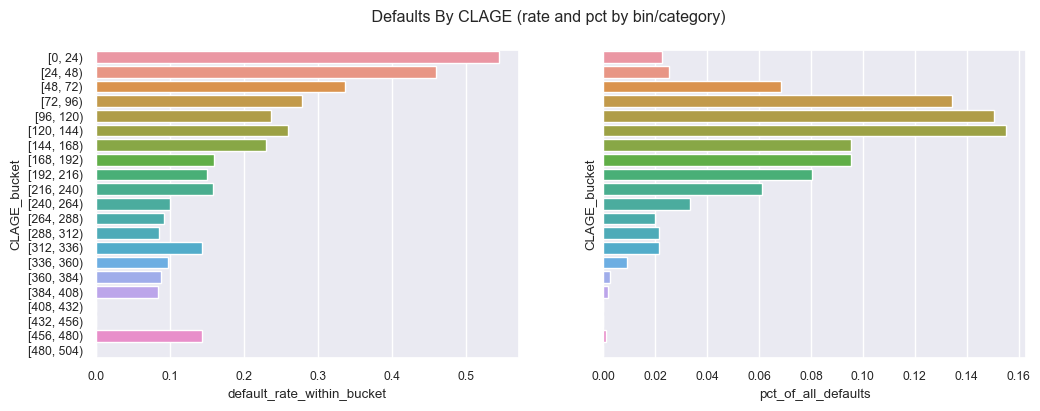

In [65]:
clage_dist.plot_defaults()

In [66]:
clage_dist.default_rate

0.19656758669497523

Observations

* The max age of credit lines per borrower varies from 0 to 1168 months, with a mean of 179.8 (15y), a median of 173.5 (14.5y) and a standard deviation of 85.8 (7.2y)
* The mean and average are quite high (14-15Y) which probably means the mortgage is counted as one of the credit lines.
* Some outliers (>50y) seem a bit suspicious - could be manual errors. We may remove them before building ML models to avoid unncessary distorsions. 
* Default rates: there is again a clear (negative) relationship between the max age of credit lines and default probability. Borrowers with "recent" credit lines are much more likely to default (54% if max CL age < 2y)

#### <font color="#3498DB"><strong>NINQ </strong>(No. recent credit Inquiries)</font>

In [67]:
# Instantiate dist object
ninq_bins1 = [i*1 for i in range(0,17)]

ninq_dist = FeatureDistAnalyzer(d1, 'NINQ', bins=ninq_bins1)

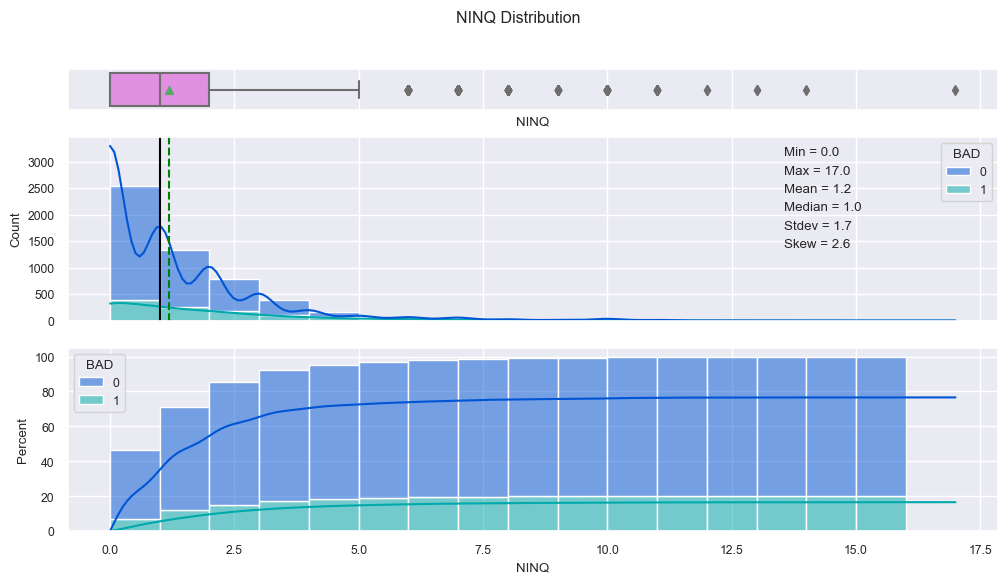

In [68]:
ninq_dist.plot_hist()

In [69]:
ninq_dist.get_data()

counter                        counter_pct_total            \
BAD               0    1 total total_cumul                 0         1   
NINQ_bucket                                                              
[0, 1)         2135  396  2531        2531          0.391815  0.072674   
[1, 2)         1085  254  1339        3870          0.199119  0.046614   
[2, 3)          599  181   780        4650          0.109928  0.033217   
[3, 4)          285  107   392        5042          0.052303  0.019637   
[4, 5)           95   61   156        5198          0.017434  0.011195   
[5, 6)           39   36    75        5273          0.007157  0.006607   
[6, 7)           27   29    56        5329          0.004955  0.005322   
[7, 8)           29   15    44        5373          0.005322  0.002753   
[8, 9)           11   11    22        5395          0.002019  0.002019   
[9, 10)           5    6    11        5406          0.000918  0.001101   
[10, 11)         19    9    28        5434          0.003487  0.001652   
[11, 12)          7    3    10        5444          0.001285  0.000551   
[12, 13)          0    2     2        5446          0.000000  0.000367   
[13, 14)          0    2     2        5448          0.000000  0.000367   
[14, 15)          0    1     1        5449          0.000000  0.000184   
[15, 16)          0    0     0        5449          0.000000  0.000000   

                                             defaults  \
BAD             total total_cumul default_total_cumul   
NINQ_bucket                                             
[0, 1)       0.464489    0.464489                 396   
[1, 2)       0.245733    0.710222                 650   
[2, 3)       0.143146    0.853368                 831   
[3, 4)       0.071940    0.925307                 938   
[4, 5)       0.028629    0.953937                 999   
[5, 6)       0.013764    0.967700                1035   
[6, 7)       0.010277    0.977978                1064   
[7, 8)       0.008075    0.986052                1079   
[8, 9)       0.004037    0.990090                1090   
[9, 10)      0.002019    0.992109                1096   
[10, 11)     0.005139    0.997247                1105   
[11, 12)     0.001835    0.999082                1108   
[12, 13)     0.000367    0.999449                1110   
[13, 14)     0.000367    0.999816                1112   
[14, 15)     0.000184    1.000000                1113   
[15, 16)     0.000000    1.000000                1113   

                                                            \
BAD         default_rate_within_bucket pct_of_all_defaults   
NINQ_bucket                                                  
[0, 1)                        0.156460            0.355795   
[1, 2)                        0.189694            0.228212   
[2, 3)                        0.232051            0.162624   
[3, 4)                        0.272959            0.096137   
[4, 5)                        0.391026            0.054807   
[5, 6)                        0.480000            0.032345   
[6, 7)                        0.517857            0.026056   
[7, 8)                        0.340909            0.013477   
[8, 9)                        0.500000            0.009883   
[9, 10)                       0.545455            0.005391   
[10, 11)                      0.321429            0.008086   
[11, 12)                      0.300000            0.002695   
[12, 13)                      1.000000            0.001797   
[13, 14)                      1.000000            0.001797   
[14, 15)                      1.000000            0.000898   
[15, 16)                           NaN            0.000000   

                                       
BAD         pct_of_all_defaults_cumul  
NINQ_bucket                            
[0, 1)                       0.355795  
[1, 2)                       0.584007  
[2, 3)                       0.746631  
[3, 4)                       0.842767  
[4, 5)                       0.897574  
[5, 6)                

BAD          counter  default_rate_within_bucket  pct_of_all_defaults
NINQ_bucket                                                          
[0, 1)           396                    0.156460             0.355795
[1, 2)           254                    0.189694             0.228212
[2, 3)           181                    0.232051             0.162624
[3, 4)           107                    0.272959             0.096137
[4, 5)            61                    0.391026             0.054807
[5, 6)            36                    0.480000             0.032345
[6, 7)            29                    0.517857             0.026056
[7, 8)            15                    0.340909             0.013477
[8, 9)            11                    0.500000             0.009883
[9, 10)            6                    0.545455             0.005391
[10, 11)           9                    0.321429             0.008086
[11, 12)           3                    0.300000             0.002695
[12, 13)           2                    1.000000             0.001797
[13, 14)           2                    1.000000             0.001797
[14, 15)           1                    1.000000             0.000898
[15, 16)           0                         NaN             0.000000

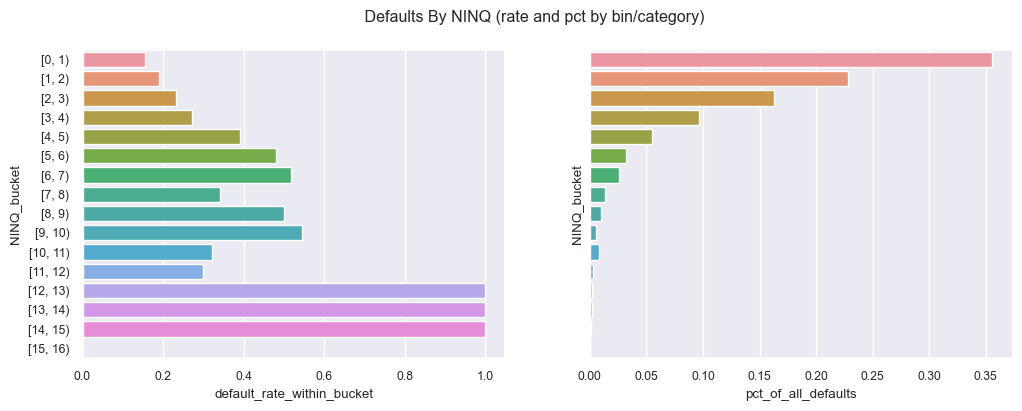

In [70]:
ninq_dist.plot_defaults()

In [71]:
ninq_dist.default_rate

0.20440366972477064

Observations

* The number of inquiries per borrower varies from about 0 to 17, with a mean of 1.2, a median of 1.0 and a standard deviation of 1.7
* The distribution has a strong positive skew
* 46% of borrowers have NO recent credit inquiries, 71% have 1 or less, and 95% have 4 or less. 
* Default rates: there a positive relationship between the number of inquiries and default probability (especially up to 6 inquiries, which is where most of the data points lie). This could be explained by the fact that borrowers have previously been rejected by other credit institutions, and they looked for other options.

#### <font color="#3498DB"><strong>DEBTINC (Debt-to-Income ratio)</strong></font>

In [72]:
# Instantiate dist object
debtinc_bins1 = [i*5 for i in range(0,42)]
debtinc_bins2 = [i*5 for i in range(0,10)] + [i*10 for i in range(5,10)] + [i*25 for i in range(4,10)] # zoom on left

debtinc_dist = FeatureDistAnalyzer(d1, 'DEBTINC', bins=debtinc_bins2)

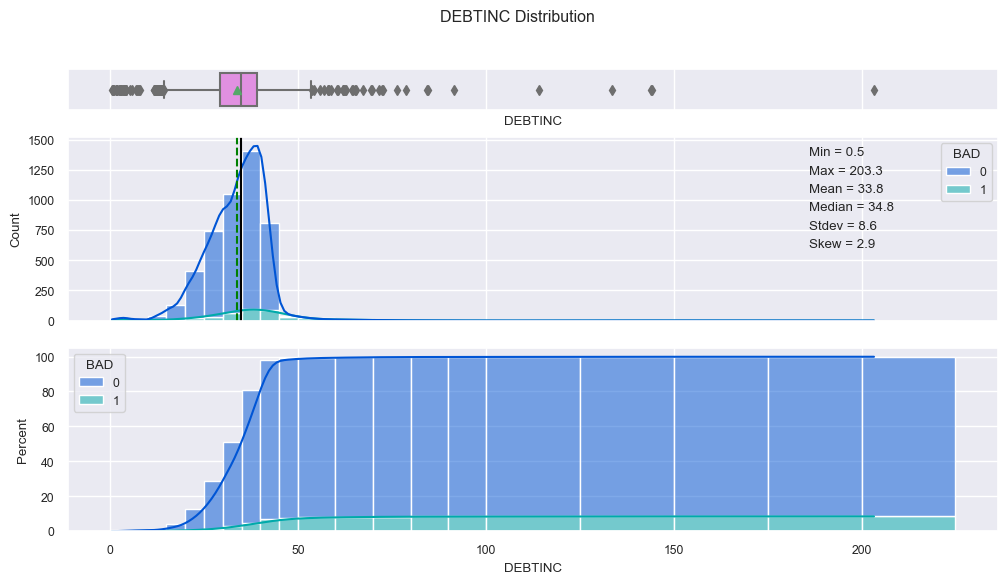

In [73]:
debtinc_dist.plot_hist()

In [74]:
debtinc_dist.get_data()

counter                       counter_pct_total            \
BAD                  0   1 total total_cumul                 0         1   
DEBTINC_bucket                                                             
[0, 5)              15  10    25          25          0.003196  0.002131   
[5, 10)              5   2     7          32          0.001065  0.000426   
[10, 15)            33   2    35          67          0.007032  0.000426   
[15, 20)           124   7   131         198          0.026422  0.001492   
[20, 25)           387  21   408         606          0.082463  0.004475   
[25, 30)           712  30   742        1348          0.151715  0.006392   
[30, 35)           983  63  1046        2394          0.209461  0.013424   
[35, 40)          1307  98  1405        3799          0.278500  0.020882   
[40, 45)           719  91   810        4609          0.153207  0.019391   
[45, 50)             5  34    39        4648          0.001065  0.007245   
[50, 60)             0  18    18        4666          0.000000  0.003835   
[60, 70)             0  14    14        4680          0.000000  0.002983   
[70, 80)             0   5     5        4685          0.000000  0.001065   
[80, 90)             0   2     2        4687          0.000000  0.000426   
[90, 100)            0   1     1        4688          0.000000  0.000213   
[100, 125)           0   1     1        4689          0.000000  0.000213   
[125, 150)           0   3     3        4692          0.000000  0.000639   
[150, 175)           0   0     0        4692          0.000000  0.000000   
[175, 200)           0   0     0        4692          0.000000  0.000000   
[200, 225)           0   1     1        4693          0.000000  0.000213   

                                                defaults  \
BAD                total total_cumul default_total_cumul   
DEBTINC_bucket                                             
[0, 5)          0.005327    0.005327                  10   
[5, 10)         0.001492    0.006819                  12   
[10, 15)        0.007458    0.014277                  14   
[15, 20)        0.027914    0.042190                  21   
[20, 25)        0.086938    0.129128                  42   
[25, 30)        0.158108    0.287236                  72   
[30, 35)        0.222885    0.510121                 135   
[35, 40)        0.299382    0.809504                 233   
[40, 45)        0.172597    0.982101                 324   
[45, 50)        0.008310    0.990411                 358   
[50, 60)        0.003835    0.994247                 376   
[60, 70)        0.002983    0.997230                 390   
[70, 80)        0.001065    0.998295                 395   
[80, 90)        0.000426    0.998722                 397   
[90, 100)       0.000213    0.998935                 398   
[100, 125)      0.000213    0.999148                 399   
[125, 150)      0.000639    0.999787                 402   
[150, 175)      0.000000    0.999787                 402   
[175, 200)      0.000000    0.999787                 402   
[200, 225)      0.000213    1.000000                 403   

                                                               \
BAD            default_rate_within_bucket pct_of_all_defaults   
DEBTINC_bucket                                                  
[0, 5)                           0.400000            0.024814   
[5, 10)                          0.285714            0.004963   
[10, 15)                         0.057143            0.004963   
[15, 20)                         0.053435            0.017370   
[20, 25)                         0.051471            0.052109   
[25, 30)                         0.040431            0.074442   
[30, 35)                         0.060229            0.156328   
[35, 40)                         0.069751            0.243176   
[40, 45)                         0.112346            0.225806   
[45, 50)                         0.871795            0.084367   
[50, 60)                         1.00000

BAD             counter  default_rate_within_bucket  pct_of_all_defaults
DEBTINC_bucket                                                          
[0, 5)               10                    0.400000             0.024814
[5, 10)               2                    0.285714             0.004963
[10, 15)              2                    0.057143             0.004963
[15, 20)              7                    0.053435             0.017370
[20, 25)             21                    0.051471             0.052109
[25, 30)             30                    0.040431             0.074442
[30, 35)             63                    0.060229             0.156328
[35, 40)             98                    0.069751             0.243176
[40, 45)             91                    0.112346             0.225806
[45, 50)             34                    0.871795             0.084367
[50, 60)             18                    1.000000             0.044665
[60, 70)             14                    1.000000             0.034739
[70, 80)              5                    1.000000             0.012407
[80, 90)              2                    1.000000             0.004963
[90, 100)             1                    1.000000             0.002481
[100, 125)            1                    1.000000             0.002481
[125, 150)            3                    1.000000             0.007444
[150, 175)            0                         NaN             0.000000
[175, 200)            0                         NaN             0.000000
[200, 225)            1                    1.000000             0.002481

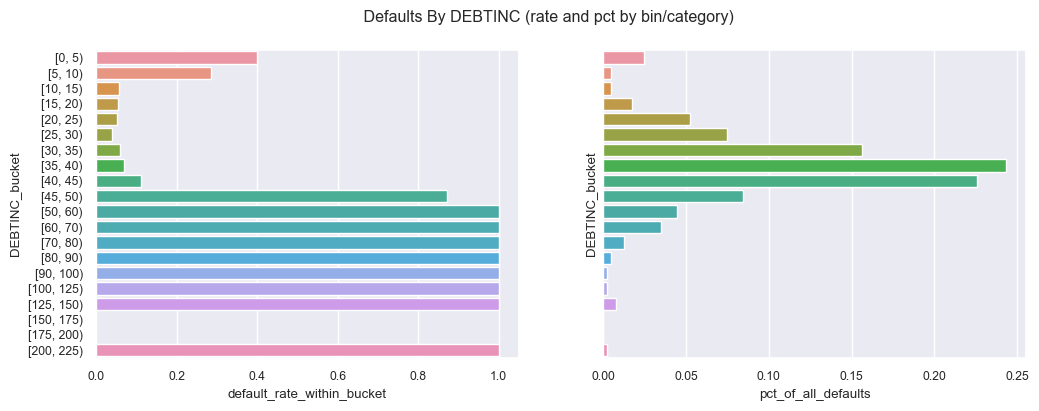

In [75]:
debtinc_dist.plot_defaults()

In [76]:
debtinc_dist.default_rate

0.08587257617728532

Observations

* Borrowers' debt to income ratio varies from 0.5 to 203.3, with a mean of 33.8, a median of 34.8 and a standard deviation of 8.6
* The mean and median make sense as banks typically use 1/3 as an approximate "rule of thumb" to estimate max borrowing capacity. 
* About 50% of borrowers have a DEBTINC ratio below 35%, 81% below 40%, 98% below 45% and 99% below 50%. This confirms that banks are very reluctant to lend to "leveraged" client, and that 50% is seen as a significant threshold.
* There is a long queue of borrowers with DEBTINC ratio > 50% (including a few isolated points above 100%). Those could be borrowers with low income but significant assets for example (which may be used as collateral to reduce risk).
* Default rates: once again 2 groups emerger in terms of high-risk borrowers:
    * those with high debt to income ratios -> default rate is 100% for all clients 50% DEBTINC ratio and 87% in the [45-50%[ bracket (representing 8% of defaults here)
    * and within the more "normal" spectrum, those with very low DEBTINC ratios. One would thing that this is a low risk "tranche" so this is quite surprising. One possible explanation could be that some borrowers simply lie about their overall debt level to secure a loan - to be investigated further.
* <strong><font color="#E74C3C">Important note</font></strong>: more than 20% of DEBTINC points are missing. The default rate within the "populated" dataset is <strong>8.6%</strong> vs 20% for the global dataset. The default rate among missing DEBTINC ratio is <strong>62.0%</strong>. It is extremely unlikely that a random sample's mean would deviate that much from the population's*, meaning the DEBTINC ratio is not missing "by chance" - either borrowers conceal/withhold the information or underwriters deliberatly decide to "ignore" it in some cases. 
* *[TO DO: hypothesis testing] 

#### <font color="#3498DB"><strong>REASON </strong>(for loan application)</font>

In [77]:
reason_dist = FeatureDistAnalyzer(d1, 'REASON', bins=None)
reason_dist.get_data()

counter                        counter_pct_total            \
BAD             0    1 total total_cumul                 0         1   
REASON                                                                 
*unknown*     204   48   252         252          0.034228  0.008054   
DebtCon      3183  745  3928        4180          0.534060  0.125000   
HomeImp      1384  396  1780        5960          0.232215  0.066443   

                                           defaults  \
BAD           total total_cumul default_total_cumul   
REASON                                                
*unknown*  0.042282    0.042282                  48   
DebtCon    0.659060    0.701342                 793   
HomeImp    0.298658    1.000000                1189   

                                                          \
BAD       default_rate_within_bucket pct_of_all_defaults   
REASON                                                     
*unknown*                   0.190476            0.040370   
DebtCon                     0.189664            0.626577   
HomeImp                     0.222472            0.333053   

                                     
BAD       pct_of_all_defaults_cumul  
REASON                               
*unknown*                  0.040370  
DebtCon                    0.666947  
HomeImp                    1.000000

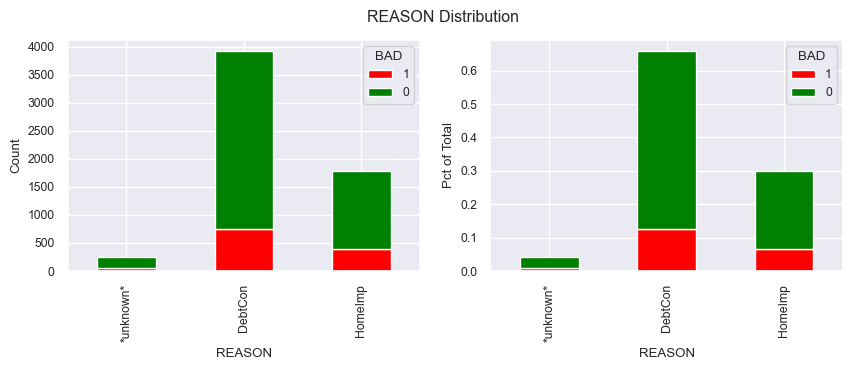

In [78]:
reason_dist.plot_cat()

BAD        counter  default_rate_within_bucket  pct_of_all_defaults
REASON                                                             
*unknown*       48                    0.190476             0.040370
DebtCon        745                    0.189664             0.626577
HomeImp        396                    0.222472             0.333053

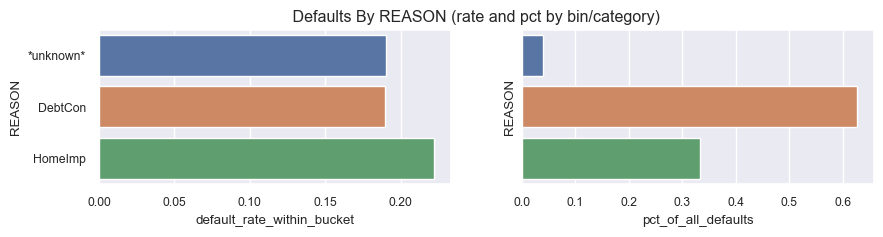

In [79]:
reason_dist.plot_defaults(figsize=(10,2))

Observations

* About 2/3 (66%) of borrowers used the loan for Debt Consolidation. About 30% used it for home improvement, and the remaining ~0.5% didn't provide a specific reason.
* Default rate: the proportion of bad loans for 'Home Improvement' is 22%, slightly higher than 'Debt Consolidation' (19%). 
* Borrowers who didn't provide a reason also have a 19% default rate so no bias there.

#### <font color="#3498DB"><strong>JOB </strong>(Job Type)</font>

In [80]:
job_dist = FeatureDistAnalyzer(d1, 'JOB', bins=None)
job_dist.get_data()

counter                        counter_pct_total            \
BAD             0    1 total total_cumul                 0         1   
JOB                                                                    
*unknown*     256   23   279         279          0.042953  0.003859   
Mgr           588  179   767        1046          0.098658  0.030034   
Office        823  125   948        1994          0.138087  0.020973   
Other        1834  554  2388        4382          0.307718  0.092953   
ProfExe      1064  212  1276        5658          0.178523  0.035570   
Sales          71   38   109        5767          0.011913  0.006376   
Self          135   58   193        5960          0.022651  0.009732   

                                           defaults  \
BAD           total total_cumul default_total_cumul   
JOB                                                   
*unknown*  0.046812    0.046812                  23   
Mgr        0.128691    0.175503                 202   
Office     0.159060    0.334564                 327   
Other      0.400671    0.735235                 881   
ProfExe    0.214094    0.949329                1093   
Sales      0.018289    0.967617                1131   
Self       0.032383    1.000000                1189   

                                                          \
BAD       default_rate_within_bucket pct_of_all_defaults   
JOB                                                        
*unknown*                   0.082437            0.019344   
Mgr                         0.233377            0.150547   
Office                      0.131857            0.105130   
Other                       0.231993            0.465938   
ProfExe                     0.166144            0.178301   
Sales                       0.348624            0.031960   
Self                        0.300518            0.048780   

                                     
BAD       pct_of_all_defaults_cumul  
JOB                                  
*unknown*                  0.019344  
Mgr                        0.169891  
Office                     0.275021  
Other                      0.740959  
ProfExe                    0.919260  
Sales                      0.951220  
Self                       1.000000

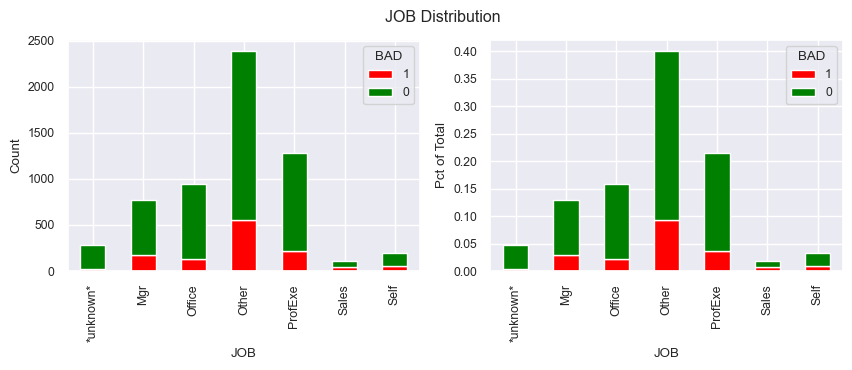

In [81]:
job_dist.plot_cat()

BAD        counter  default_rate_within_bucket  pct_of_all_defaults
JOB                                                                
*unknown*       23                    0.082437             0.019344
Mgr            179                    0.233377             0.150547
Office         125                    0.131857             0.105130
Other          554                    0.231993             0.465938
ProfExe        212                    0.166144             0.178301
Sales           38                    0.348624             0.031960
Self            58                    0.300518             0.048780

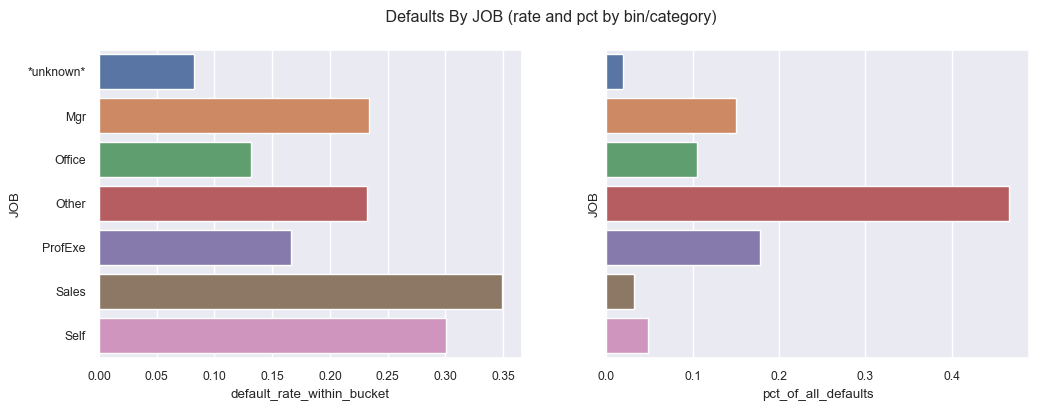

In [82]:
job_dist.plot_defaults()

Observations

* 40% of borrowers are in 'Other' job category, followed by Professional Executives (21%) and Office Employees (16%). About 5% are unknown (missing data points)
* The highest default rates are among Sales (35%) and Self-Employed (30%). Office Employees have the lowest default rate at 13% (note that 'unknown' is at 8%)

#### <font color="#1D8348"><strong>LTV </strong>(Loan to Value)</font>

In [83]:
# Instantiate dist object
ltv_bins1 = [i*0.2 for i in range(0,36)]
ltv_bins2 = [i*0.1 for i in range(0,10)] + [i*1 for i in range(1,9)]

ltv_dist = FeatureDistAnalyzer(d1, 'LTV', bins=ltv_bins2)

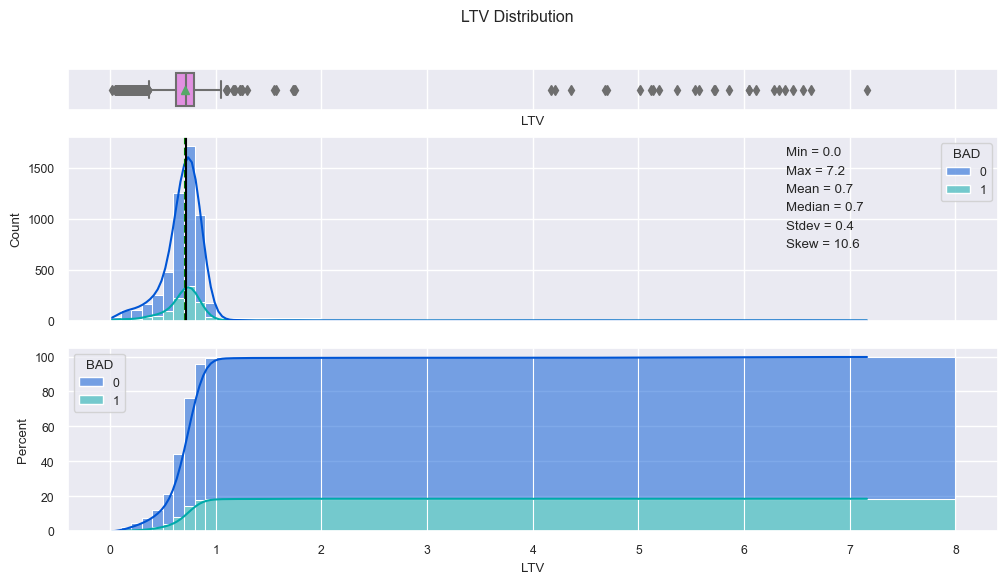

In [84]:
# Plot Distribution
ltv_dist.plot_hist()

In [85]:
ltv_dist.get_data()

counter                        counter_pct_total            \
BAD              0    1 total total_cumul                 0         1   
LTV_bucket                                                              
[0.0, 0.1)      27    9    36          36          0.005040  0.001680   
[0.1, 0.2)      86   16   102         138          0.016054  0.002987   
[0.2, 0.3)      89   13   102         240          0.016614  0.002427   
[0.3, 0.4)     130   37   167         407          0.024267  0.006907   
[0.4, 0.5)     201   50   251         658          0.037521  0.009334   
[0.5, 0.6)     384   90   474        1132          0.071682  0.016800   
[0.6, 0.7)    1031  219  1250        2382          0.192458  0.040881   
[0.7, 0.8)    1379  337  1716        4098          0.257420  0.062908   
[0.8, 0.9)     854  181  1035        5133          0.159418  0.033788   
[0.9, 1.0)     140   33   173        5306          0.026134  0.006160   
[1.0, 2.0)      14   12    26        5332          0.002613  0.002240   
[2.0, 3.0)       0    0     0        5332          0.000000  0.000000   
[3.0, 4.0)       0    0     0        5332          0.000000  0.000000   
[4.0, 5.0)       5    0     5        5337          0.000933  0.000000   
[5.0, 6.0)      10    0    10        5347          0.001867  0.000000   
[6.0, 7.0)       8    1     9        5356          0.001493  0.000187   
[7.0, 8.0)       1    0     1        5357          0.000187  0.000000   

                                            defaults  \
BAD            total total_cumul default_total_cumul   
LTV_bucket                                             
[0.0, 0.1)  0.006720    0.006720                   9   
[0.1, 0.2)  0.019041    0.025761                  25   
[0.2, 0.3)  0.019041    0.044801                  38   
[0.3, 0.4)  0.031174    0.075975                  75   
[0.4, 0.5)  0.046855    0.122830                 125   
[0.5, 0.6)  0.088482    0.211312                 215   
[0.6, 0.7)  0.233340    0.444652                 434   
[0.7, 0.8)  0.320329    0.764980                 771   
[0.8, 0.9)  0.193205    0.958186                 952   
[0.9, 1.0)  0.032294    0.990480                 985   
[1.0, 2.0)  0.004853    0.995333                 997   
[2.0, 3.0)  0.000000    0.995333                 997   
[3.0, 4.0)  0.000000    0.995333                 997   
[4.0, 5.0)  0.000933    0.996267                 997   
[5.0, 6.0)  0.001867    0.998133                 997   
[6.0, 7.0)  0.001680    0.999813                 998   
[7.0, 8.0)  0.000187    1.000000                 998   

                                                           \
BAD        default_rate_within_bucket pct_of_all_defaults   
LTV_bucket                                                  
[0.0, 0.1)                   0.250000            0.009018   
[0.1, 0.2)                   0.156863            0.016032   
[0.2, 0.3)                   0.127451            0.013026   
[0.3, 0.4)                   0.221557            0.037074   
[0.4, 0.5)                   0.199203            0.050100   
[0.5, 0.6)                   0.189873            0.090180   
[0.6, 0.7)                   0.175200            0.219439   
[0.7, 0.8)                   0.196387            0.337675   
[0.8, 0.9)                   0.174879            0.181363   
[0.9, 1.0)                   0.190751            0.033066   
[1.0, 2.0)                   0.461538            0.012024   
[2.0, 3.0)                        NaN            0.000000   
[3.0, 4.0)                        NaN            0.000000   
[4.0, 5.0)                   0.000000            0.000000   
[5.0, 6.0)                   0.000000            0.000000   
[6.0, 7.0)                   0.111111            0.001002   
[7.0, 8.0)                   0.000000            0.000000   

                                      
BAD        pct_of_all_defaults_cumul  
LTV_bucket                            
[0.0, 0.1)                  0.009018  
[0.1, 0.2)                  0.025050  
[0.2, 0.3)   

BAD         counter  default_rate_within_bucket  pct_of_all_defaults
LTV_bucket                                                          
[0.0, 0.1)        9                    0.250000             0.009018
[0.1, 0.2)       16                    0.156863             0.016032
[0.2, 0.3)       13                    0.127451             0.013026
[0.3, 0.4)       37                    0.221557             0.037074
[0.4, 0.5)       50                    0.199203             0.050100
[0.5, 0.6)       90                    0.189873             0.090180
[0.6, 0.7)      219                    0.175200             0.219439
[0.7, 0.8)      337                    0.196387             0.337675
[0.8, 0.9)      181                    0.174879             0.181363
[0.9, 1.0)       33                    0.190751             0.033066
[1.0, 2.0)       12                    0.461538             0.012024
[2.0, 3.0)        0                         NaN             0.000000
[3.0, 4.0)        0                         NaN             0.000000
[4.0, 5.0)        0                    0.000000             0.000000
[5.0, 6.0)        0                    0.000000             0.000000
[6.0, 7.0)        1                    0.111111             0.001002
[7.0, 8.0)        0                    0.000000             0.000000

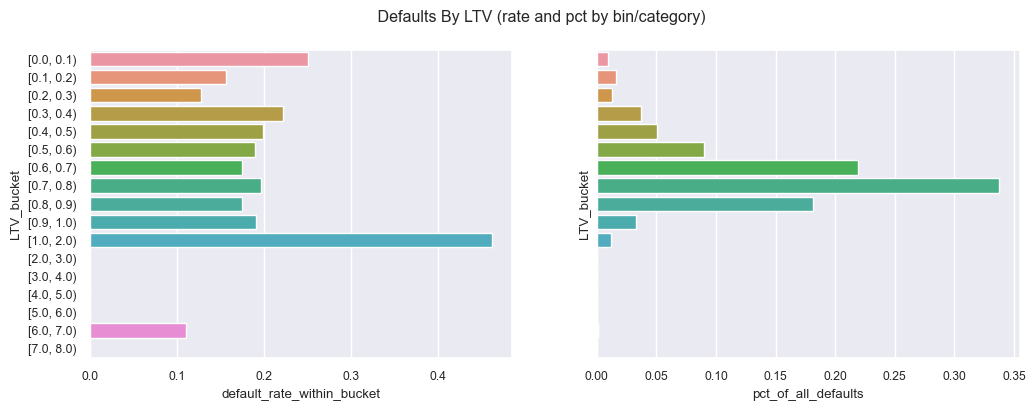

In [86]:
ltv_dist.plot_defaults()

Observations

* Most borrowers have an LTV between 60% and 90% (about 32% of borrowers between 70-80% LTV)
* 99% of borrowers are under 100% LTV - there's a long queue of outliers of abnormally high LTVs causing a very high skew
* LTV doesn;t seem to have a major influence in terms of default rate so it might not have much explanatory power after all - we'll test that in the ML model

#### <font color="#1D8348"><strong>LTV_ADJ </strong>(Adjusted Loan to Value)</font>

In [87]:
# Instantiate dist object
ltvadj_bins1 = [i*0.2 for i in range(0,36)]
ltvadj_bins2 = [i*0.1 for i in range(0,10)] + [i*1 for i in range(1,9)]

ltvadj_dist = FeatureDistAnalyzer(d1, 'LTV_ADJ', bins=ltv_bins2)

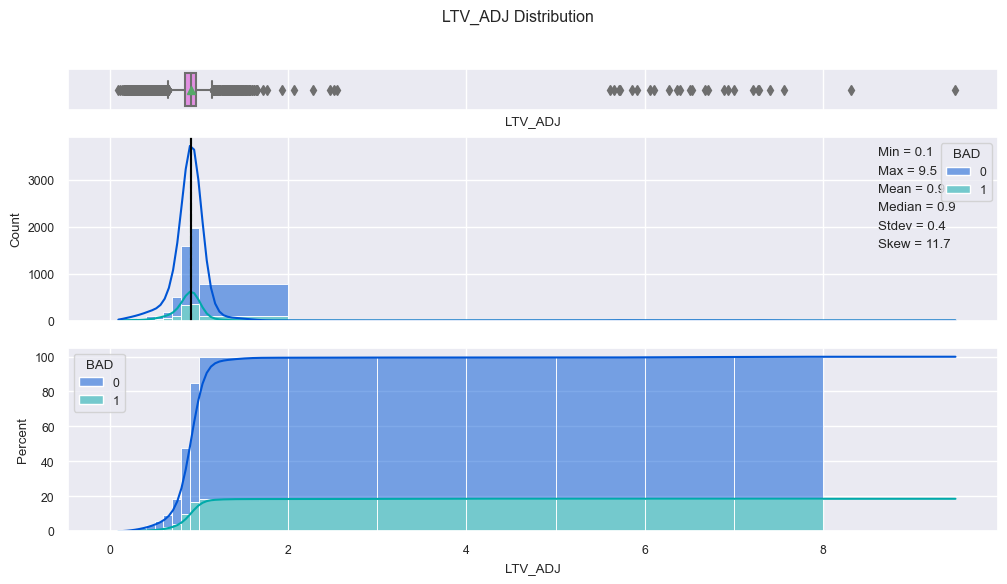

In [88]:
# Plot Distribution
ltvadj_dist.plot_hist()

BAD             counter  default_rate_within_bucket  pct_of_all_defaults
LTV_ADJ_bucket                                                          
[0.0, 0.1)            1                    1.000000             0.001003
[0.1, 0.2)            7                    0.437500             0.007021
[0.2, 0.3)            5                    0.151515             0.005015
[0.3, 0.4)            6                    0.113208             0.006018
[0.4, 0.5)           13                    0.135417             0.013039
[0.5, 0.6)           32                    0.320000             0.032096
[0.6, 0.7)           55                    0.287958             0.055165
[0.7, 0.8)           90                    0.180361             0.090271
[0.8, 0.9)          327                    0.207224             0.327984
[0.9, 1.0)          353                    0.178463             0.354062
[1.0, 2.0)          103                    0.131714             0.103310
[2.0, 3.0)            5                    1.000000             0.005015
[3.0, 4.0)            0                         NaN             0.000000
[4.0, 5.0)            0                         NaN             0.000000
[5.0, 6.0)            0                    0.000000             0.000000
[6.0, 7.0)            0                    0.000000             0.000000
[7.0, 8.0)            0                    0.000000             0.000000

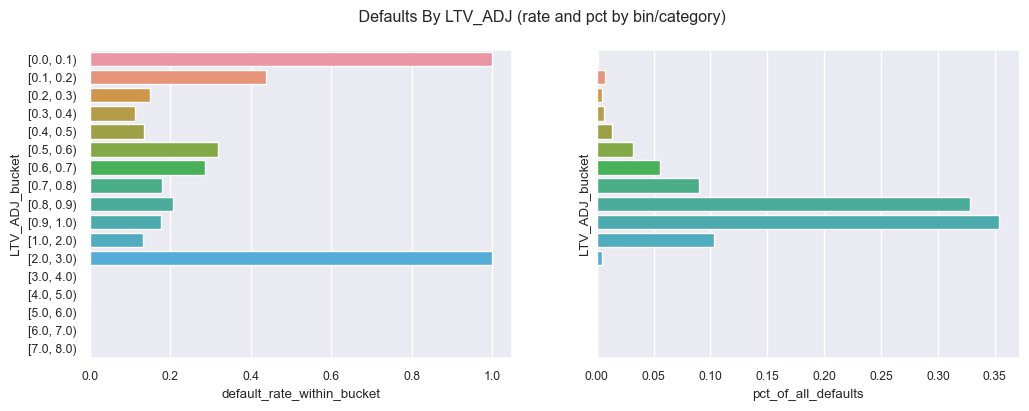

In [89]:
ltvadj_dist.plot_defaults()

Observations

* 

#### <font color="#1D8348"><strong>LTMORT </strong>(Loan to Mortgage)</font>

In [90]:
# Instantiate dist object
ltmort_bins1 = [i*0.1 for i in range(0,10)] + [i*1 for i in range(1, 13)]

ltmort_dist = FeatureDistAnalyzer(d1, 'LTMORT', bins=ltmort_bins1)

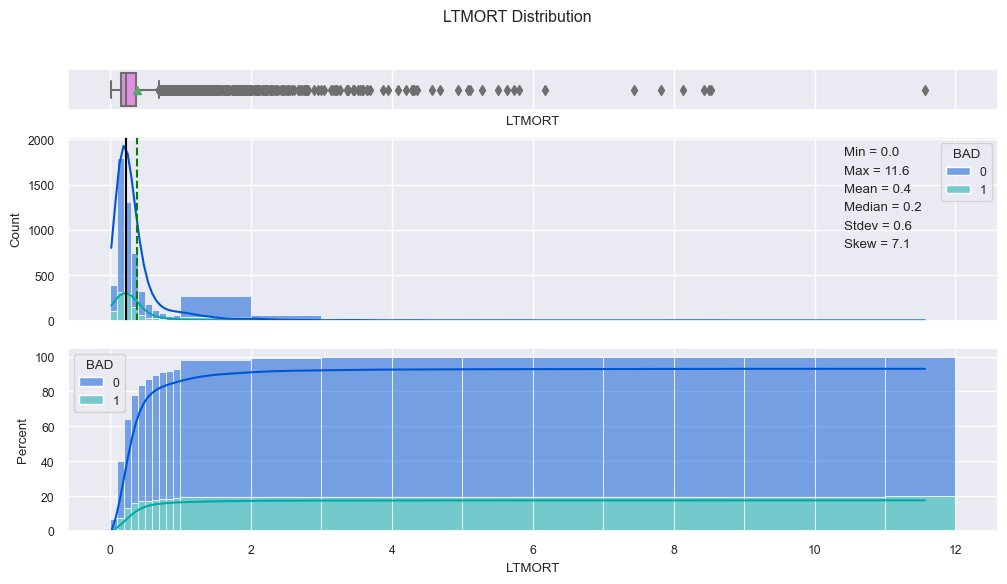

In [91]:
# Plot Distribution
ltmort_dist.plot_hist()

In [92]:
ltmort_dist.get_data()

counter                        counter_pct_total            \
BAD                 0    1 total total_cumul                 0         1   
LTMORT_bucket                                                              
[0.0, 0.1)        283  109   392         392          0.052003  0.020029   
[0.1, 0.2)       1480  311  1791        2183          0.271959  0.057148   
[0.2, 0.3)       1008  300  1308        3491          0.185226  0.055127   
[0.3, 0.4)        601  146   747        4238          0.110437  0.026828   
[0.4, 0.5)        267   63   330        4568          0.049063  0.011577   
[0.5, 0.6)        152   27   179        4747          0.027931  0.004961   
[0.6, 0.7)         89   28   117        4864          0.016354  0.005145   
[0.7, 0.8)         64   18    82        4946          0.011760  0.003308   
[0.8, 0.9)         44   11    55        5001          0.008085  0.002021   
[0.9, 1.0)         55   10    65        5066          0.010107  0.001838   
[1.0, 2.0)        225   44   269        5335          0.041345  0.008085   
[2.0, 3.0)         52    8    60        5395          0.009555  0.001470   
[3.0, 4.0)         20    3    23        5418          0.003675  0.000551   
[4.0, 5.0)          7    2     9        5427          0.001286  0.000368   
[5.0, 6.0)          6    1     7        5434          0.001103  0.000184   
[6.0, 7.0)          1    0     1        5435          0.000184  0.000000   
[7.0, 8.0)          2    0     2        5437          0.000368  0.000000   
[8.0, 9.0)          3    1     4        5441          0.000551  0.000184   
[9.0, 10.0)         0    0     0        5441          0.000000  0.000000   
[10.0, 11.0)        0    0     0        5441          0.000000  0.000000   
[11.0, 12.0)        0    1     1        5442          0.000000  0.000184   

                                               defaults  \
BAD               total total_cumul default_total_cumul   
LTMORT_bucket                                             
[0.0, 0.1)     0.072032    0.072032                 109   
[0.1, 0.2)     0.329107    0.401139                 420   
[0.2, 0.3)     0.240353    0.641492                 720   
[0.3, 0.4)     0.137266    0.778758                 866   
[0.4, 0.5)     0.060639    0.839397                 929   
[0.5, 0.6)     0.032892    0.872290                 956   
[0.6, 0.7)     0.021499    0.893789                 984   
[0.7, 0.8)     0.015068    0.908857                1002   
[0.8, 0.9)     0.010107    0.918964                1013   
[0.9, 1.0)     0.011944    0.930908                1023   
[1.0, 2.0)     0.049430    0.980338                1067   
[2.0, 3.0)     0.011025    0.991363                1075   
[3.0, 4.0)     0.004226    0.995590                1078   
[4.0, 5.0)     0.001654    0.997244                1080   
[5.0, 6.0)     0.001286    0.998530                1081   
[6.0, 7.0)     0.000184    0.998714                1081   
[7.0, 8.0)     0.000368    0.999081                1081   
[8.0, 9.0)     0.000735    0.999816                1082   
[9.0, 10.0)    0.000000    0.999816                1082   
[10.0, 11.0)   0.000000    0.999816                1082   
[11.0, 12.0)   0.000184    1.000000                1083   

                                                              \
BAD           default_rate_within_bucket pct_of_all_defaults   
LTMORT_bucket                                                  
[0.0, 0.1)                      0.278061            0.100646   
[0.1, 0.2)                      0.173646            0.287165   
[0.2, 0.3)                      0.229358            0.277008   
[0.3, 0.4)                      0.195448            0.134811   
[0.4, 0.5)                      0.190909            0.058172   
[0.5, 0.6)                      0.150838            0.024931   
[0.6, 0.7)                      0.239316            0.025854   
[0.7, 0.8)                      0.219512            0.016620   
[0.8, 0.9)                      0.200000            0.010157   
[0.9

BAD            counter  default_rate_within_bucket  pct_of_all_defaults
LTMORT_bucket                                                          
[0.0, 0.1)         109                    0.278061             0.100646
[0.1, 0.2)         311                    0.173646             0.287165
[0.2, 0.3)         300                    0.229358             0.277008
[0.3, 0.4)         146                    0.195448             0.134811
[0.4, 0.5)          63                    0.190909             0.058172
[0.5, 0.6)          27                    0.150838             0.024931
[0.6, 0.7)          28                    0.239316             0.025854
[0.7, 0.8)          18                    0.219512             0.016620
[0.8, 0.9)          11                    0.200000             0.010157
[0.9, 1.0)          10                    0.153846             0.009234
[1.0, 2.0)          44                    0.163569             0.040628
[2.0, 3.0)           8                    0.133333             0.007387
[3.0, 4.0)           3                    0.130435             0.002770
[4.0, 5.0)           2                    0.222222             0.001847
[5.0, 6.0)           1                    0.142857             0.000923
[6.0, 7.0)           0                    0.000000             0.000000
[7.0, 8.0)           0                    0.000000             0.000000
[8.0, 9.0)           1                    0.250000             0.000923
[9.0, 10.0)          0                         NaN             0.000000
[10.0, 11.0)         0                         NaN             0.000000
[11.0, 12.0)         1                    1.000000             0.000923

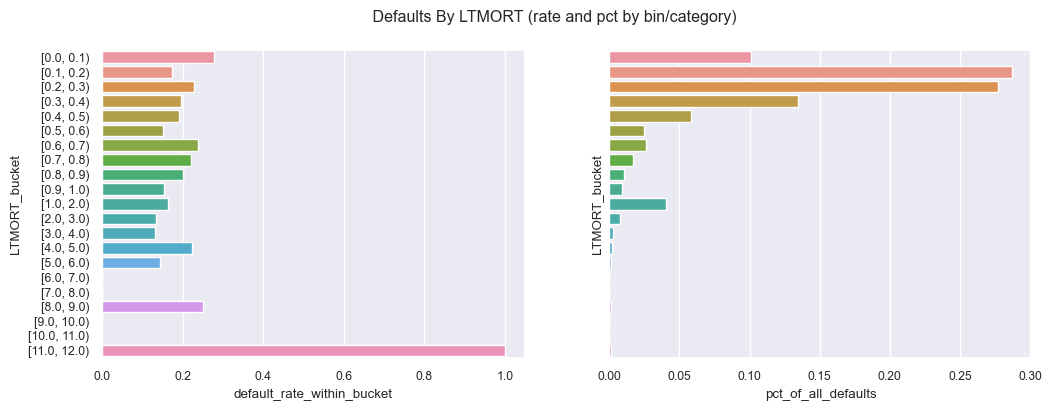

In [93]:
ltmort_dist.plot_defaults()

Observations

* The mean loan to mortgage ratio is 0.4, and median is 0.2
* A large porportion of loans (about 70%) represent 10 to 40% of mortgage due
* About 1/3 is in the 10-20% bracket
* About 2% of loans are > than mortgage due (borrowers releasing equity on low LTV mortgages)
* There is no compelling relationship between Loan to Mortgage ratio and defaut rate

#### <font color="#1D8348"><strong>MISSPCT </strong>(Missing Data)</font>

In [94]:
# Instantiate dist object
misspct_bins1 = [i*0.1 for i in range(0,11)] 
misspct_bins2 = [0, 0.05, 0.1, 0.25, 0.5, 1.1]
misspct_bins3 = [0, 0.01, 1.1]

misspct_dist = FeatureDistAnalyzer(d1, 'MISSPCT', bins=misspct_bins3)

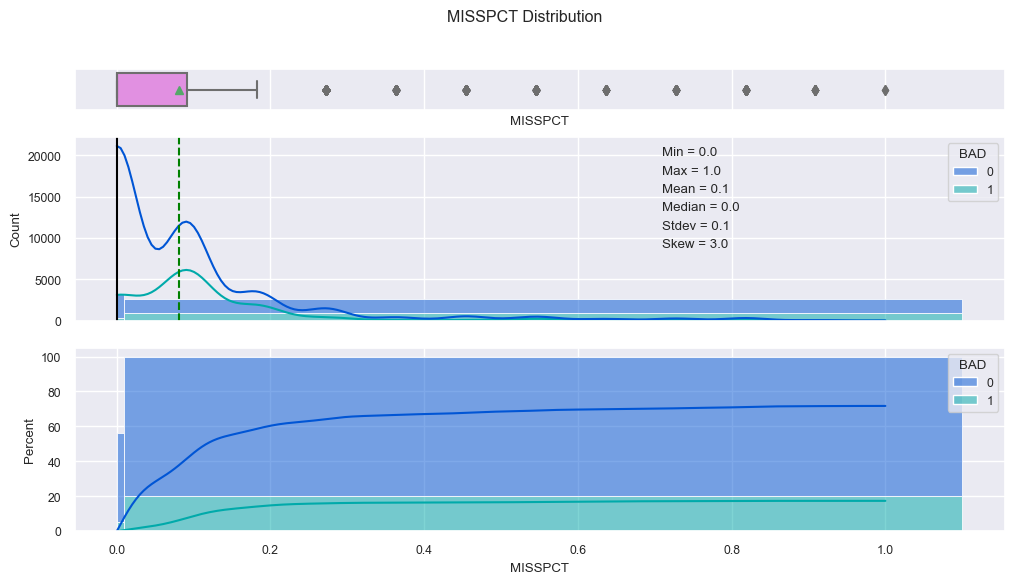

In [95]:
# Plot Distribution
misspct_dist.plot_hist()

In [96]:
misspct_dist.get_data()

counter                        counter_pct_total            \
BAD                  0    1 total total_cumul                 0         1   
MISSPCT_bucket                                                              
[0.0, 0.01)       3064  300  3364        3364          0.514094  0.050336   
[0.01, 1.1)       1707  889  2596        5960          0.286409  0.149161   

                                               defaults  \
BAD               total total_cumul default_total_cumul   
MISSPCT_bucket                                            
[0.0, 0.01)     0.56443     0.56443                 300   
[0.01, 1.1)     0.43557     1.00000                1189   

                                                               \
BAD            default_rate_within_bucket pct_of_all_defaults   
MISSPCT_bucket                                                  
[0.0, 0.01)                       0.08918            0.252313   
[0.01, 1.1)                       0.34245            0.747687   

                                          
BAD            pct_of_all_defaults_cumul  
MISSPCT_bucket                            
[0.0, 0.01)                     0.252313  
[0.01, 1.1)                     1.000000

BAD             counter  default_rate_within_bucket  pct_of_all_defaults
MISSPCT_bucket                                                          
[0.0, 0.01)         300                     0.08918             0.252313
[0.01, 1.1)         889                     0.34245             0.747687

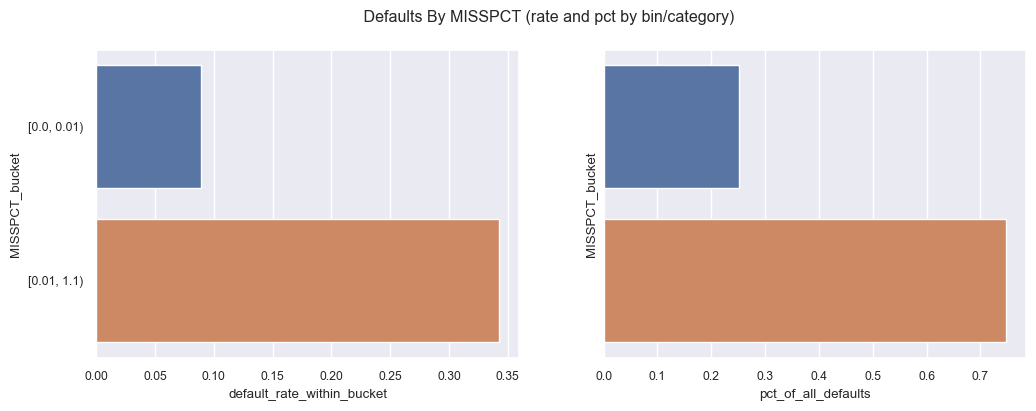

In [97]:
misspct_dist.plot_defaults()

Observations

* 56% of borrowers have a "fully-completed" application (ie no gaps in the data)
* The default rate among those is 9% (about half of average) vs <strong>34%</strong> for others
* => Missing information seems to be strongly correlated to default rate - lenders should make an effort to collect all the information required to better analyze the borrowers' risk profile and reduce this bias.

#### <font color="#1D8348"><strong>DELINQ_PCT </strong>(Bad Credit Lines %)</font>

In [98]:
# Instantiate dist object
delinqpct_bins1 = [i*0.01 for i in range(0,20)] + [i*0.1 for i in range(2,10)] 
delinqpct_bins2 = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1] 

delinqpct_dist = FeatureDistAnalyzer(d1, 'DELINQ_PCT', bins=delinqpct_bins2)

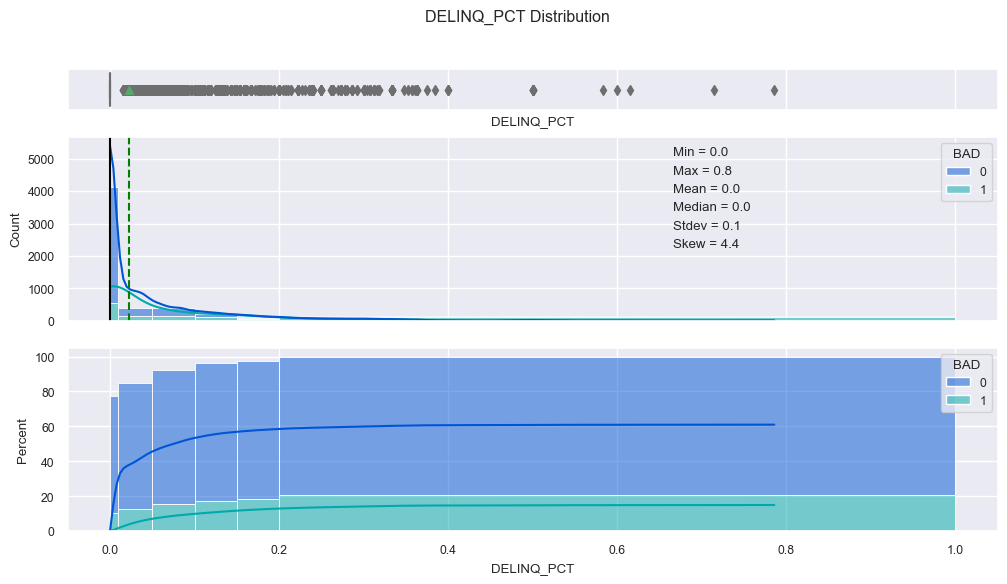

In [99]:
delinqpct_dist.plot_hist()

In [100]:
delinqpct_dist.get_data()

counter                        counter_pct_total            \
BAD                     0    1 total total_cumul                 0         1   
DELINQ_PCT_bucket                                                              
[0.0, 0.01)          3560  558  4118        4118          0.669425  0.104927   
[0.01, 0.05)          265  129   394        4512          0.049831  0.024257   
[0.05, 0.1)           250  138   388        4900          0.047010  0.025950   
[0.1, 0.15)           106  102   208        5108          0.019932  0.019180   
[0.15, 0.2)            18   50    68        5176          0.003385  0.009402   
[0.2, 1.0)             27  115   142        5318          0.005077  0.021625   

                                                   defaults  \
BAD                   total total_cumul default_total_cumul   
DELINQ_PCT_bucket                                             
[0.0, 0.01)        0.774351    0.774351                 558   
[0.01, 0.05)       0.074088    0.848439                 687   
[0.05, 0.1)        0.072960    0.921399                 825   
[0.1, 0.15)        0.039112    0.960511                 927   
[0.15, 0.2)        0.012787    0.973298                 977   
[0.2, 1.0)         0.026702    1.000000                1092   

                                                                  \
BAD               default_rate_within_bucket pct_of_all_defaults   
DELINQ_PCT_bucket                                                  
[0.0, 0.01)                         0.135503            0.510989   
[0.01, 0.05)                        0.327411            0.118132   
[0.05, 0.1)                         0.355670            0.126374   
[0.1, 0.15)                         0.490385            0.093407   
[0.15, 0.2)                         0.735294            0.045788   
[0.2, 1.0)                          0.809859            0.105311   

                                             
BAD               pct_of_all_defaults_cumul  
DELINQ_PCT_bucket                            
[0.0, 0.01)                        0.510989  
[0.01, 0.05)                       0.629121  
[0.05, 0.1)                        0.755495  
[0.1, 0.15)                        0.848901  
[0.15, 0.2)                        0.894689  
[0.2, 1.0)                         1.000000

BAD                counter  default_rate_within_bucket  pct_of_all_defaults
DELINQ_PCT_bucket                                                          
[0.0, 0.01)            558                    0.135503             0.510989
[0.01, 0.05)           129                    0.327411             0.118132
[0.05, 0.1)            138                    0.355670             0.126374
[0.1, 0.15)            102                    0.490385             0.093407
[0.15, 0.2)             50                    0.735294             0.045788
[0.2, 1.0)             115                    0.809859             0.105311

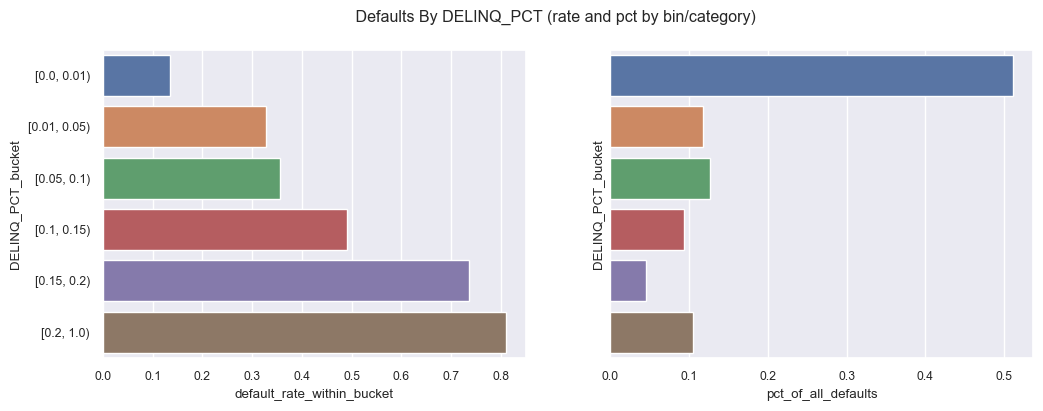

In [101]:
delinqpct_dist.plot_defaults()

Observations

* The % of bad credit lines for a given borrower varies from 0 to almost 80%
* 77% of borrowers have no delinquencies on their current lines, 85% have less than 5%, and 92% have less than 10%.
* There is a clear positive correlation between percentage of delinquencies and probability of default on the loan meaning this factor is likely to have good explanatory power (similar to DELINQ but this factor is normalized)

#### Summary Table

In [102]:
# # Numeric Cols
cols_num2 = ['LOAN', 'VALUE', 'MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'NINQ', 'CLNO', 'DEBTINC', 'MISSPCT', 'LTV', 'LTV_ADJ', 'LTMORT', 'DELINQ_PCT']


In [103]:
features_summary(d1, cols=cols_num2)


BAD                0_mean        1_mean    diff_mean  diff_mean_pct  \
LOAN         19028.107315  16922.119428 -2105.987887      -0.124452   
VALUE       102595.921018  98172.846227 -4423.074791      -0.045054   
MORTDUE      74829.249055  69460.452973 -5368.796082      -0.077293   
YOJ              9.154941      8.027802    -1.127138      -0.140404   
DEROG            0.134217      0.707804     0.573587       0.810376   
DELINQ           0.245133      1.229185     0.984053       0.800573   
NINQ             1.032749      1.782765     0.750016       0.420704   
CLNO            21.317036     21.211268    -0.105768      -0.004986   
DEBTINC         33.253129     39.387645     6.134516       0.155747   
MISSPCT          0.071893      0.114535     0.042642       0.372307   
LTV              0.711535      0.695211    -0.016323      -0.023479   
LTV_ADJ          0.920530      0.885760    -0.034770      -0.039254   
LTMORT           0.390931      0.366741    -0.024189      -0.065957   
DELINQ_PCT       0.011830      0.064005     0.052176       0.815178   

BAD             0_median      1_median  diff_median  diff_median_pct  
LOAN        16900.000000  14900.000000 -2000.000000        -0.134228  
VALUE       90659.000000  82000.000000 -8659.000000        -0.105598  
MORTDUE     66839.000000  60279.000000 -6560.000000        -0.108827  
YOJ             7.000000      6.000000    -1.000000        -0.166667  
DEROG           0.000000      0.000000     0.000000              NaN  
DELINQ          0.000000      0.000000     0.000000              NaN  
NINQ            1.000000      1.000000     0.000000         0.000000  
CLNO           20.000000     20.000000     0.000000         0.000000  
DEBTINC        34.541671     38.079762     3.538090         0.092913  
MISSPCT         0.000000      0.090909     0.090909         1.000000  
LTV             0.718284      0.719165     0.000881         0.001225  
LTV_ADJ         0.907428      0.897360    -0.010068        -0.011219  
LTMORT          0.232758      0.235582     0.002824         0.011989  
DELINQ_PCT      0.000000      0.000000     0.000000              NaN

### **Multivariate Analysis**

#### Correlations

As the dataset includes more than 10 features, the number of pairwise relationships to analyze is quite important. In order to narrow down potentially interesting relationships, let's have a look at correlations first, then pairplots.

In [104]:
# Instantiate Correlation Analyzer
cor = CorrelAnalyzer(data=d1)

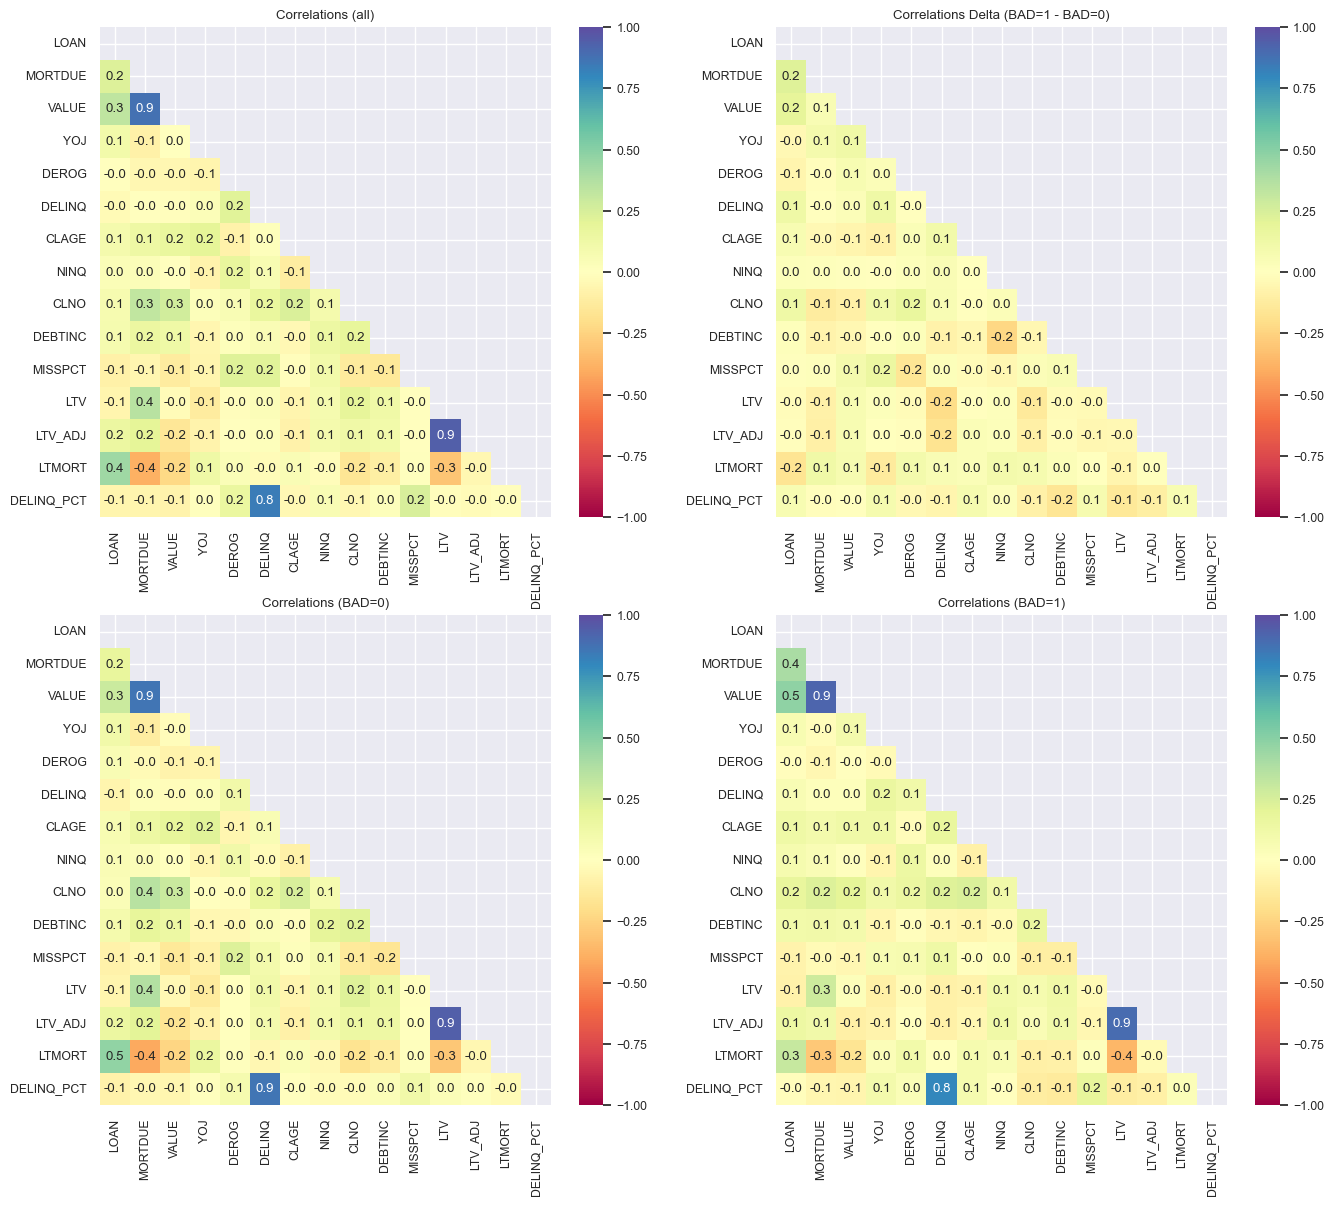

In [105]:
# Show correlation heatmaps (all, BAD=0 and BAD=1)
cor.plot_correl()

In [106]:
# Extract largest (abs) correlations - all
cor.correl_top(filter_bad=None, filter=0.35)

LTV      LTV_ADJ       0.937528
MORTDUE  VALUE         0.875666
DELINQ   DELINQ_PCT    0.842394
LOAN     LTMORT        0.435210
MORTDUE  LTV           0.357336
         LTMORT       -0.384545
dtype: float64

In [107]:
# Extract largest (abs) correlations - BAD=0
cor.correl_top(filter_bad=0, filter=0.35)

LTV      LTV_ADJ       0.941808
DELINQ   DELINQ_PCT    0.865827
MORTDUE  VALUE         0.863744
LOAN     LTMORT        0.470222
MORTDUE  LTV           0.374687
         CLNO          0.353813
         LTMORT       -0.412570
dtype: float64

In [108]:
# Extract largest (abs) correlations - BAD=1
cor.correl_top(filter_bad=1, filter=0.35)

MORTDUE  VALUE         0.918633
LTV      LTV_ADJ       0.895557
DELINQ   DELINQ_PCT    0.797314
LOAN     VALUE         0.481126
         MORTDUE       0.400038
LTV      LTMORT       -0.364981
dtype: float64

Observations

* Correlations are generally very low (most are under 0.3)
* Excluding the new features introduced, the only relationship standing out is MORTDUE vs VALUE (correlation = 88%). That is hardly surprising as the mortgage is calculated as a % of value (the relationship deviates in time in though as the mortgage is being paid off). We might want to remove one of these features later on (MORTDUE might be more interesting to keep as it contributes to the overall debt level and we're trying to predict defaults)
* Among the "additonal" features, we can observe:
    * DELINQ vs DELINQ_PCT: 84% correlation - again not surprising but one could have expected an even higher correlation so the normalization might be useful
    * LTV vs LTV_ADJ: 94% correlation (expected, the only dfference is the addition of the loan which is on avg about 20% of MORTDUE)
    * LOAN vs LTMORT: 43% correlation
* The delta between correlations within the BAD=0 and BAD=1 subsets are not major. One of main differences concerns the correlation between 1) LOAN-MORTDUE and 2) LOAN-VALUE, which are about 20% higher among defaulted loans.
* Correlations might be affected by outliers - let's have a look at scatter plots and check whether we can extract more insight

#### Pairplots, Scatterplots and LMplots

##### Pairplots

As explained above the dataset contains 10+ variables - let's plot all relationhips, eyeball the interesting ones and zoom in on some specific relationships with scatterplots and LMplots

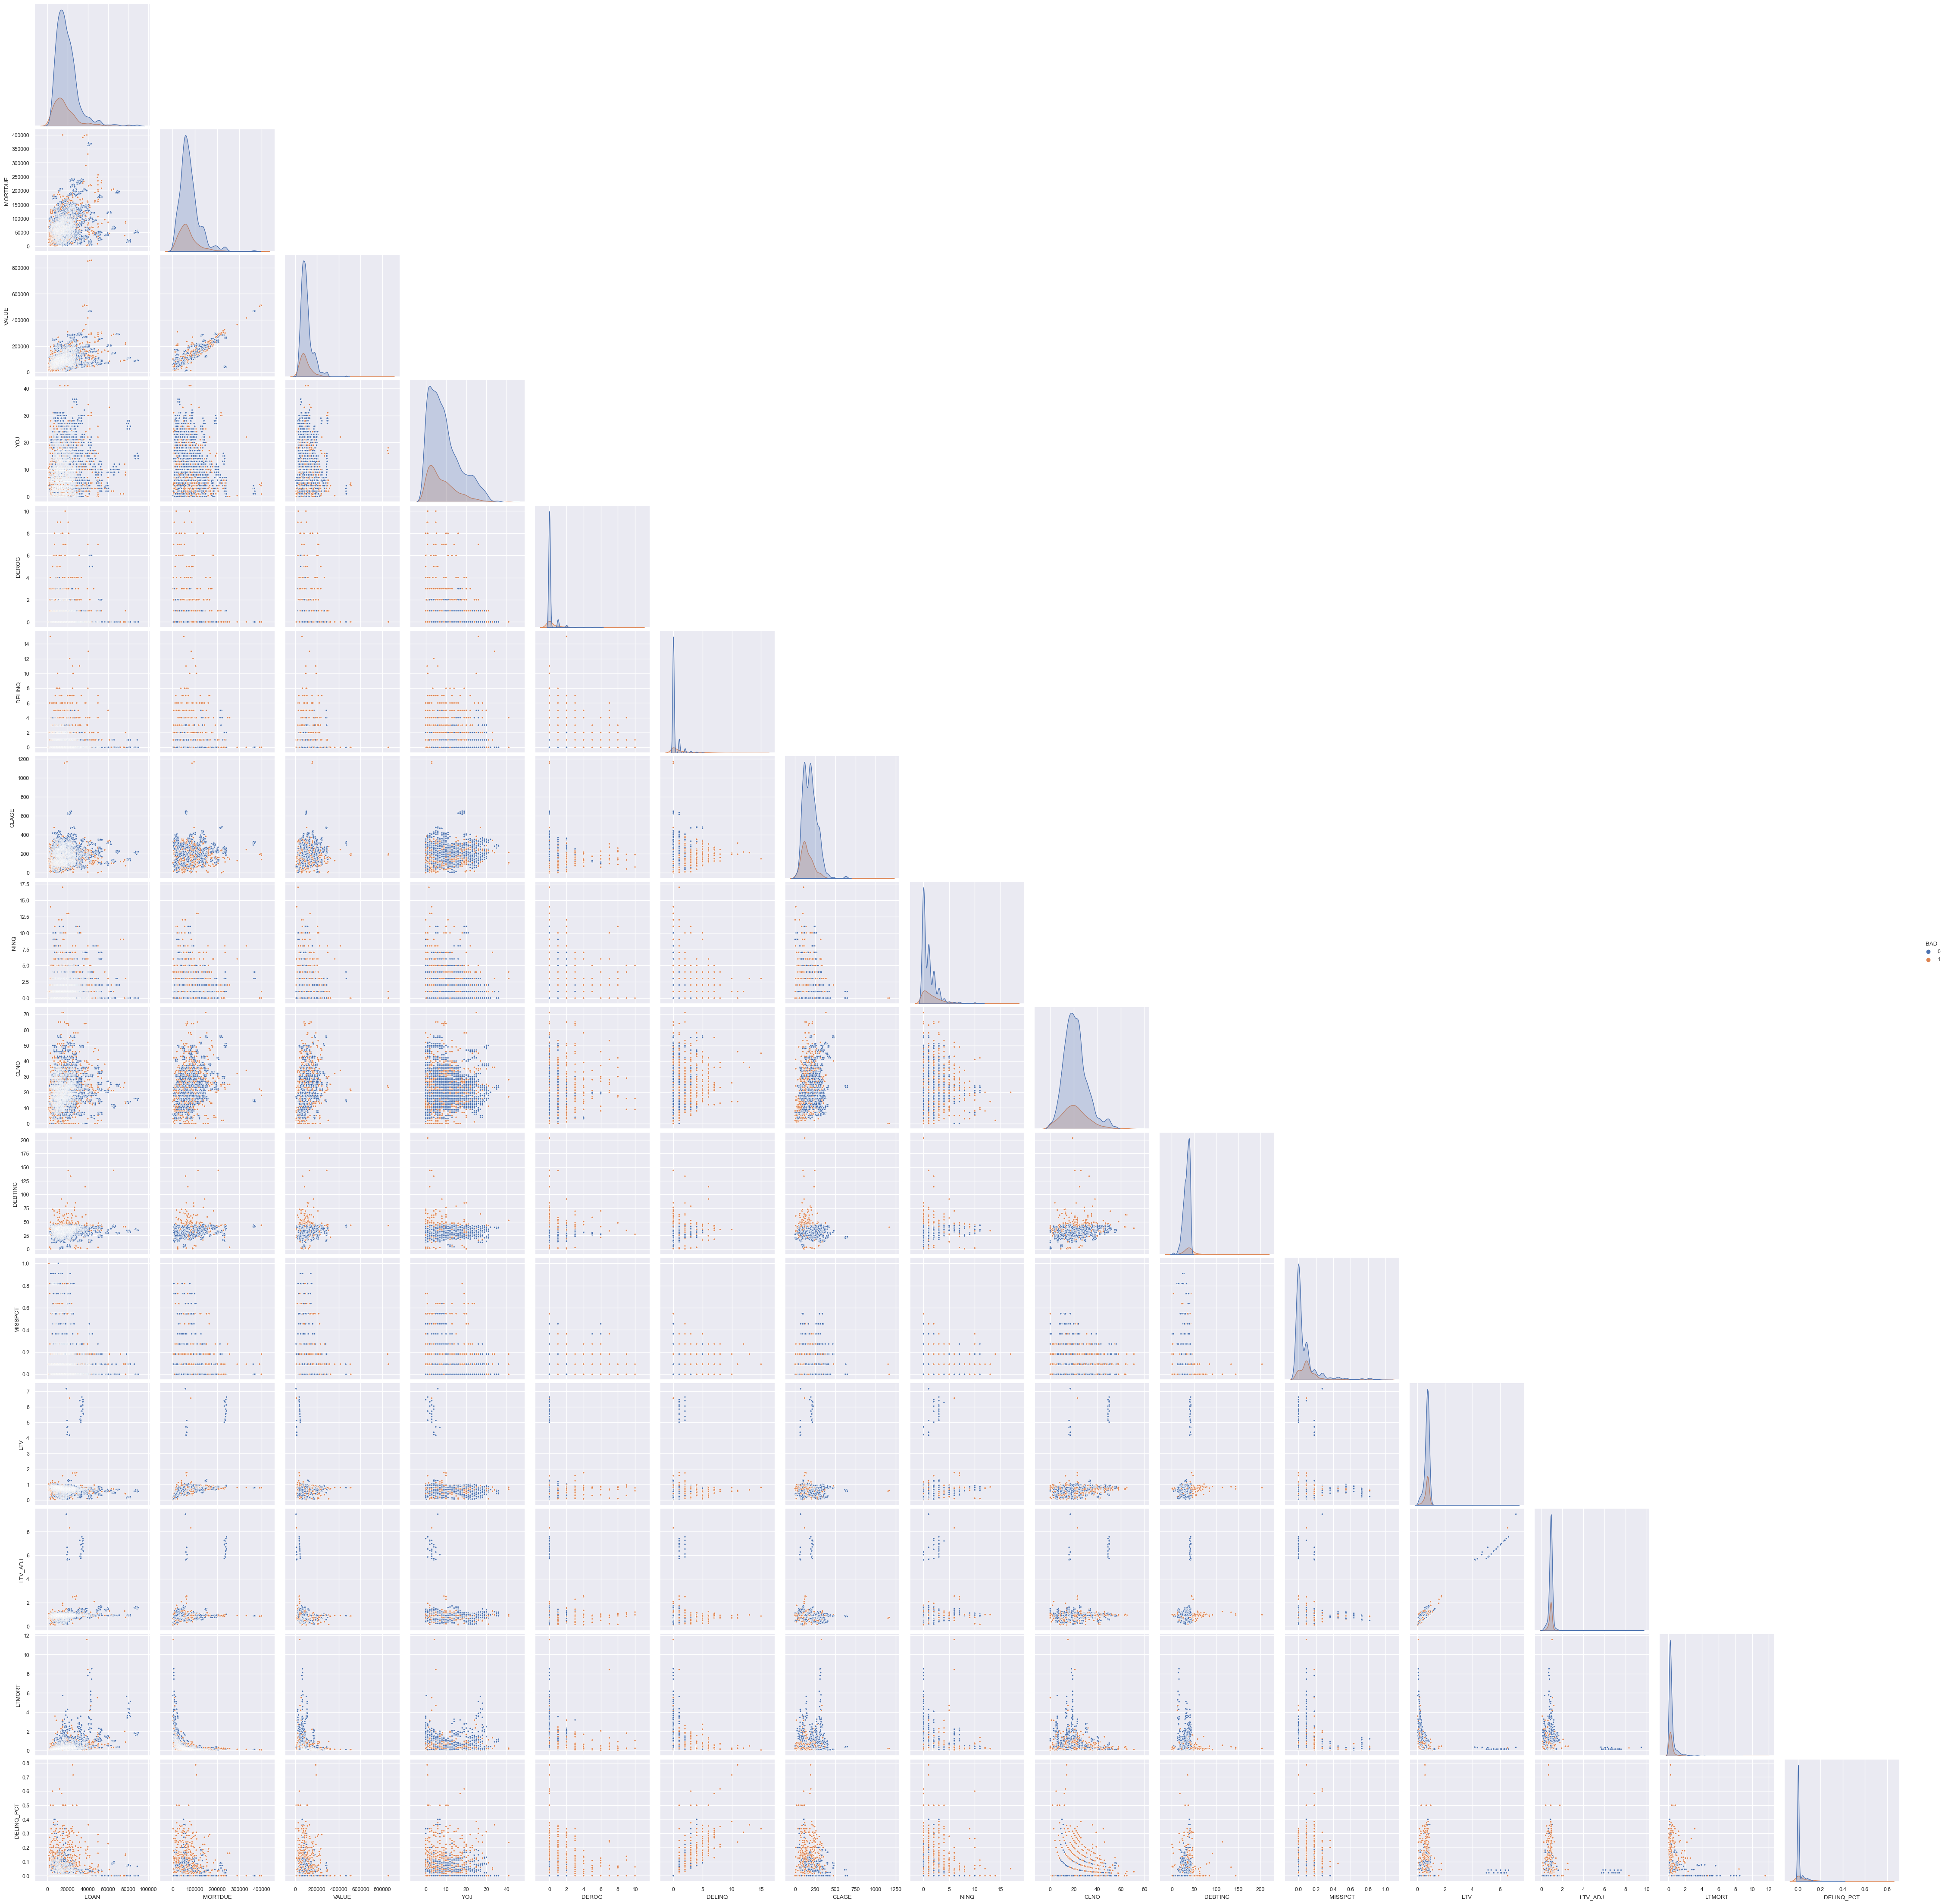

In [109]:
# Pairplots (note: takes 1min - disable when not required)
sns.pairplot(d1, hue='BAD', corner=True, plot_kws=dict(marker="."), height=3)


##### DEBTINC relationships

This feature looks interesting as pairplots show a number of clusters. 

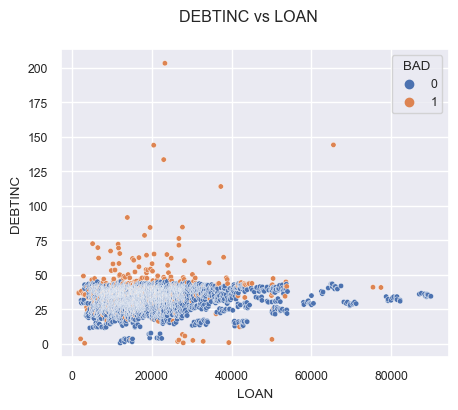

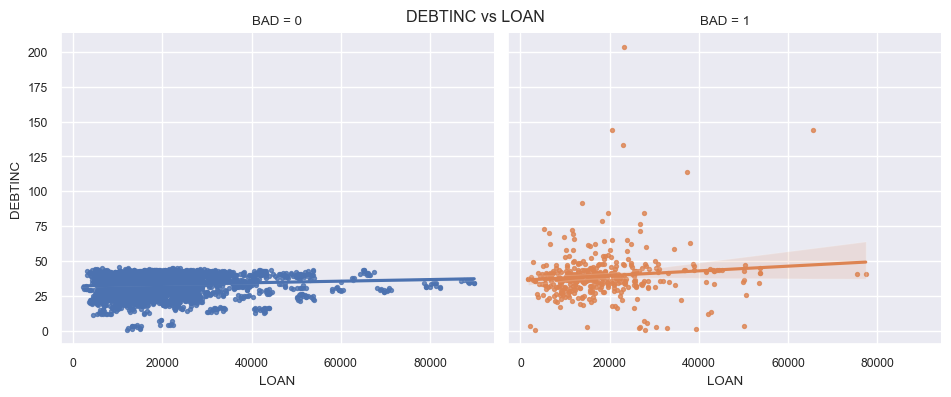

In [110]:
debtinc_dist.plot_scatter(vs_feature='LOAN')
debtinc_dist.plot_lm(vs_feature='LOAN') 

Observations

* NONE of the defaulted loans have a DEBTINC ratio > 50%

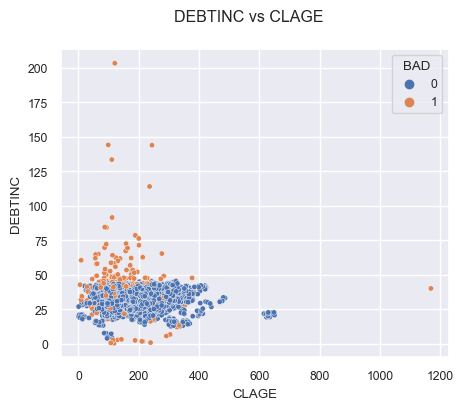

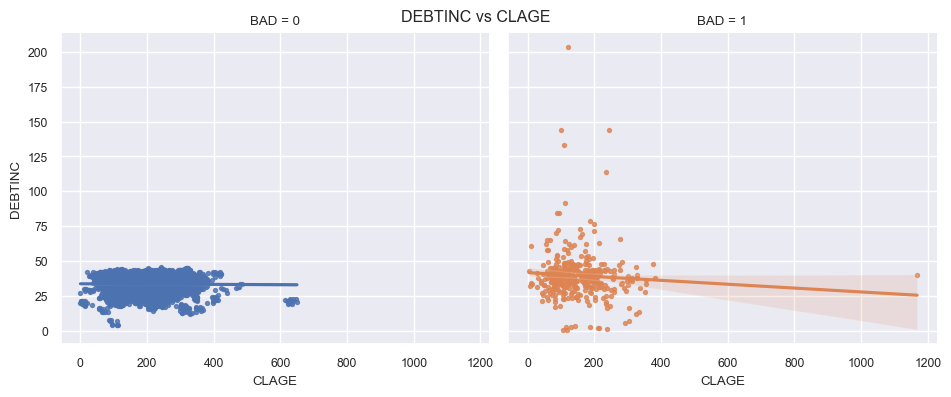

In [111]:
debtinc_dist.plot_scatter(vs_feature='CLAGE')
debtinc_dist.plot_lm(vs_feature='CLAGE')

### **Important Insights from EDA**

* Average loan size is 19k
* Average Default Rate is 20% (whole dataset)
* Loan size is about 40% of mortgage due on average (median 20%), which is substantial
* Average LTV is 70% on average (Mortgage Due / Value) and ~90% including the Home Equity Loan, meaning the lender is not heavily collateralized (likely to incur losses if property value revised lower for instance)
* Average number of credit lines is 21 (high)
* Average Debt to Income is 34% which feels reasonable. No borrower with a debt/income ratio < 50% defaulted. However this ratio is missing in more than 20% of cases and the conditional default rate (when information is missing) is extremely high - above 60% (3x average).
* Applications with <i>any</i> missing data generally exhibit a much higher rate of default - 34% vs 9% for complete applications.
* There are positive relationhips between 1) default rate and 2) number of derogatory reports, delinquencies or inquiries. In other terms existing credit difficulties are likely to repeat.
* There is a negative relationship between default rate and the age of the borrower's oldest credit line. 
* The reason for the loan, job or year on job seem to have little influence in terms of default rate

<a id=ml></a>
## **Machine Learning Models**

### **Introduction**

We are trying to predict whether a loan, given the information provided by the borrower, is likely to default or not. The output being a Yes/No label, we'll run different <strong>classification models</strong> and try to optimize their performance. The optimization criteria in that case will be the <strong> recall </strong> metric because we're trying to minimize the default rate, or in other terms, maximize the proportion of correct detections among defaulted loans (ie True Positive / (True Positive + False Negative]).


### **Useful Classes and Functions**

The 'DataPrepartion' class will be used to transform data prior to ML modelling. The class includes methods to manage outliers, missing data, encoding etc (basic version of the Pycaret setup function). It will be useful to create several datasets with different pre-modelling configurations (different outlier management, feature engineering / encoding etc). 

In [112]:
class DataPreparation:

    def __init__(self, data):

        self.data = data
        self.data_stats = DataOverview(self.data).get_describe()
        self.output = self.data.copy()
        self.output_stats = DataOverview(self.output).get_describe()
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None     

    def manage_outliers(self, cols=None, mode='IQR', stdev_multiplier=1.5):

        """
        Definition:     clips outliers and forces them to quartile +/-  IQR * stdev_multiplier
        ToDo:           add option to remove outliers altogether?            
        """
        
        if cols is None:
            # select all numeric cols
            cols_to_apply = list(self.output.select_dtypes(include=np.number).columns)
            cols_to_apply.remove('BAD')
        else:
            # use custom list
            cols_to_apply = cols

        for c in cols_to_apply:

            q1 = self.output_stats['25%'][c]
            q3 = self.output_stats['75%'][c]
            IQR = q3 - q1
            std = self.output_stats['std'][c]
            
            lower_whisker = q1 - stdev_multiplier * IQR
            upper_whisker = q3 + stdev_multiplier * IQR

            self.output[c] = np.clip(self.output[c], lower_whisker, upper_whisker)
        
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output

    def convert_types(self):
        # convert object to categorical
        pass

    def add_custom_feature(self, feature_to_add=None):

        if feature_to_add == 'MISSPCT':
            self.output['MISSPCT'] = self.output.isna().sum(1) / 11
        elif feature_to_add == 'LTV':
            self.output['LTV'] = self.output['MORTDUE'] / self.output['VALUE']
        elif feature_to_add == 'LTV_ADJ':
            self.output['LTV_ADJ'] = (self.output['LOAN'] + self.output['MORTDUE']) / self.output['VALUE']
            #self.output['LTV_ADJ'] = self.output.apply(lambda x: (x['LOAN'] + x['MORTDUE']) / x['VALUE'] if x['VALUE'] > 0 else np.nan, axis=1)
        elif feature_to_add == 'LTMORT':
            self.output['LTMORT'] = self.output['LOAN'] / self.output['MORTDUE']
        elif feature_to_add == 'DELINQ_PCT':
            self.output['DELINQ_PCT'] = self.output.apply(lambda x: x['DELINQ'] / x['CLNO'] if x['CLNO'] > 0 else None, axis=1) 
        else:
            pass

        self.output_stats = DataOverview(self.output).get_describe()

        return self.output

    def add_missing_flags(self, cols=[]):
        
        """"
        Description:    for each column in cols, create a new column with a missing (True/False) flag
                        will be used to assess if missing data in any column is an important factor
        """ 

        for c in cols:
            
            new_col = str(c) + '_is_missing'
            self.output[new_col] = self.output[c].isna()
            
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output

    def drop_cols(self, cols=[]):

        self.output.drop(columns=cols, axis=1, inplace=True)

        self.output_stats = DataOverview(self.output).get_describe()
        print(self.output_stats)

        return self.output

    def manage_missing_num(self, cols=None):

        if cols is None:
            # select all numeric cols
            cols_to_apply = list(self.output.select_dtypes(include=np.number).columns)
        else:
            # use custom list
            cols_to_apply = cols

        for c in cols_to_apply:
            
            median = self.output_stats['50%'][c]
            self.output[c].fillna(value=median, inplace=True, axis=0)
            
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output

    def manage_missing_cat(self, cols=None, use_mode=True, value='*UNKNOWN*'):
        
        if cols is None:
            # select all cat cols
            cols_to_apply = list(self.output.select_dtypes(include=['category', 'string', 'object']).columns)
        else:
            # use custom list
            cols_to_apply = cols
        
        for c in cols_to_apply:
            
            # set override value
            override = self.output[c].mode()[0] if use_mode else value

            # fill
            self.output[c].fillna(value=override, inplace=True)
    
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output

    def scale(self, cols=None, exclude_BAD=True):
        
        sc = StandardScaler()

        # select columns to which the scaler should be applied
        if cols is None:
            # select all numeric cols
            cols_to_apply = list(self.output.select_dtypes(include=np.number).columns)
            # remove 'BAD' if necessary
            cols_to_apply.remove('BAD')
        else:
            # use custom list
            cols_to_apply = cols

        # scale required cols and convert to df
        x = self.output[cols_to_apply]
        x_scaled = sc.fit_transform(x)
        x_scaled = pd.DataFrame(x_scaled, columns = x.columns)

        # merge with non-scaled cols
        cols_ignored = [c for c in self.output.columns if c not in cols_to_apply]
        x_notscaled = self.output[cols_ignored]

        self.output = x_scaled.merge(x_notscaled, how='inner', left_index=True, right_index=True)
        
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output
    
    def factorize(self, cols=['REASON','JOB']):

        for c in cols:
            self.output[c] = pd.factorize(self.output[c])[0]
        
        self.output_stats = DataOverview(self.output).get_describe()

        return self.output
    
    def encode(self, cols=None):
        # one hot encoding
        # use get_dummies
        pass

    def reset_changes(self):

        self.__init__(self.data)

    def partition_data(self, test_size = 0.3, random_state=1):

        # should be final step

        x = self.output.drop(columns='BAD')
        y = self.output['BAD']
                
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test  

        return x_train, x_test, y_train, y_test

In [113]:
class ModelPerf:

    # continue ...

    def __init__(self, actual, predicted, features):

        self.actual = actual
        self.predicted = predicted
        self.features = features
        self.classification_report = classification_report(self.actual, self.predicted)
        self.confusion_matrix = confusion_matrix(self.actual, self.predicted)

    def perf_report(self, title="CLASSIFICATION REPORT", show_cm=True):

        """
        print performance report
        """

        # header
        print("-"*55)
        print(title)
        print("\n")

        # classification report
        print(self.classification_report)
    
        # confusion matrix
        if show_cm:  
            plt.figure(figsize = (3, 2))
            sns.heatmap(self.confusion_matrix, annot = True,  fmt = '.0f', xticklabels = [0, 1], yticklabels = [0, 1])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title('Confusion Matrix')
            plt.show()
        
    def plot_importance(self, estimator, features):

        """
        param estimator:    tree/model
        param features:     features
        """
        
        importances = estimator.feature_importances_
        columns = features.columns
        importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
        plt.figure(figsize = (12, 4))
        sns.barplot(x=importance_df.Importance,y=importance_df.index)

In [114]:
class ModelPerfTrees:

    # for DT and RF

    def __init__(self, model, x_train, y_train, x_test, y_test):

        self.model= model       # DT or RF - MUST BE ALREADY FITTED

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        # predict train and get scores
        self.y_train_predicted = self.predict(x_data=x_train)
        self.recall_train = metrics.recall_score(y_train, self.y_train_predicted)
        self.precision_train = metrics.precision_score(y_train, self.y_train_predicted)
        self.accuracy_train = metrics.accuracy_score(y_train, self.y_train_predicted)
        self.f1_score_train = metrics.f1_score(y_train, self.y_train_predicted)

        # predict test and get scores
        self.y_test_predicted = self.predict(x_data=x_test)
        self.recall_test = metrics.recall_score(y_test, self.y_test_predicted)
        self.precision_test = metrics.precision_score(y_test, self.y_test_predicted)
        self.accuracy_test = metrics.accuracy_score(y_test, self.y_test_predicted)
        self.f1_score_test = metrics.f1_score(y_test, self.y_test_predicted)

        # store scores in dict
        self.scores = {
            'recall_train':     self.recall_train,
            'precision_train':  self.precision_train,
            'accuracy_train':   self.accuracy_train,
            'f1_train':         self.f1_score_train,

            'recall_test':      self.recall_test,
            'precision_test':   self.precision_test,
            'accuracy_test':    self.accuracy_test,
            'f1_test':          self.f1_score_test
        }

        # classification reports
        self.classification_report_train = classification_report(self.y_train, self.y_train_predicted)
        self.classification_report_test = classification_report(self.y_test, self.y_test_predicted)
        
        # confusion matrix
        self.confusion_matrix_train = confusion_matrix(self.y_train, self.y_train_predicted)
        self.confusion_matrix_test = confusion_matrix(self.y_test, self.y_test_predicted)


    def predict(self, x_data):

        predicted = self.model.predict(x_data)

        return predicted

    def scores_summary(self, index=['Decision Tree (Tuned)']):
        
        # scores in df
        self.scores_df = pd.DataFrame(data=self.scores, index=index).round(2)
        
        return self.scores_df

    def perf_analysis(self, title="CLASSIFICATION REPORT", show_cm=True):

        """
        print performance report
        """

        # header
        print("-"*55)
        print("CLASSIFICATION REPORT (Train data)")
        print("\n")

        # classification report
        print(self.classification_report_train)
    
        # confusion matrix
        if show_cm:  
            plt.figure(figsize = (3, 2))
            sns.heatmap(self.confusion_matrix_train, annot = True,  fmt = '.0f', xticklabels = [0, 1], yticklabels = [0, 1])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title('Confusion Matrix')
            plt.show()

        # header
        print("-"*55)
        print("CLASSIFICATION REPORT (Test data)")
        print("\n")

        # classification report
        print(self.classification_report_test)
    
        # confusion matrix
        if show_cm:  
            plt.figure(figsize = (3, 2))
            sns.heatmap(self.confusion_matrix_test, annot = True,  fmt = '.0f', xticklabels = [0, 1], yticklabels = [0, 1])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title('Confusion Matrix')
            plt.show()
        
    def feature_importance(self):
        
        importances = self.model.feature_importances_
        columns = self.x_train.columns
        importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
        plt.figure(figsize = (12, 4))
        sns.barplot(x=importance_df.Importance,y=importance_df.index)

In [115]:
class MyLogisticRegression:

    def __init__(self, x_train, y_train, x_test, y_test, penalty='l2', solver='lbfgs'):

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.penalty = penalty
        self.solver = solver

        # instantiate 
        self.lg = LogisticRegression(penalty=penalty, solver=solver)
    
        # fit model to train data
        self.lg.fit(x_train, y_train)

        # predict train and get scores
        self.y_train_predicted = self.predict(x_data=x_train)
        
        self.recall_train = metrics.recall_score(y_train, self.y_train_predicted)
        self.precision_train = metrics.precision_score(y_train, self.y_train_predicted)
        self.accuracy_train = metrics.accuracy_score(y_train, self.y_train_predicted)
        self.f1_train = metrics.f1_score(y_train, self.y_train_predicted)

        # predict test and get scores
        self.y_test_predicted = self.predict(x_data=x_test)
        
        self.recall_test = metrics.recall_score(y_test, self.y_test_predicted)
        self.precision_test = metrics.precision_score(y_test, self.y_test_predicted)
        self.accuracy_test = metrics.accuracy_score(y_test, self.y_test_predicted)
        self.f1_test = metrics.f1_score(y_test, self.y_test_predicted)

        # store scores in dict
        self.scores = {
            'recall_train':self.recall_train,
            'precision_train': self.precision_train,
            'accuracy_train': self.accuracy_train,
            'f1_train': self.f1_train,
            'recall_test': self.recall_test,
            'precision_test': self.precision_test,
            'accuracy_test': self.accuracy_test,
            'f1_test': self.f1_test
        }

        self.scores_df = pd.DataFrame(data=self.scores, index=['Logistic Regression']).round(2)

    def predict(self, x_data):

        predicted = self.lg.predict(x_data)

        return predicted
    
    def perf_analysis(self, show_cm=True, show_feature_importance=True):

        # performance on train data
        mp_train = ModelPerf(actual=self.y_train, predicted=self.y_train_predicted, features=self.x_train)
        mp_train.perf_report(title="CLASSIFICATION REPORT (TRAIN data)", show_cm=show_cm)

        # performance on test data
        mp_test = ModelPerf(actual=self.y_test, predicted=self.y_test_predicted, features=self.x_test)
        mp_test.perf_report(title="CLASSIFICATION REPORT (TEST data)", show_cm=show_cm)

        # feature importance
        coef = self.lg.coef_[0]
        feature_importance = pd.DataFrame({'Feature': self.x_train.columns, 'Importance': np.abs(coef)})
        feature_importance.sort_values(by='Importance', ascending=True, inplace=True)
        if show_feature_importance:
            feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8,4), title="Feaure Importance")



In [116]:
class DTAnalyzer:
    
    # TO DO: CONTINUE

    def __init__(self, dt, x_train, y_train, x_test, y_test):

        self.dt = dt
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def fit(self, criterion='entropy', max_depth=5, min_no_samples_per_leaf = 1):
        
        # hyperparameters
        # criterion: entropy | gini | information gain
        # max_depth
        # min_no_samples_per_leaf

        # create a decision tree model (classifier as we're predicting a 0/1 label) 
        dt_current = tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_no_samples_per_leaf=min_no_samples_per_leaf)

        # fit the model to the training data
        dt_current = dt_current.fit(self.x_train, self.y_train)

        # predict train
        self.y_train_predicted = dt_current.predict(x_data=x_train)

        # predict test
        self.y_test_predicted = self.predict(x_data=x_test)

    def tune_tree(self):
        pass

    def predict(self, tree, x_data):

        return self.predict(x_data)
    
    def perf_analysis(self, show_cm=True, show_feature_importance=True):

        # performance on train data
        mp_train = ModelPerf(actual=self.y_train, predicted=self.y_train_predicted, features=self.x_train)
        mp_train.perf_report(title="CLASSIFICATION REPORT (TRAIN data)", show_cm=show_cm)

        # performance on test data
        mp_test = ModelPerf(actual=self.y_test, predicted=self.y_test_predicted, features=self.x_test)
        mp_test.perf_report(title="CLASSIFICATION REPORT (TEST data)", show_cm=show_cm)

        # feature importance
        coef = self.lg.coef_[0]
        feature_importance = pd.DataFrame({'Feature': self.x_train.columns, 'Importance': np.abs(coef)})
        feature_importance.sort_values(by='Importance', ascending=True, inplace=True)
        if show_feature_importance:
            feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8,4), title="Feaure Importance")

In [117]:
def perf_report(actual, predicted):
    
    print("-"*55)
    
    print("CLASSIFICATION REPORT\n")
    print(classification_report(actual, predicted))
    
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (3, 2))
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = [0, 1], yticklabels = [0, 1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [118]:
def plot_tree(t, features):
    
    fig, ax = plt.subplots(figsize = (40, 12))
    out = tree.plot_tree(t, fontsize = 9, max_depth = 5, impurity = False, filled = True, feature_names = list(features.columns), class_names = None)

    for o in out:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('red')
            arrow.set_linewidth(3)

    # Display the plot       
    plt.show()

In [119]:
def plot_importance(t, features):
    """
    param t: tree/model
    param x: features
    """
    importances = t.feature_importances_
    columns = features.columns
    importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
    plt.figure(figsize = (12, 4))
    sns.barplot(x=importance_df.Importance,y=importance_df.index)

### **Data Preparation**

This section includes multiple datasets, each one being processed in a specific way using the DataPreparation class. They are later used in the data modelling section for testing purposes. The models shown will ultimately use only one dataset (the pre-processing being part of the overall pipeline).

In [120]:
# DATASET 0 (ds0)
# Description: no processing (benchmark) 

# Manage Outliers:      0
# Add Missing Flags:    0
# Fill Missing Num:     0
# Scale:                0
# Factorize Cat:        0
# Additional Cols:      NONE

ds0 = DataPreparation(d0)

In [121]:
# DATASET 1 (ds1)
# Description: 

# Manage Outliers:      1
# Add Missing Flags:    0
# Fill Missing Num:     1
# Fill Missing Cat:     1 (with 'unknown')
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      ALL (derived from d1)

ds1 = DataPreparation(d1)
ds1.manage_outliers(stdev_multiplier=1.5)      # Step 1: outliers
ds1.manage_missing_num()                       # Step 2: missing data
ds1.scale()                                    # Step 3: scaling
ds1.factorize()                                # Step 4: factorize categorical data
ds1.partition_data()                           # Step 5: partition

ds1.output

LOAN   MORTDUE     VALUE       YOJ  DEROG  DELINQ     CLAGE  \
0    -1.832283 -1.268083 -1.328686  0.251171    0.0     0.0 -1.071599   
1    -1.810666 -0.026523 -0.670929 -0.240303    0.0     0.0 -0.721212   
2    -1.789048 -1.615326 -1.828581 -0.661566    0.0     0.0 -0.368698   
3    -1.789048 -0.167948 -0.204386 -0.240303    0.0     0.0 -0.062534   
4    -1.767431  0.753003  0.305350 -0.801987    0.0     0.0 -1.084781   
...        ...       ...       ...       ...    ...     ...       ...   
5955  2.545249 -0.385818 -0.183125  1.023488    0.0     0.0  0.554157   
5956  2.545249 -0.461334 -0.121503  1.023488    0.0     0.0  0.386830   
5957  2.545249 -0.476252 -0.121794  0.883067    0.0     0.0  0.432597   
5958  2.545249 -0.579498 -0.145596  0.742645    0.0     0.0  0.453174   
5959  2.545249 -0.623297 -0.211137  0.883067    0.0     0.0  0.525994   

          NINQ      CLNO   DEBTINC   MISSPCT       LTV   LTV_ADJ    LTMORT  \
0    -0.065054 -1.297476  0.140949  0.408393 -0.249434 -1.850277 -1.382647   
1    -0.826792 -0.756608  0.140949  0.408393  2.341467  1.328197 -1.517255   
2    -0.065054 -1.189302  0.140949  0.408393  0.794991  0.020401 -0.997706   
3    -0.065054 -0.107566  0.140949  2.165386  0.153405  0.072972 -0.311535   
4    -0.826792 -0.756608  0.140949  0.408393  1.259622 -0.068103 -1.523850   
...        ...       ...       ...       ...       ...       ...       ...   
5955 -0.826792 -0.540260  0.344808 -0.762936 -0.447887  2.285531  2.264156   
5956 -0.826792 -0.648434  0.305051 -0.762936 -0.789922  2.285531  2.264156   
5957 -0.826792 -0.648434  0.257259 -0.762936 -0.830287  2.285531  2.264156   
5958 -0.826792 -0.540260  0.065746 -0.762936 -1.068768  2.285531  2.264156   
5959 -0.826792 -0.540260  0.102079 -0.762936 -1.065065  2.285531  2.264156   

      DELINQ_PCT  BAD  REASON  JOB  
0            0.0    1       0    0  
1            0.0    1       0    0  
2            0.0    1       0    0  
3            0.0    1       1    1  
4            0.0    0       0    2  
...          ...  ...     ...  ...  
5955         0.0    0       2    0  
5956         0.0    0       2    0  
5957         0.0    0       2    0  
5958         0.0    0       2    0  
5959         0.0    0       2    0  

[5960 rows x 18 columns]

In [122]:
# DATASET 2 (ds2)
# Description: 

# Manage Outliers:      1
# Add Missing Flags:    0
# Fill Missing Num:     1
# Fill Missing Cat:     1 
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      NONE

ds2 = DataPreparation(d0)
ds2.manage_outliers(stdev_multiplier=1.5)      # Step 1: outliers
ds2.manage_missing_num()                       # Step 2: missing data (num)
ds2.manage_missing_cat()                       # Step 3: missing data (num)
ds2.scale()                                    # Step 4: scaling
ds2.factorize()                                # Step 5: factorize categorical data
ds2.partition_data()                           # Step 6: partition

ds2.output

LOAN   MORTDUE     VALUE       YOJ  DEROG  DELINQ     CLAGE  \
0    -1.832283 -1.268083 -1.328686  0.251171    0.0     0.0 -1.071599   
1    -1.810666 -0.026523 -0.670929 -0.240303    0.0     0.0 -0.721212   
2    -1.789048 -1.615326 -1.828581 -0.661566    0.0     0.0 -0.368698   
3    -1.789048 -0.167948 -0.204386 -0.240303    0.0     0.0 -0.062534   
4    -1.767431  0.753003  0.305350 -0.801987    0.0     0.0 -1.084781   
...        ...       ...       ...       ...    ...     ...       ...   
5955  2.545249 -0.385818 -0.183125  1.023488    0.0     0.0  0.554157   
5956  2.545249 -0.461334 -0.121503  1.023488    0.0     0.0  0.386830   
5957  2.545249 -0.476252 -0.121794  0.883067    0.0     0.0  0.432597   
5958  2.545249 -0.579498 -0.145596  0.742645    0.0     0.0  0.453174   
5959  2.545249 -0.623297 -0.211137  0.883067    0.0     0.0  0.525994   

          NINQ      CLNO   DEBTINC  BAD  REASON  JOB  
0    -0.065054 -1.297476  0.140949    1       0    0  
1    -0.826792 -0.756608  0.140949    1       0    0  
2    -0.065054 -1.189302  0.140949    1       0    0  
3    -0.065054 -0.107566  0.140949    1       1    0  
4    -0.826792 -0.756608  0.140949    0       0    1  
...        ...       ...       ...  ...     ...  ...  
5955 -0.826792 -0.540260  0.344808    0       1    0  
5956 -0.826792 -0.648434  0.305051    0       1    0  
5957 -0.826792 -0.648434  0.257259    0       1    0  
5958 -0.826792 -0.540260  0.065746    0       1    0  
5959 -0.826792 -0.540260  0.102079    0       1    0  

[5960 rows x 13 columns]

In [123]:
# DATASET 3 (ds3)
# Description: 

# Manage Outliers:      1
# Add Missing Flags:    1
# Fill Missing Num:     1
# Fill Missing Cat:     1 
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      NONE

ds3 = DataPreparation(d0)
ds3.manage_outliers(stdev_multiplier=1.5)      
ds3.add_missing_flags(cols=['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON', 'JOB'])
ds3.manage_missing_num()                       
ds3.manage_missing_cat()                       
ds3.scale()                                    
ds3.factorize()                                
ds3.partition_data()                           

ds3.output

LOAN   MORTDUE     VALUE       YOJ  DEROG  DELINQ     CLAGE  \
0    -1.832283 -1.268083 -1.328686  0.251171    0.0     0.0 -1.071599   
1    -1.810666 -0.026523 -0.670929 -0.240303    0.0     0.0 -0.721212   
2    -1.789048 -1.615326 -1.828581 -0.661566    0.0     0.0 -0.368698   
3    -1.789048 -0.167948 -0.204386 -0.240303    0.0     0.0 -0.062534   
4    -1.767431  0.753003  0.305350 -0.801987    0.0     0.0 -1.084781   
...        ...       ...       ...       ...    ...     ...       ...   
5955  2.545249 -0.385818 -0.183125  1.023488    0.0     0.0  0.554157   
5956  2.545249 -0.461334 -0.121503  1.023488    0.0     0.0  0.386830   
5957  2.545249 -0.476252 -0.121794  0.883067    0.0     0.0  0.432597   
5958  2.545249 -0.579498 -0.145596  0.742645    0.0     0.0  0.453174   
5959  2.545249 -0.623297 -0.211137  0.883067    0.0     0.0  0.525994   

          NINQ      CLNO   DEBTINC  ...  VALUE_is_missing  YOJ_is_missing  \
0    -0.065054 -1.297476  0.140949  ...             False           False   
1    -0.826792 -0.756608  0.140949  ...             False           False   
2    -0.065054 -1.189302  0.140949  ...             False           False   
3    -0.065054 -0.107566  0.140949  ...              True            True   
4    -0.826792 -0.756608  0.140949  ...             False           False   
...        ...       ...       ...  ...               ...             ...   
5955 -0.826792 -0.540260  0.344808  ...             False           False   
5956 -0.826792 -0.648434  0.305051  ...             False           False   
5957 -0.826792 -0.648434  0.257259  ...             False           False   
5958 -0.826792 -0.540260  0.065746  ...             False           False   
5959 -0.826792 -0.540260  0.102079  ...             False           False   

      DEROG_is_missing  DELINQ_is_missing  CLAGE_is_missing  NINQ_is_missing  \
0                False              False             False            False   
1                False              False             False            False   
2                False              False             False            False   
3                 True               True              True             True   
4                False              False             False            False   
...                ...                ...               ...              ...   
5955             False              False             False            False   
5956             False              False             False            False   
5957             False              False             False            False   
5958             False              False             False            False   
5959             False              False             False            False   

      CLNO_is_missing  DEBTINC_is_missing  REASON_is_missing  JOB_is_missing  
0               False                True              False           False  
1               False                True              False           False  
2               False                True              False           False  
3                True                True               True            True  
4               False                True              False           False  
...               ...                 ...                ...             ...  
5955            False               False              False           False  
5956            False               False              False           False  
5957            False               False              False           False  
5958            False               False              False           False  
5959            False               False              False           False  

[5960 rows x 24 columns]

In [124]:
# DATASET 4 (ds4)
# Description: 

# Manage Outliers:      1
# Add Missing Flags:    1
# Fill Missing Num:     1
# Fill Missing Cat:     1 
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      ['LTV_ADJ', 'MISSPTC']

ds4 = DataPreparation(d0)
ds4.add_custom_feature('LTV_ADJ')
ds4.add_custom_feature('MISSPCT')
ds4.manage_outliers(stdev_multiplier=1.5)  
ds4.add_missing_flags(cols=['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON', 'JOB'])
ds4.manage_missing_num()                       
ds4.manage_missing_cat()                       
ds4.scale()                                    
ds4.factorize()                                
ds4.partition_data()                           

ds4.output
ds4.output_stats

count          mean       std       min       25%       50%  \
LOAN     5960.0  7.629989e-17  1.000084 -1.832283 -0.751411 -0.189358   
MORTDUE  5960.0 -2.288997e-16  1.000084 -1.936637 -0.642176 -0.167948   
VALUE    5960.0  1.716748e-16  1.000084 -2.023389 -0.713708 -0.204386   
YOJ      5960.0 -1.001436e-16  1.000084 -1.223251 -0.801987 -0.240303   
DEROG    5960.0  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
DELINQ   5960.0  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
CLAGE    5960.0  2.861246e-16  1.000084 -2.275419 -0.778132 -0.062534   
NINQ     5960.0  5.245618e-17  1.000084 -0.826792 -0.826792 -0.065054   
CLNO     5960.0 -1.049124e-16  1.000084 -2.271039 -0.648434 -0.107566   
DEBTINC  5960.0 -2.193622e-16  1.000084 -3.084181 -0.497858  0.140949   
LTV_ADJ  5960.0 -6.390116e-16  1.000084 -2.194316 -0.402333  0.072972   
MISSPCT  5960.0 -7.153115e-17  1.000084 -0.766873 -0.766873 -0.766873   
BAD      5960.0  1.994966e-01  0.399656  0.000000  0.000000  0.000000   
REASON   5960.0  7.013423e-01  0.457708  0.000000  0.000000  1.000000   
JOB      5960.0  1.600000e+00  1.751005  0.000000  0.000000  1.000000   

              75%       max  
LOAN     0.567253  2.545249  
MORTDUE  0.483307  2.480956  
VALUE    0.462199  2.285840  
YOJ      0.461803  2.708542  
DEROG    0.000000  0.000000  
DELINQ   0.000000  0.000000  
CLAGE    0.622206  2.906796  
NINQ     0.696683  2.981897  
CLNO     0.541476  2.326342  
DEBTINC  0.634280  3.130828  
LTV_ADJ  0.523736  2.285531  
MISSPCT  0.337395  1.993797  
BAD      0.000000  1.000000  
REASON   1.000000  1.000000  
JOB      3.000000  5.000000

In [125]:
# DATASET 5 (ds5)
# Description: 

# Manage Outliers:      1
# Add Missing Flags:    1
# Fill Missing Num:     1
# Fill Missing Cat:     1 
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      NONE
# Drop Cols:            ['VALUE'] (highly correlated to mortgage due)

ds5 = DataPreparation(d0)
ds5.drop_cols(cols=['VALUE'])
ds5.manage_outliers(stdev_multiplier=1.5)      
ds5.add_missing_flags(cols=['MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON', 'JOB'])
ds5.manage_missing_num()                       
ds5.manage_missing_cat()                       
ds5.scale()                                    
ds5.factorize()                                
ds5.partition_data()                           

ds5.output

          count          mean           std          min           25%  \
BAD      5960.0      0.199497      0.399656     0.000000      0.000000   
LOAN     5960.0  18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0  73760.817200  44457.609458  2063.000000  46276.000000   
YOJ      5445.0      8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0      0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0      0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0    179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0      1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0     21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0     33.779915      8.601746     0.524499     29.140031   

                  50%           75%            max  
BAD          0.000000      0.000000       1.000000  
LOAN     16300.000000  23300.000000   89900.000000  
MORTDUE  65019.000000  914

LOAN   MORTDUE       YOJ  DEROG  DELINQ     CLAGE      NINQ  \
0    -1.832283 -1.268083  0.251171    0.0     0.0 -1.071599 -0.065054   
1    -1.810666 -0.026523 -0.240303    0.0     0.0 -0.721212 -0.826792   
2    -1.789048 -1.615326 -0.661566    0.0     0.0 -0.368698 -0.065054   
3    -1.789048 -0.167948 -0.240303    0.0     0.0 -0.062534 -0.065054   
4    -1.767431  0.753003 -0.801987    0.0     0.0 -1.084781 -0.826792   
...        ...       ...       ...    ...     ...       ...       ...   
5955  2.545249 -0.385818  1.023488    0.0     0.0  0.554157 -0.826792   
5956  2.545249 -0.461334  1.023488    0.0     0.0  0.386830 -0.826792   
5957  2.545249 -0.476252  0.883067    0.0     0.0  0.432597 -0.826792   
5958  2.545249 -0.579498  0.742645    0.0     0.0  0.453174 -0.826792   
5959  2.545249 -0.623297  0.883067    0.0     0.0  0.525994 -0.826792   

          CLNO   DEBTINC  BAD  ...  MORTDUE_is_missing  YOJ_is_missing  \
0    -1.297476  0.140949    1  ...               False           False   
1    -0.756608  0.140949    1  ...               False           False   
2    -1.189302  0.140949    1  ...               False           False   
3    -0.107566  0.140949    1  ...                True            True   
4    -0.756608  0.140949    0  ...               False           False   
...        ...       ...  ...  ...                 ...             ...   
5955 -0.540260  0.344808    0  ...               False           False   
5956 -0.648434  0.305051    0  ...               False           False   
5957 -0.648434  0.257259    0  ...               False           False   
5958 -0.540260  0.065746    0  ...               False           False   
5959 -0.540260  0.102079    0  ...               False           False   

      DEROG_is_missing  DELINQ_is_missing  CLAGE_is_missing  NINQ_is_missing  \
0                False              False             False            False   
1                False              False             False            False   
2                False              False             False            False   
3                 True               True              True             True   
4                False              False             False            False   
...                ...                ...               ...              ...   
5955             False              False             False            False   
5956             False              False             False            False   
5957             False              False             False            False   
5958             False              False             False            False   
5959             False              False             False            False   

      CLNO_is_missing  DEBTINC_is_missing  REASON_is_missing  JOB_is_missing  
0               False                True              False           False  
1               False                True              False           False  
2               False                True              False           False  
3                True                True               True            True  
4               False                True              False           False  
...               ...                 ...                ...             ...  
5955            False               False              False           False  
5956            False               False              False           False  
5957            False               False              False           False  
5958            False               False              False           False  
5959            False               False              False           False  

[5960 rows x 22 columns]

In [126]:
# DATASET 6 (ds6) - working test
# Description: 

# Manage Outliers:      0
# Add Missing Flags:    1
# Fill Missing Num:     1
# Fill Missing Cat:     1 
# Scale:                1
# Factorize Cat:        1
# Additional Cols:      NONE
# Drop Cols:            ['VALUE'] (highly correlated to mortgage due)

ds6 = DataPreparation(d0)
ds6.drop_cols(cols=['VALUE'])
#ds6.manage_outliers(stdev_multiplier=1.5)      
ds6.add_missing_flags(cols=['MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON', 'JOB'])
ds6.manage_missing_num()                       
ds6.manage_missing_cat()                       
ds6.scale()                                    
ds6.factorize()                                
ds6.partition_data()                           

ds6.output


          count          mean           std          min           25%  \
BAD      5960.0      0.199497      0.399656     0.000000      0.000000   
LOAN     5960.0  18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0  73760.817200  44457.609458  2063.000000  46276.000000   
YOJ      5445.0      8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0      0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0      0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0    179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0      1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0     21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0     33.779915      8.601746     0.524499     29.140031   

                  50%           75%            max  
BAD          0.000000      0.000000       1.000000  
LOAN     16300.000000  23300.000000   89900.000000  
MORTDUE  65019.000000  914

LOAN   MORTDUE       YOJ     DEROG    DELINQ     CLAGE      NINQ  \
0    -1.562299 -1.107920  0.240237 -0.280976 -0.375943 -1.018026 -0.102879   
1    -1.544453 -0.069286 -0.241936 -0.280976  1.477341 -0.689350 -0.707574   
2    -1.526606 -1.398407 -0.655226 -0.280976 -0.375943 -0.358680 -0.102879   
3    -1.526606 -0.187596 -0.241936 -0.280976 -0.375943 -0.071488 -0.102879   
4    -1.508759  0.582831 -0.792990 -0.280976 -0.375943 -1.030391 -0.707574   
...        ...       ...       ...       ...       ...       ...       ...   
5955  6.272411 -0.369856  0.997936 -0.280976 -0.375943  0.506990 -0.707574   
5956  6.281335 -0.433030  0.997936 -0.280976 -0.375943  0.350032 -0.707574   
5957  6.299181 -0.445509  0.860173 -0.280976 -0.375943  0.392963 -0.707574   
5958  6.352722 -0.531880  0.722409 -0.280976 -0.375943  0.412264 -0.707574   
5959  6.361645 -0.568520  0.860173 -0.280976 -0.375943  0.480572 -0.707574   

          CLNO   DEBTINC  BAD  ...  MORTDUE_is_missing  YOJ_is_missing  \
0    -1.230878  0.106963    1  ...               False           False   
1    -0.728389  0.106963    1  ...               False           False   
2    -1.130380  0.106963    1  ...               False           False   
3    -0.125403  0.106963    1  ...                True            True   
4    -0.728389  0.106963    0  ...               False           False   
...        ...       ...  ...  ...                 ...             ...   
5955 -0.527394  0.276259    0  ...               False           False   
5956 -0.627892  0.243243    0  ...               False           False   
5957 -0.627892  0.203553    0  ...               False           False   
5958 -0.527394  0.044510    0  ...               False           False   
5959 -0.527394  0.074683    0  ...               False           False   

      DEROG_is_missing  DELINQ_is_missing  CLAGE_is_missing  NINQ_is_missing  \
0                False              False             False            False   
1                False              False             False            False   
2                False              False             False            False   
3                 True               True              True             True   
4                False              False             False            False   
...                ...                ...               ...              ...   
5955             False              False             False            False   
5956             False              False             False            False   
5957             False              False             False            False   
5958             False              False             False            False   
5959             False              False             False            False   

      CLNO_is_missing  DEBTINC_is_missing  REASON_is_missing  JOB_is_missing  
0               False                True              False           False  
1               False                True              False           False  
2               False                True              False           False  
3                True                True               True            True  
4               False                True              False           False  
...               ...                 ...                ...             ...  
5955            False               False              False           False  
5956            False               False              False           False  
5957            False               False              False           False  
5958            False               False              False           False  
5959            False               False              False           False  

[5960 rows x 22 columns]

### **Model 1: Logistic Regression**

In [127]:
# choose dataset to use
ppd = ds5

#### Logistic Regression (Base)

-------------------------------------------------------
CLASSIFICATION REPORT (TRAIN data)


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3355
           1       0.70      0.59      0.64       817

    accuracy                           0.87      4172
   macro avg       0.80      0.76      0.78      4172
weighted avg       0.86      0.87      0.86      4172

-------------------------------------------------------
CLASSIFICATION REPORT (TEST data)


              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1416
           1       0.74      0.56      0.63       372

    accuracy                           0.87      1788
   macro avg       0.81      0.75      0.78      1788
weighted avg       0.86      0.87      0.86      1788



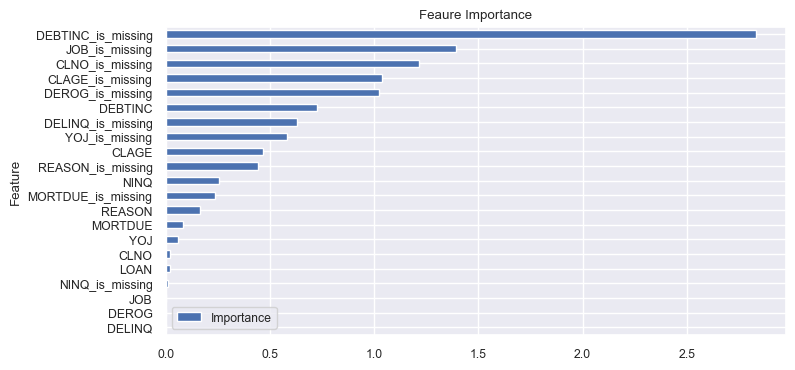

In [128]:
mylg = MyLogisticRegression(ppd.x_train, ppd.y_train, ppd.x_test, ppd.y_test, penalty='l2')
mylg.perf_analysis(show_cm=False)

In [129]:
scores_lg = mylg.scores_df
scores_lg

recall_train  precision_train  accuracy_train  f1_train  \
Logistic Regression          0.59              0.7            0.87      0.64   

                     recall_test  precision_test  accuracy_test  f1_test  
Logistic Regression         0.56            0.74           0.87     0.63

Observations

* No obvious sign of overfitting
* Accuracy is quite good (87%) but recall is weak (only 59% on training dataset)
* The 'missing' flags have the highest regression coefficients (DEBTINC in particular)
* Let's try to tune the model

#### Logistic Regression (Tuned)

In [130]:
# Create a new model (tuned version) 
lg_tuned = LogisticRegression()

# Create grid of parameters to scan
parameters = {'penalty':['l2'],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'class_weight': [None, 'balanced']
             }

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(lg_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(ppd.x_train, ppd.y_train)

# Set the classifier to the best combination of parameters
lg_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data
lg_tuned.fit(ppd.x_train, ppd.y_train)

LogisticRegression(class_weight='balanced')

-------------------------------------------------------
CLASSIFICATION REPORT


              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3355
           1       0.57      0.77      0.65       817

    accuracy                           0.84      4172
   macro avg       0.75      0.81      0.77      4172
weighted avg       0.87      0.84      0.85      4172



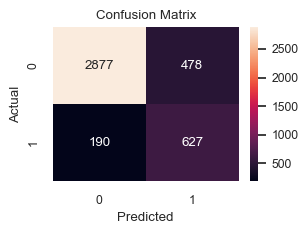

-------------------------------------------------------
CLASSIFICATION REPORT


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1416
           1       0.60      0.74      0.66       372

    accuracy                           0.84      1788
   macro avg       0.76      0.80      0.78      1788
weighted avg       0.86      0.84      0.85      1788



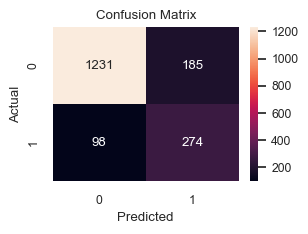

In [131]:
# train data - predict 
y_train_predicted_lg_tuned = lg_tuned.predict(ppd.x_train)

# test data - predict
y_test_predicted_lg_tuned = lg_tuned.predict(ppd.x_test)

# performance
lg_tuned_perf_train = ModelPerf(actual=ppd.y_train, predicted=y_train_predicted_lg_tuned, features=ppd.x_train)
lg_tuned_perf_train.perf_report()

lg_tuned_perf_test = ModelPerf(actual=ppd.y_test, predicted=y_test_predicted_lg_tuned, features=ppd.x_test)
lg_tuned_perf_test.perf_report()



In [132]:
# summarize stats

scores_lg_tuned = {
    'recall_train':     metrics.recall_score(ppd.y_train, y_train_predicted_lg_tuned),
    'precision_train':  metrics.precision_score(ppd.y_train, y_train_predicted_lg_tuned),
    'accuracy_train':   metrics.accuracy_score(ppd.y_train, y_train_predicted_lg_tuned),
    'f1_train':         metrics.f1_score(ppd.y_train, y_train_predicted_lg_tuned),

    'recall_test':      metrics.recall_score(ppd.y_test, y_test_predicted_lg_tuned),
    'precision_test':   metrics.precision_score(ppd.y_test, y_test_predicted_lg_tuned),
    'accuracy_test':    metrics.accuracy_score(ppd.y_test, y_test_predicted_lg_tuned),
    'f1_test':          metrics.f1_score(ppd.y_test, y_test_predicted_lg_tuned)
    }

scores_lg_tuned = pd.DataFrame(scores_lg_tuned, index=['Logistic Regression (Tuned)']).round(2)
scores_lg_tuned

recall_train  precision_train  accuracy_train  \
Logistic Regression (Tuned)          0.77             0.57            0.84   

                             f1_train  recall_test  precision_test  \
Logistic Regression (Tuned)      0.65         0.74             0.6   

                             accuracy_test  f1_test  
Logistic Regression (Tuned)           0.84     0.66

<Axes: title={'center': 'Feaure Importance'}, ylabel='Feature'>

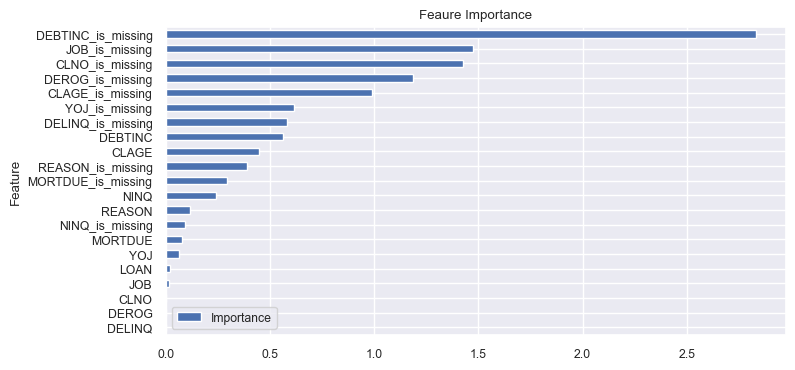

In [133]:
# feature importance
coef = lg_tuned.coef_[0]
feature_importance = pd.DataFrame({'Feature': ppd.x_train.columns, 'Importance': np.abs(coef)})
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8,4), title="Feaure Importance")


Observations
* Model tuning has a significant impact on performance and increaes recall to 0.77

### **Model 2: Decision Tree**

#### Decision Tree (Base)

In [134]:
# Choose dataset 
dtd = ds6

In [135]:
# Hyperparameters
criterion = 'entropy' # other options: gini, information gain
max_depth = 5
min_no_samples_per_leaf = 1 # default 1

In [136]:
# Create a decision tree model (classifier as we're predicting a 0/1 label) 
dt = tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)

In [137]:
# fit to training data
dt = dt.fit(dtd.x_train, dtd.y_train)

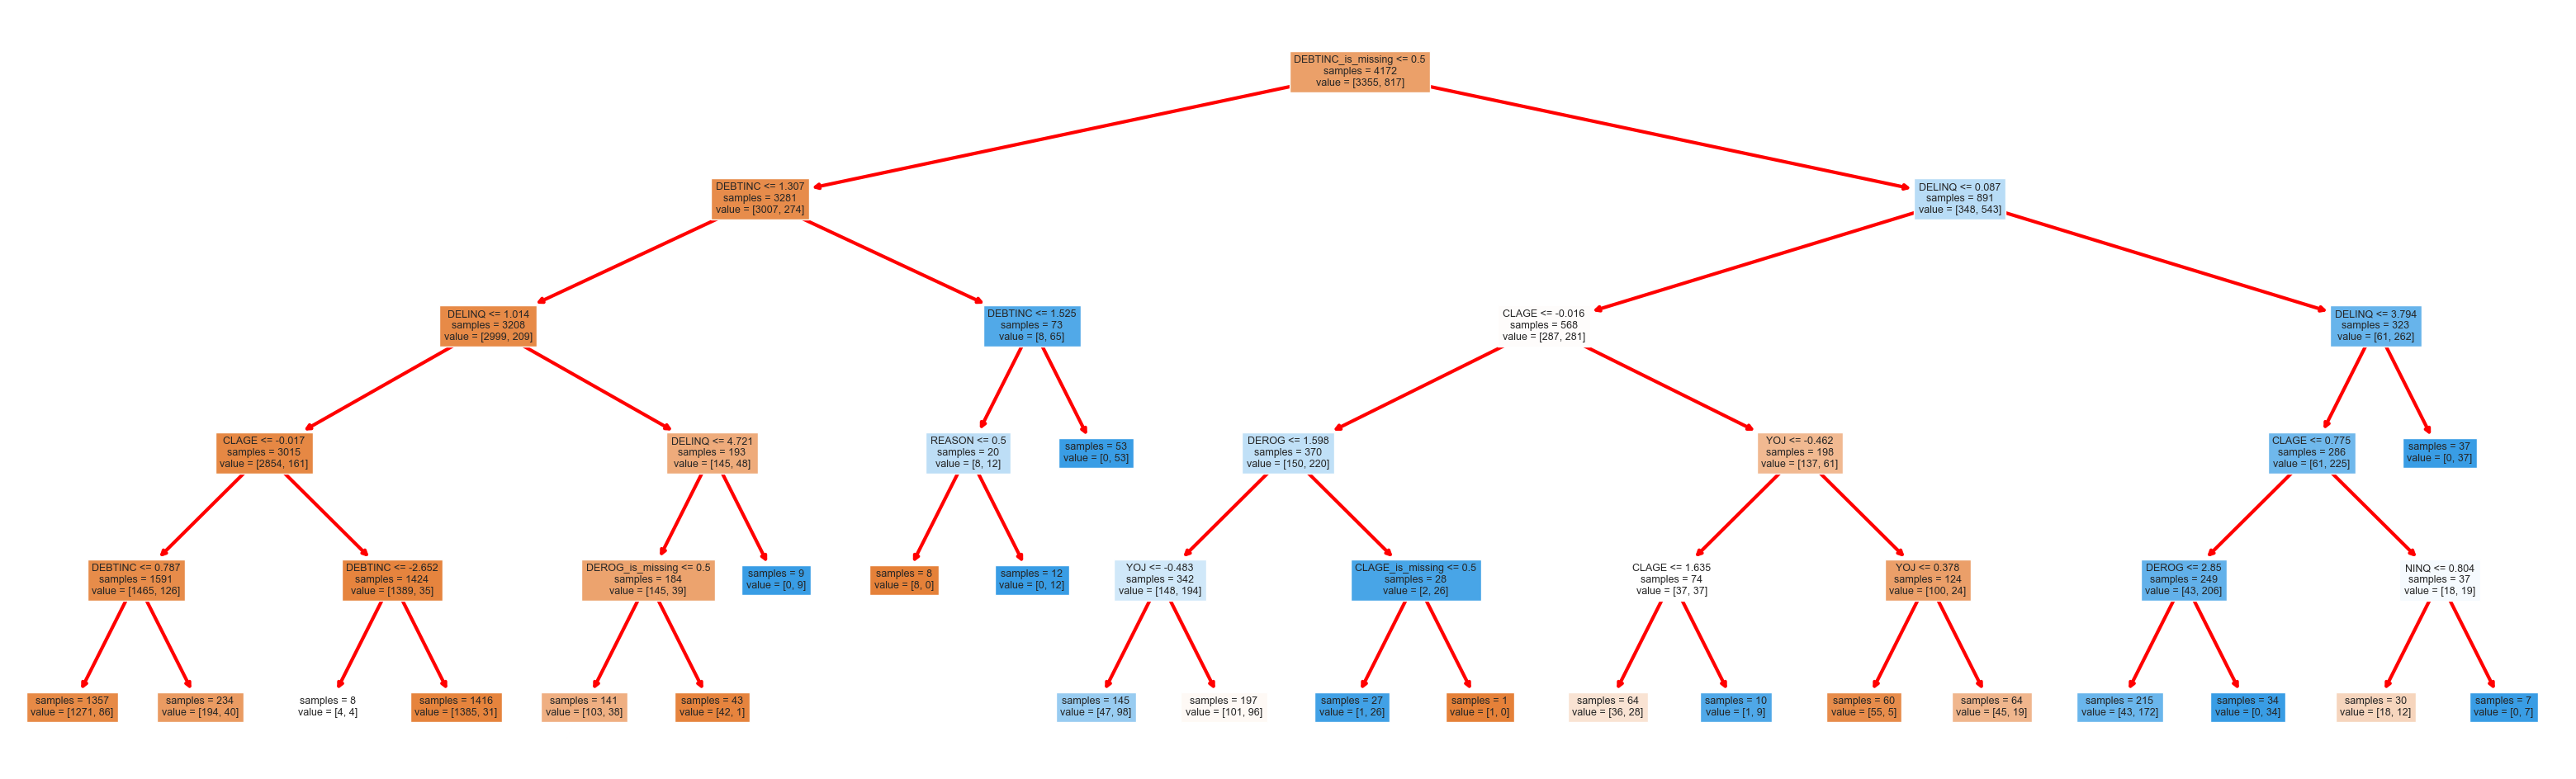

In [138]:
# plot
plot_tree(dt, dtd.x_train)

-------------------------------------------------------
CLASSIFICATION REPORT (Train data)


              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3355
           1       0.83      0.56      0.67       817

    accuracy                           0.89      4172
   macro avg       0.87      0.77      0.80      4172
weighted avg       0.89      0.89      0.88      4172



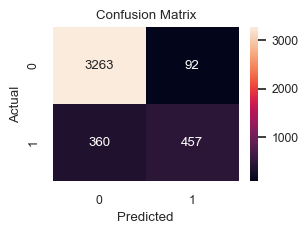

-------------------------------------------------------
CLASSIFICATION REPORT (Test data)


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1416
           1       0.81      0.51      0.63       372

    accuracy                           0.87      1788
   macro avg       0.84      0.74      0.78      1788
weighted avg       0.87      0.87      0.86      1788



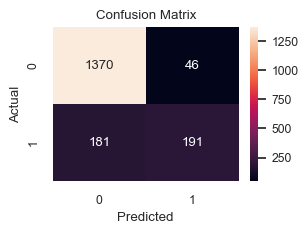

In [139]:
# Tree Performance
mp = ModelPerfTrees(dt, dtd.x_train, dtd.y_train, dtd.x_test, dtd.y_test)
mp.perf_analysis()


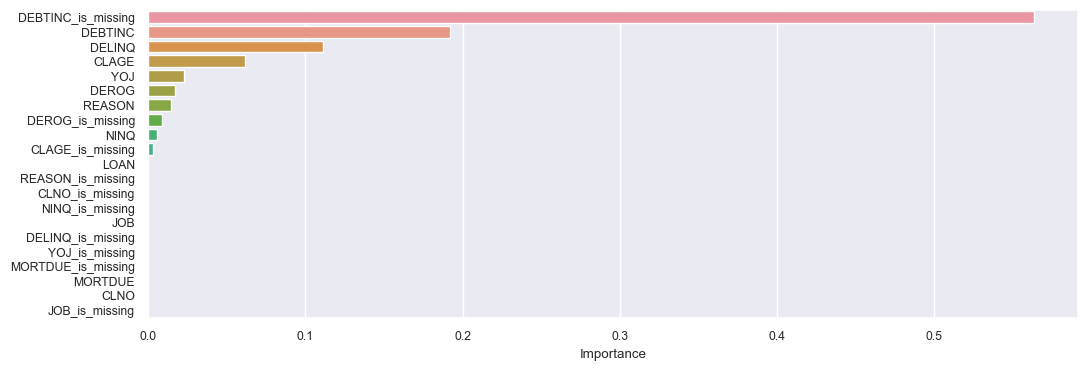

In [140]:
mp.feature_importance()

In [141]:
mp.scores_summary(index=['Decision Tree (Not Tuned)'])


recall_train  precision_train  accuracy_train  \
Decision Tree (Not Tuned)          0.56             0.83            0.89   

                           f1_train  recall_test  precision_test  \
Decision Tree (Not Tuned)      0.67         0.51            0.81   

                           accuracy_test  f1_test  
Decision Tree (Not Tuned)           0.87     0.63

#### Decision Tree (Tuned)

We'll use a Grid search to scan multiple combinations of decision tree hyperparameters and find the optimal values of the parameters, using the score as an optimization target. The hyperparameters considered here are: 
* **criterion**: metric used to quantify the "quality" of a node split. Supported criteria are **'gini'** for the Gini impurity and **'entropy'** for the information gain.
* **max_depth**: maximum depth of the tree allowed. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* **min_samples_leaf**: minimum number of samples required at any leaf node. 

More about DT: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [142]:
# Create a new classifier DT (tuned version) 
dt_tuned = tree.DecisionTreeClassifier(random_state = 1, class_weight = {0: 0.3, 1: 0.7})

# Create grid of hyperparameters to scan
parameters = {'max_depth': np.arange(2, 8), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 30]
             }

# Select metric used for optimization (recall for class 1 here)
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run grid search
grid_obj = GridSearchCV(dt_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(dtd.x_train, dtd.y_train)

# Set the classifier to the best combination of parameters
dt_tuned = grid_obj.best_estimator_

# Fit to train data
dt_tuned.fit(dtd.x_train, dtd.y_train)

DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=4,
                       min_samples_leaf=30, random_state=1)

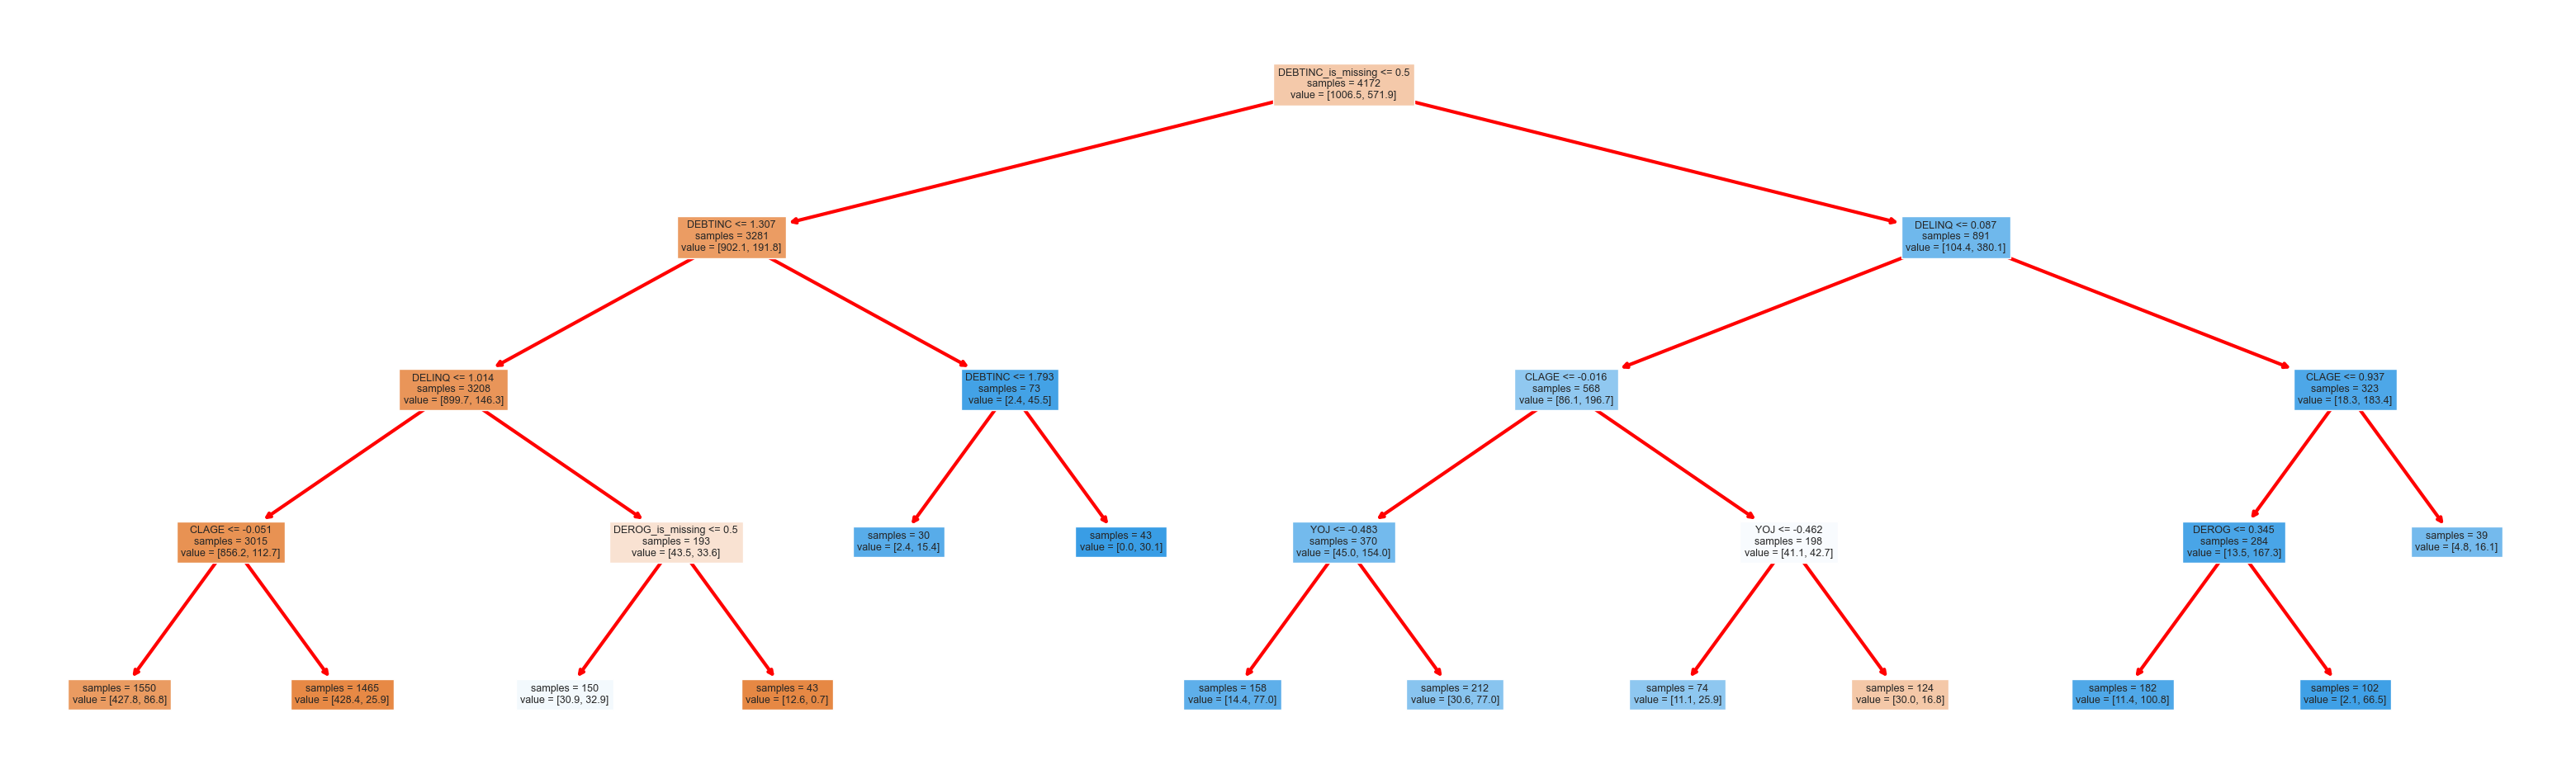

In [143]:
# plot
plot_tree(dt_tuned, dtd.x_train)

-------------------------------------------------------
CLASSIFICATION REPORT (Train data)


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      3355
           1       0.64      0.77      0.70       817

    accuracy                           0.87      4172
   macro avg       0.79      0.83      0.81      4172
weighted avg       0.88      0.87      0.87      4172



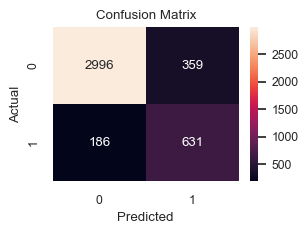

-------------------------------------------------------
CLASSIFICATION REPORT (Test data)


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1416
           1       0.66      0.75      0.70       372

    accuracy                           0.87      1788
   macro avg       0.79      0.82      0.81      1788
weighted avg       0.87      0.87      0.87      1788



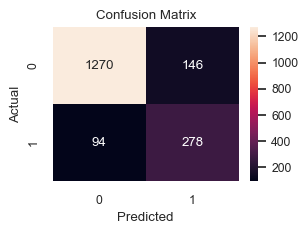

In [144]:
mptuned = ModelPerfTrees(dt_tuned, dtd.x_train, dtd.y_train, dtd.x_test, dtd.y_test)
mptuned.perf_analysis()

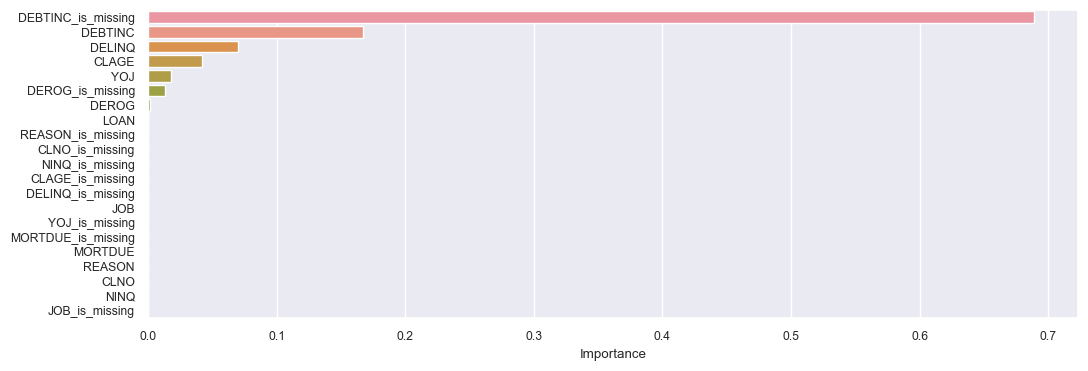

In [145]:
mptuned.feature_importance()

In [146]:
scores_dt = mptuned.scores_summary(index=['Decision Tree (Tuned)'])
scores_dt

recall_train  precision_train  accuracy_train  \
Decision Tree (Tuned)          0.77             0.64            0.87   

                       f1_train  recall_test  precision_test  accuracy_test  \
Decision Tree (Tuned)       0.7         0.75            0.66           0.87   

                       f1_test  
Decision Tree (Tuned)      0.7

Observations

* Decision Trees seem to be performing slightly better than the Logistic Regression - recall is also 77% on the tuned version, but precision, F1 and overall accuracy are a bit higher
* Again, no sign of overfitting here
* The tuned decision tree has a depth of 4
* The DEBTINC factor dominates feature importance and the fact that it's missing is more important than the actual level


### **Model 3: Random Forest Classifier**

Random Forest is a bagging algorithm where the base models are Decision Trees. Samples are taken from the training data and on each sample a decision tree makes a prediction. 
The results from all the decision trees are combined together and the final prediction is made using voting or averaging.

Random Forest (Base)

In [147]:
# Choose dataset 
rfd = ds6

In [148]:
# Create a Random Forest model (classifier as we're predicting a 0/1 label) 
rf_estimator = RandomForestClassifier(random_state = 1)
#rf_estimator = RandomForestClassifier(class_weight = {0: 0.7, 1: 0.3}, random_state = 1)

In [149]:
# Fit the Random Forest classifier 
rf_estimator.fit(rfd.x_train, rfd.y_train)

RandomForestClassifier(random_state=1)

In [150]:
rfmp = ModelPerfTrees(rf_estimator, rfd.x_train, rfd.y_train, rfd.x_test, rfd.y_test)

-------------------------------------------------------
CLASSIFICATION REPORT (Train data)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3355
           1       1.00      1.00      1.00       817

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



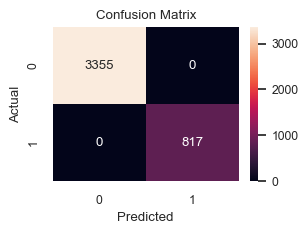

-------------------------------------------------------
CLASSIFICATION REPORT (Test data)


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1416
           1       0.84      0.68      0.75       372

    accuracy                           0.91      1788
   macro avg       0.88      0.82      0.85      1788
weighted avg       0.90      0.91      0.90      1788



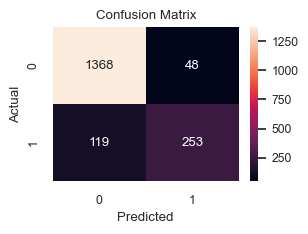

In [151]:
rfmp.perf_analysis()

#### Random Forest (Tuned)

In [152]:
def run_rf_grid_search(x_train, y_train):

    # generic function to run grid search for RF model (wrapping it so it doesn't run every time - bit slow)

    # Create new RF (tuned) 
    # Use entropy as a fixed criterion (DT analysis showed it was the best)
    rf_estimator_tuned = RandomForestClassifier(criterion = "entropy", random_state = 1)

    # Create grid of parameters to scan
    params_rf = {"n_estimators": [100, 110, 120],
                 "max_depth": [4, 5, 6, 7],
                 "min_samples_leaf": [5, 10, 20, 30],
                 "max_features": [0.8, 0.9],
                 "max_samples": [0.9, 1],
                 "class_weight": ["balanced", {0: 0.2, 1: 0.8}]}

    # Type of scoring used to compare parameter combinations - recall score for class 1
    scorer = metrics.make_scorer(recall_score, pos_label = 1)

    # Run the grid search on the training data using scorer=scorer and cv=5
    grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

    grid_obj = grid_obj.fit(x_train, y_train)

    # Save the best estimator to variable rf_estimator_tuned
    rf_estimator_tuned = grid_obj.best_estimator_

    #Fit the best estimator to the training data
    rf_estimator_tuned.fit(x_train, y_train)

    return rf_estimator_tuned

In [153]:
# run grid search
rf_estimator_tuned = run_rf_grid_search(rfd.x_train, rfd.y_train)

In [154]:
rf_estimator_tuned

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=30, random_state=1)

In [155]:
rfmp_tuned = ModelPerfTrees(rf_estimator_tuned, rfd.x_train, rfd.y_train, rfd.x_test, rfd.y_test)

-------------------------------------------------------
CLASSIFICATION REPORT (Train data)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      3355
           1       0.67      0.80      0.73       817

    accuracy                           0.88      4172
   macro avg       0.81      0.85      0.83      4172
weighted avg       0.89      0.88      0.89      4172



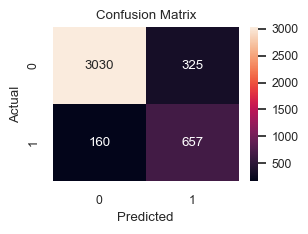

-------------------------------------------------------
CLASSIFICATION REPORT (Test data)


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1416
           1       0.66      0.74      0.70       372

    accuracy                           0.87      1788
   macro avg       0.80      0.82      0.81      1788
weighted avg       0.87      0.87      0.87      1788



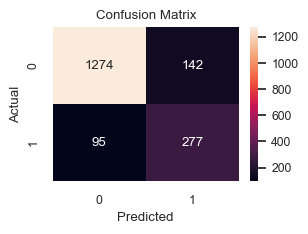

In [156]:
rfmp_tuned.perf_analysis()

In [157]:
scores_rf = rfmp_tuned.scores_summary(index=['Random Forest (Tuned)'])
scores_rf

recall_train  precision_train  accuracy_train  \
Random Forest (Tuned)           0.8             0.67            0.88   

                       f1_train  recall_test  precision_test  accuracy_test  \
Random Forest (Tuned)      0.73         0.74            0.66           0.87   

                       f1_test  
Random Forest (Tuned)      0.7

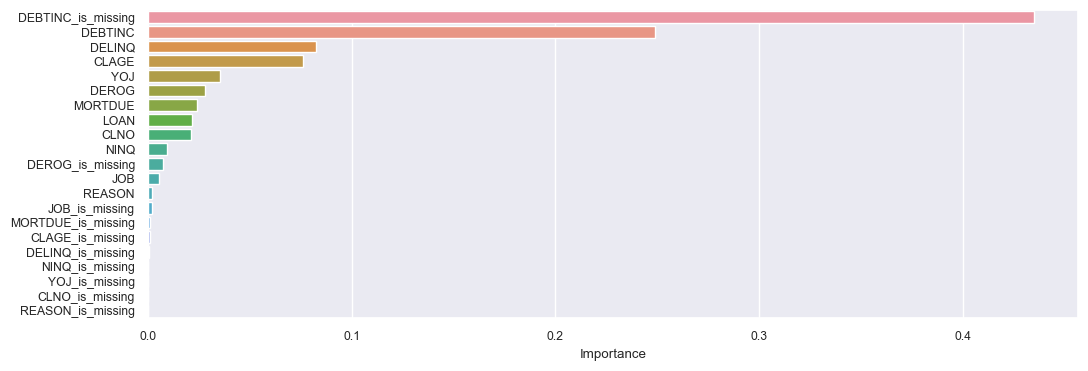

In [158]:
plot_importance(rf_estimator_tuned, rfd.x_train)

Observations

* As expected the Random Forest is performing better than the Decision Tree
* Recall is now 78% on the tuned model (training data) vs 74% for the DT. There seems to be slight overfitting though (recall on test data is 73%)
* Precision and accuracy are about the same as the DT
* Feature importance: DEBTINC_missing and DEBTINC (level) are again the most important features by far, but the RF seems to be better at identifying other risk factors including CLAGE, VALUE and LOAN (interesting as univariate analysis showed that default rates were high when those factors were low).

### **Model Comparison**

Below is a summary of the main performance stats for Logistic Regression, Decision Tree and Random Forest

In [159]:
# Combine Main Model Stats
model_comp = pd.concat([scores_lg_tuned, scores_dt, scores_rf]).round(2)
model_comp

recall_train  precision_train  accuracy_train  \
Logistic Regression (Tuned)          0.77             0.57            0.84   
Decision Tree (Tuned)                0.77             0.64            0.87   
Random Forest (Tuned)                0.80             0.67            0.88   

                             f1_train  recall_test  precision_test  \
Logistic Regression (Tuned)      0.65         0.74            0.60   
Decision Tree (Tuned)            0.70         0.75            0.66   
Random Forest (Tuned)            0.73         0.74            0.66   

                             accuracy_test  f1_test  
Logistic Regression (Tuned)           0.84     0.66  
Decision Tree (Tuned)                 0.87     0.70  
Random Forest (Tuned)                 0.87     0.70

* Recall: all models have a recall between [0.77- 0.80] on training data, [0.74-0.75]. RF is slightly overfitting training data
* Precision and Accuracy: DT and RF perform slightly better than LR on those metrics, translating into a better f1 score as well
* Why choose the Decision Tree? RF looks marginally better on performance alone but DT is:
    * Easier to interpret / communicate – important factor given the context (can follow the path and explain why an application was rejected)
    * Computationally less expensive than RF 



